In [1]:
# python -m pip install SoundFile
import glob
import os
from info import i, printb, printr, printp, print
import glob
import os
import librosa
import pdb
import csv
import json
import re
import numpy as np
import random
import librosa.display
import IPython.display as ipd
from sklearn import preprocessing
from collections import Counter
from matplotlib import pyplot as plt
from info import i, printb, printr, printp, print
import muda
import jams
from sklearn import svm
import librosa
import keras
import scipy.io as sio
import io

Using TensorFlow backend.


In [3]:
#----------------------------------- parameters to change-----------------------------------#
block_size=1 # blocks of 60 seconds
thresholds=[0, 0.5]  # minimum length for nobee intervals: 0 or 5 seconds (creates one label file per threshold value)
path_audioFiles="C:\\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset"+os.sep  # path to audio files
annotations_path="C:\\Users\PC\python\Stage\To Bee or not to Bee_the annotated dataset"+os.sep # path to .lab files
path_save_audio_labels= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
#-------------------------------------------------------------------------------------------#


In [4]:
# if path doesn't exist then create one !!!
if not os.path.exists(path_save_audio_labels):
    os.makedirs(path_save_audio_labels)

In [43]:
def read_beeNotBee_annotations_saves_labels(audiofilename, block_name,  blockStart, blockfinish, annotations_path, threshold=0):
  
    block_length=blockfinish-blockStart
    #print("block_length: ", block_length)
    if audiofilename.startswith('#'):
        annotation_filename=audiofilename[1:-4]+'.lab'
    else :
        annotation_filename=audiofilename[0:-4]+'.lab'
        
        
    try:    
        with open(annotations_path + os.sep + annotation_filename,'r') as f:
            # EXAMPLE FILE:
            
            # CF003 - Active - Day - (223)
            # 0	8.0	bee
            # 8.01	15.05	nobee
            # 15.06	300.0	bee 
            # .
            #
            
            # all files end with a dot followed by an empty line.

            print(annotations_path + os.sep + annotation_filename)
            lines = f.read().split('\n')
        
            labels_th=['bee', 0.0]
            label2assign='bee'
            label_strength=0
            intersected_s=0
                            
            for line in lines:
                if (line == annotation_filename[0:-4]) or (line == '.') or (line ==''):
                    #ignores title, '.', or empty line on the file.
                    continue
                
               ## print("#############################  line ",line)
                parsed_line= line.split('\t')    
                
                assert (len(parsed_line)==3), ('expected 3 fields in each line, got: '+str(len(parsed_line))) 
                
                
                tp0=float(parsed_line[0])
               ## print("tp0: ",tp0)
                tp1=float(parsed_line[1])
               ## print("tp1: ",tp1)
                annotation_label=parsed_line[2]
                if blockfinish < tp0: # no need to read further nobee intervals since annotation line is already after block finishes
                    break
                    
                if annotation_label== 'nobee':
               
                   ## print("...............annotation_label=='nobee'..........................")    
                        
                    if tp1-tp0 >= threshold:  # only progress if nobee interval is longer than defined threshold.
                    
                        if tp0 > blockStart and tp0 <= blockfinish and tp1 >= blockfinish:
                            
                            intersected_s=intersected_s + (blockfinish-tp0)  
                           ## print(" # bs          tp0 ######## bf########tp1")
                            # |____________########|########
                            # bs          tp0      bf      tp1 
                        
                        elif tp1 >= blockStart and tp1 < blockfinish and tp0 <= blockStart:
                            
                            intersected_s=intersected_s+ (tp1-blockStart)
                           ## print("# tp0 ######## bs  ########   tp1    bf")
                            # #####|########_____|
                            # tp0  bs     tp1    bf
                            
                            
                        elif tp1 >= blockStart and tp1 <= blockfinish and tp0 >= blockStart and tp0 <= blockfinish:
                            
                            intersected_s=intersected_s+ (tp1-tp0)
                          ##  print("#bs   tp0  ########  tp1    bf")
                            # |_____########_____|
                            # bs   tp0    tp1    bf
                        
                        elif tp0 <= blockStart and tp1 >= blockfinish:
                            
                            intersected_s=intersected_s + (blockfinish-blockStart)
                          ##  print("tp0 #### bs############bf #### tp1")
                            #  ####|############|####
                            # tp0  bs           bf  tp1
                            
                    if intersected_s > 0:
                        label2assign='nobee'
                    label_strength= intersected_s/block_length # proportion of nobee length in the block
                    
                    
                    labels_th= [label2assign, round(label_strength,3)]  # if label_strehgth ==0 --> bee segment 
                    
                    
            assert (blockfinish <=tp1 ), ('the end of the request block falls outside the file: block ending: '+ str(blockfinish)+' end of file at: '+ str(tp1))
            
                
    except FileNotFoundError as e:
        print(e, '--Anotation file does not exist! label as unknown')
        #print(annotation_filename=audiofilename[0:-4]+'.lab')
            
        label2assign = 'unknown'
        label_strength=-1
        
        labels_th = [label2assign, label_strength]
            
    except Exception as e1:
        print('unknown exception: '+str(e1))
        #quit
    
    
    return labels_th

In [44]:
def load_audioFiles_saves_segments( path_audioFiles,path_save_audio_labels, block_size , thresholds, annotations_path, read_beeNotBee_annotations ='yes', save_audioSegments='yes'):

    
    audiofilenames_list = [os.path.basename(x) for x in glob.glob(path_audioFiles+'*.mp3')]
    audiofilenames_list.extend([os.path.basename(x) for x in glob.glob(path_audioFiles+'*.wav')])
    
    printb("Number of audiofiles in folder: "+str(len(audiofilenames_list)))
   # print("audiofilenames_list ",audiofilenames_list)
    
    fi=0
    for file_name in audiofilenames_list:
        fi=fi+1
       # print('\n')
       # printb('Processing '+ file_name+'          :::file number:  '+str(fi)+' --------->of '+str(len(audiofilenames_list)))
          

        offset=0
        block_id =0
        
        
        while 1:
                    
            # READ ONE BLOCK OF THE AUDIO FILE
            try:
                ## Read one block of 60 seconds 
                block,sr = librosa.core.load(path_audioFiles+file_name, offset=offset, duration=block_size)
               # print(block.shape , sr)
               # print('-----------------Reading segment '+str(block_id))
            except ValueError as e:
                e
                if 'Input signal length' in str(e):
                    block=np.arange(0)
            except FileNotFoundError as e1:
                print(e1, ' but continuing anyway')
                
            ##print("test")
            if block.shape[0] > 0:    #when total length = multiple of blocksize, results that last block is 0-lenght, this if bypasses those cases.
                
                block_name=file_name[0:-4]+'__segment'+str(block_id)
               ## print(block_name)
                
                # READ BEE NOT_BEE ANNOTATIONS:
                if read_beeNotBee_annotations == 'yes':
                   # print('---------------------Will read BeeNotbee anotations and create labels for segment'+str(block_id))
                    blockStart=offset
                    ##print("blockStart: ",blockStart)
                    blockfinish=offset+block_size
                    ##print("blockfinish: ",blockfinish)
                    
                    for th in thresholds:
                        #print("th::::::::::", th)
                        label_file_exists = os.path.isfile(path_save_audio_labels+'labels_BeeNotBee_th'+str(th)+'.csv')
                        with open(path_save_audio_labels+'labels_BeeNotBee_th'+str(th)+'.csv','a', newline='') as label_file:
                            writer =csv.DictWriter(label_file, fieldnames=['sample_name', 'segment_start','segment_finish', 'label_strength', 'label'], delimiter=',')
                            if not label_file_exists:
                                writer.writeheader()
                          ##  print("start read_beeNotBee_annotation_saves_labels")
                            label_block_th=read_beeNotBee_annotations_saves_labels(file_name, block_name,  blockStart, blockfinish, annotations_path, th)                            
                           # print("label_block_th : ", label_block_th)                           
                            writer.writerow({'sample_name': block_name, 'segment_start': blockStart, 'segment_finish': blockfinish , 'label_strength': label_block_th[1],  'label': label_block_th[0]} )
                           # print('-----------------Wrote label for th '+ str(th)+' seconds of segment'+str(block_id)  ) 
                    
               
                # MAKE BLOCK OF THE SAME SIZE:
                if block.shape[0] < block_size*sr:   
                    block = uniform_block_size(block, block_size*sr, 'repeat')
                   # print('-----------------Uniformizing block length of segment'+str(block_id)  ) 

                        
            
                # Save audio segment:
                if save_audioSegments=='yes' and (not os.path.exists(path_save_audio_labels+block_name+'.wav')): #saves only if option is chosen and if block file doesn't already exist.
                    librosa.output.write_wav(path_save_audio_labels+block_name+'.wav', block, sr)
                    #print( '-----------------Saved wav file for segment '+str(block_id))
                
                    
                    
            else :
                #print('----------------- no more segments for this file--------------------------------------')
               # print('\n')
                break
            offset += block_size
            block_id += 1
    printb('______________________________No more audioFiles___________________________________________________')
       
    return 


In [45]:
def uniform_block_size(undersized_block, block_size_samples, method='repeat' ):

    lengthTofill=(block_size_samples)-(undersized_block.size)
    if method == 'zero_padding':
        new_block=np.pad(undersized_block, (0,lengthTofill), 'constant', constant_values=(0) )

    elif method=='mean_padding':
        new_block=np.pad(undersized_block, (0,lengthTofill), 'mean' )
    
    elif method=='repeat':        
        new_block= np.pad(undersized_block, (0,lengthTofill), 'reflect')
    else:
       # print('methods to choose are: \'zero_padding\' ,\'mean_padding\' and \'repeat\' ' )
        new_block=0
              
    return new_block

In [ ]:
load_audioFiles_saves_segments( path_audioFiles, path_save_audio_labels, block_size , thresholds, annotations_path, read_beeNotBee_annotations='yes', save_audioSegments='yes')    

In [35]:
# read only labels_BeeNotBee_th0.5
path_beeNotbee_labels = path_save_audio_labels + 'labels_BeeNotBee_th'+str(thresholds[1])+'.csv'
print("path_beeNotbee_labels: ",path_beeNotbee_labels)

[2020-05-18 19:08:00 RAM65.7% 0.94GB] path_beeNotbee_labels:  C:\Users\PC\python\Stage\dataset_BeeNoBee_2_second1sec\labels_BeeNotBee_th0.5.csv


In [10]:
def read_HiveState_fromSampleName( filename, states):   #states: state_labels=['active','missing queen','swarm' ]
    label_state='other'
    for state in states:
        if state in filename.lower():
           # print("1 ", filename)
            label_state = state
    #incorporate condition for Nu-hive recordings which do not follow the same annotation: 'QueenBee' or 'NO_QueenBee'
    
    if label_state=='other':
        if 'NO_QueenBee' in filename:
            ##print("NO_QueenBee",label_state )
            label_state = states[1]
        else:
            label_state=states[0]
    return label_state

In [11]:
def write_Statelabels_from_beeNotBeelabels(path_save, path_labels_BeeNotBee, states=['active','missing queen','swarm' ]):
    
    #label_file_exists = os.path.isfile(path_save+'state_labels.csv')
    liste=[]
    with open(path_labels_BeeNotBee, 'r' ) as rfile, \
    open(path_save+'state_labels.csv', 'w', newline='') as f_out:
        csvreader = csv.reader(rfile, delimiter=',')
        writer= csv.DictWriter(f_out, fieldnames=['sample_name', 'label'], delimiter=',') 
        #if not label_file_exists:
        writer.writeheader()
        
        for row in csvreader:
            if not row[0]=='sample_name':
                if row[4]=='bee':
                    label_state=read_HiveState_fromSampleName(row[0], states)
                    #print(row[0],"label_state : ", label_state)
                    writer.writerow({'sample_name':row[0], 'label':label_state})
                else:   liste.append(row[0])  
    return liste

In [35]:
 # reads labels beeNotBee files and creates corresponding states label file
liste= write_Statelabels_from_beeNotBeelabels(path_save_audio_labels, path_beeNotbee_labels, states=['active','missing queen','swarm' ])
    

In [37]:
#import os
#for i in range(len(liste)):
#    os.remove(path_save_audio_labels+liste[i]+'.wav')
#liste[0]  

In [5]:
def get_list_samples_names(path_audioSegments_folder, extension='.wav'):
    # Recupèrer tout les audios d'extention .wav"""""" glob.glob(path_audioSegments_folder+'*'+extension)""""""
    sample_ids=[os.path.basename(x) for x in glob.glob(path_audioSegments_folder+'*'+extension)]
    return sample_ids
    

In [6]:
sample_ids=get_list_samples_names(path_save_audio_labels) # get sample ids from audio segments folder.
print(len(sample_ids) ) 
#sample_ids[0:10]

[2020-05-27 13:18:49 RAM56.8% 0.29GB] 17295


In [17]:
#----------------------------------- parameters to change-----------------------------------#
block_size=1 # blocks of 60 seconds
path_workingFolder='C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
labels2read= 'state_labels'
feature = 'MFCCs20'
path_working_MFCCs20= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+'\\MFCCs20_matrix.mat'+os.sep
path_working_stft= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+'\\stft_matrix.mat'+os.sep
path_working_TTBOX= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+'\\TTBOX_matrix.mat'+os.sep
path_working_cqt= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+'\\cqt_matrix.mat'+os.sep


#-----------------------------------parameters for TTBOX -----------------------------------#
import timbre_descriptor as td
import numpy as np
import scipy as sc
import my_tools as mt
from collections import namedtuple
import scipy
import scipy.signal
from scipy.io import wavfile
import numpy as np
from scipy.io import savemat
from scipy.sparse import csr_matrix
from os.path import dirname, join as pjoin
import matplotlib
import swipep as swp             # used for sing le-F0 estimation
import warnings                 # used for warning removal
import time               # used performance benchmark
import librosa
nbits = 16;
MAX_VAL = pow(2,(nbits-1)) * 1.0;

In [18]:
def get_features_from_sampless(path_audio_samples, sample_ids, raw_feature, normalization, high_level_features ): 
    #normalization = NO, z_norm, min_max
    ## function to extract features 
    #high_level_features = 0 or 1 
    #file_path = os.path.isfile(path_save_audio_labels+'matrix.mat'+'.csv') 
    n_samples_set = len(sample_ids) # 4
    feature_Maps = []
    if raw_feature== 'MFCCs20': 
         path_working= path_working_MFCCs20
    else: 
        path_working= path_working_stft
    
    for sample in sample_ids:
        # raw feature extraction:
        print("sample: ",sample)
        x = raw_feature_fromSample( path_audio_samples+sample, raw_feature ) # x.shape: (4, 20, 2584)
       # print("x.shape: ",x.shape)
       # Sauvgarder les x dans un fichier .mat 
     
        #b = csr_matrix(x)
        savemat(path_working+ sample[0:-4]+ '.mat', {'b': x})
         
                         
                    
        ##normalization here:si on veut les résultats pour Conv1D on utlise la normalisation 
        ##normalization here:
        if not normalization == 'NO':
             x_norm = featureMap_normalization_block_level(x, normalizationType = normalization) 
        else: x_norm = x
        
        if high_level_features:
            # high level feature extraction:
            if 'MFCCs' in raw_feature:
                X = compute_statistics_overMFCCs(x_norm, 'yes') # X.shape: (4 , 120)
            else: 
                X = compute_statistics_overSpectogram(x_norm)
                
            feature_map=X
        else:
            feature_map=x_norm
        
        
        feature_Maps.append(feature_map)
        
    return feature_Maps

In [ ]:
def raw_feature_fromSample( path_audio_sample, feature2extract ):
        
    s, Fs = librosa.core.load(path_audio_sample) # sr= 22050
    #m = re.match(r"\w+s(\d+)", feature2extract) #  m:  <re.Match object; span=(0, 7), match='MFCCs20'>
    #n_freqs=int(m.groups()[0]) ## n_freqs= 20
    #Melspec = librosa.feature.melspectrogram(audio_sample, n_mels = n_freqs) # computes mel spectrograms from audio sample, 
    
    if 'MFCCs' in feature2extract:
        n_freqs = int(feature2extract[5:len(feature2extract)]) ## n_freqs==20
        Melspec = librosa.feature.melspectrogram(s, sr=Fs)
        x = librosa.feature.mfcc(S=librosa.power_to_db(Melspec),sr=Fs, n_mfcc = n_freqs)
        #x = librosa.feature.mfcc(s ,Fs=Fs, n_mfcc = n_freqs)
        #print(x.shape)
    elif 'TTBOX' in feature2extract:
        r_Fs = librosa.resample(s, Fs, 44100)
        r_Fs=44100
        s= s/MAX_VAL;
        N = len(s);
       
        desc_TEE, desc_AS, desc_STFTmag, desc_STFTpow, desc_Har, desc_ERB, desc_GAM =td.compute_all_descriptor(s, r_Fs);
        desc  = [desc_TEE, desc_AS, desc_STFTmag, desc_STFTpow, desc_Har, desc_ERB, desc_GAM];

        ### Time serie integration
        param_val, field_name = td.temporalmodeling(desc);
        x=param_val
    else:
        x = Melspec

    return x 

In [22]:
def raw_feature_fromSample( path_audio_sample, feature2extract ):
        
    s, Fs = librosa.core.load(path_audio_sample) # sr= 22050
    #m = re.match(r"\w+s(\d+)", feature2extract) #  m:  <re.Match object; span=(0, 7), match='MFCCs20'>
    #n_freqs=int(m.groups()[0]) ## n_freqs= 20
    #Melspec = librosa.feature.melspectrogram(audio_sample, n_mels = n_freqs) # computes mel spectrograms from audio sample, 
    
    if 'MFCCs' in feature2extract:
        n_freqs = int(feature2extract[5:len(feature2extract)]) ## n_freqs==20
        Melspec = librosa.feature.melspectrogram(s, sr=Fs)
        x = librosa.feature.mfcc(S=librosa.power_to_db(Melspec),sr=Fs, n_mfcc = n_freqs)
        #x = librosa.feature.mfcc(s ,Fs=Fs, n_mfcc = n_freqs)
        #print(x.shape)
    # Short-time Fourier transform    
    elif 'stft' in feature2extract:
        x= librosa.stft(s , n_fft=2048)
    # constante Q transform    
    elif 'cqt' in  feature2extract:
        x=  np.abs(librosa.cqt(s, Fs))
    # timber tool box     
    elif 'TTBOX' in feature2extract:
        r_Fs = librosa.resample(s, Fs, 44100)
        r_Fs=44100
        s= s/MAX_VAL;
        N = len(s);
       
        desc_TEE, desc_AS, desc_STFTmag, desc_STFTpow, desc_Har, desc_ERB, desc_GAM =td.compute_all_descriptor(s, r_Fs);
        desc  = [desc_TEE, desc_AS, desc_STFTmag, desc_STFTpow, desc_Har, desc_ERB, desc_GAM];

        ### Time serie integration
        param_val, field_name = td.temporalmodeling(desc);
        x=param_val
    
        
    else:
        x = Melspec

    return x 


In [23]:
def get_features_from_samples(path_audio_samples, sample_ids, raw_feature, normalization, high_level_features ): 
    #normalization = NO, z_norm, min_max
    ## function to extract features 
    #high_level_features = 0 or 1 
    #file_path = os.path.isfile(path_save_audio_labels+'matrix.mat'+'.csv') 
    n_samples_set = len(sample_ids) # 4
    feature_Maps = []
    if raw_feature== 'MFCCs20': 
         path_working= path_working_MFCC20
    elif  raw_feature=='TTBOX': 
         path_working= path_working_TTBox
    elif raw_feature=='stft':
         path_working= path_working_stft
    else: 
        path_working= path_working_cqt
    
    for sample in sample_ids:
        # raw feature extraction:
        print("sample: ",sample)
        x = raw_feature_fromSample( path_audio_samples+sample, raw_feature ) # x.shape: (4, 20, 2584)
       # print("x.shape: ",x.shape)
       # Sauvgarder les x dans un fichier .mat 
     
        b = csr_matrix(x)
        savemat(path_working+ sample + '.mat', {'b': b})
         
                         
                    
        ##normalization here:si on veut les résultats pour Conv1D on utlise la normalisation 
        ##normalization here:
        if not normalization == 'NO':
             x_norm = featureMap_normalization_block_level(x, normalizationType = normalization) 
        else: x_norm = x
        
        if high_level_features:
            # high level feature extraction:
            if 'MFCCs' in raw_feature:
                X = compute_statistics_overMFCCs(x_norm, 'yes') # X.shape: (4 , 120)
            else: 
                X = compute_statistics_overSpectogram(x_norm)
                
            feature_map=X
        else:
            feature_map=x_norm
        
        
        feature_Maps.append(feature_map)
        
    return feature_Maps

In [25]:
X=get_features_from_samples(path_workingFolder, sample_ids, 'cqt', 'NO', 0)

In [14]:
def labels2binary(pos_label, list_labels):  # pos_label = missing queen / nobee
    list_binary_labels=[]
    for l in list_labels:
        #print("l=", l, "pos_label= ", pos_label)
        if l == pos_label:
            list_binary_labels.append(1)
        else:
            list_binary_labels.append(0)
    return list_binary_labels

In [15]:
def get_GT_labels_fromFiles(path_labels, sample_ids, labels2read) : #labels2read =  name of the label file    
    
    ##reads labels files and retreives labels for a sample set given by sample_ids
    # input:  path_labels: where label file is 
    #         sample_ids: list of sample names that we want the label
    #         labels2read: name of the labels file: state_labels, labels_BeeNotBee_th0 ...
    
    # output: list of string labels, in same order as sample_ids list
    
    labels = []
    fileAsdict={}
    
    with open(path_labels + labels2read+'.csv', 'r') as labfile:
        csvreader = csv.reader(labfile, delimiter=',')    
        for row in csvreader:
            if not row[0] == 'sample_name':
               # print("row[0]",row[0]) # CF001 - Missing Queen - Day -__segment0
               # print("row[-1]:", row[-1])  # bee or nobee
                fileAsdict[row[0]]=row[-1]   # row[-1] = '/missing queen/active' or 'bee/nobee'
            
    for sample in sample_ids:
        #print(sample)
        #print(fileAsdict[sample[0:-4]]) # bee nobee or unknown 
        labels.append(fileAsdict[sample[0:-4]])  #remove .wav extension
    
       
    return labels  


In [120]:
labels = get_GT_labels_fromFiles(path_workingFolder, sample_idss, labels2read)
Y= labels2binary('active', labels)
#labels[0:10], Y[0:10]

In [16]:
def get_items2replicate(list_Binary_labels, list_sample_ids):
    
    # get the samples to be replicated.
    # input: list of labels and sample_ids with same oreder!
    # ouptut: dictionary keys:name of samples to be replicated,  value: Number of times to replicate that sample.
    
    #assert( len(list_Binary_labels) - len(list_sample_ids) == 0), ('arguments should have the same number of elements)
    dict_items_replicate={}
    
    n_samples = len(list_Binary_labels)# 193
    #print("n_samples: ", list_Binary_labels)
    n_positive_labels = sum(list_Binary_labels)#158 = le nbr de 1
    #print("n_positive_labels: ",n_positive_labels)
    n_negative_labels = n_samples - n_positive_labels #35= le nbr de 0
    #print("n_negative_labels: ",n_negative_labels)
    
    pos_samples=[]
    neg_samples=[]
    
    for i in range(n_samples):
        if list_Binary_labels[i] == 1 :
            #print("list_sample_ids[i]= : ", list_sample_ids[i])
            pos_samples.append(list_sample_ids[i])
        else: 
            neg_samples.append(list_sample_ids[i])
            
    if n_positive_labels > n_negative_labels:
        #print(n_positive_labels, n_negative_labels)
        # Replicate negative samples as needed:
        dif=n_positive_labels-n_negative_labels
        items_replicate=random.choices(neg_samples, k=dif)
       # print("neg_samples= ",neg_samples, "items_replicate=",items_replicate)
 
    elif n_positive_labels < n_negative_labels:
        dif=n_negative_labels-n_positive_labels
        items_replicate=random.choices(pos_samples, k=dif)
              
    dict_items_replicate=Counter(items_replicate)
    #print(dict_items_replicate)
    return dict_items_replicate


In [17]:
def BalanceData_online(y_set, x_set, sample_ids_set):
    
    ## balances already processed data (X and Y, just before classifier) by replicating samples of the least represented class.
    # input: y_set - binary labels of set, x_set - feature_maps of set, sample_ids_set - sample names in set, ( all have the same order!)
    # output: X, Y and sample_ids with replicated samples concatenated 
    
 
    printb( 'Balancing training data:' )
    print('will randomly replicate samples from least represented class')
    
    x2concatenate = x_set
    y2concatenate = y_set
    sample_ids2concatenate = sample_ids_set
    
    dict_items_replicate = get_items2replicate(y_set,sample_ids_set )
    #print("dict_items_replicate: ",dict_items_replicate)
    
    for i in range(len(sample_ids_set)):
        if sample_ids_set[i] in dict_items_replicate.keys() :
            
            sample_ids2concatenate =np.concatenate([sample_ids2concatenate, [sample_ids_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            y2concatenate = np.concatenate([y2concatenate, [y_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            x2concatenate = np.concatenate([x2concatenate, [x_set[i]]*dict_items_replicate[sample_ids_set[i]]])
            
    return y2concatenate, x2concatenate, sample_ids2concatenate

In [83]:
path_save_audio_MFCCs= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+'\\MFCCs20_matrix.mat'+os.sep  # path where 

def get_list_samples_name_MFCC(path_audioSegments, extension='.mat'):
    states=['active','missing queen','swarm' ]
    X_ttbox=[]
    labels=[]
    Y=[]
    sample_ids=[]
    # Recupèrer tout les audios d'extention .wav"""""" glob.glob(path_audioSegments_folder+'*'+extension)""""""
    #list_mfcc=[os.path.basename(x) for x in glob.glob(path_audioSegments+'*'+extension)]
    
    for x in glob.glob(path_audioSegments+'*'+extension): 
        sample=x[74:]
        sample_ids.append(sample)
        l= read_HiveState_fromSampleName( sample, states)
        labels.append(l)
        m=scipy.io.loadmat(x)
        X_ttbox.append(m['b'])
    
    Y= labels2binary('active', labels)
        
    return X_ttbox,  labels , Y, sample_ids
  
X, labels , Y , sample_idss =get_list_samples_name_MFCC(path_save_audio_MFCCs )


# Method 1: MFCCs+SVM

In [23]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


In [88]:
y_concat, x_concat, sample_ids_concat= BalanceData_online(Y, X, sample_idss)


[2020-05-18 22:39:39 RAM61.9% 0.43GB] Balancing training data:
[2020-05-18 22:39:39 RAM61.9% 0.43GB] will randomly replicate samples from least represented class


In [125]:
x, y, z= x_concat.shape
X=x_concat.reshape(x, y*z)
Y=y_concat
Y.shape,X.shape
# split the dataset 
# split the dataset 
x_train= X[4519:]
x_test=X[: 4518]
y_test=Y[:4518]
y_train= Y[4519:]
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 2020, shuffle=False)
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((13183, 880), (4518, 880), (13183,), (4518,))

In [26]:
def SVM_Classification_BeehiveSTATE(X_flat_train, y_train, X_flat_test, y_test, kerneloption='rbf'):

    print('\n')
    printb('Starting classification with SVM:')
    Test_Preds=[]
    Train_Preds=[]
    Test_Preds_Proba=[]
    Train_Preds_Proba=[]
    Test_GroundT=[]
    Train_GroundT=[]
   
    print('\n')
    printb('classification Beehive State into : Active or Missing Queen')
        
    #train :
    CLF = svm.SVC(kernel=kerneloption, probability=True)
    CLF.fit(X_flat_train, y_train)
    y_pred_train = CLF.predict(X_flat_train)
    y_pred_proba_train = CLF.predict_proba(X_flat_train)
    
    Train_GroundT = y_train
    Train_Preds = y_pred_train
    Train_Preds_Proba = y_pred_proba_train[:,1]
    
    # test:
    y_pred_test = CLF.predict(X_flat_test)
    y_pred_proba_test = CLF.predict_proba(X_flat_test)
    Test_GroundT= y_test
    Test_Preds = y_pred_test
    Test_Preds_Proba = y_pred_proba_test[:,1]

    return CLF, Test_GroundT, Train_GroundT, Test_Preds, Train_Preds, Test_Preds_Proba, Train_Preds_Proba 

In [127]:
CLF, Test_GroundT, Train_GroundT, Test_Preds, Train_Preds, Test_Preds_Proba, Train_Preds_Proba = SVM_Classification_BeehiveSTATE(x_train, y_train , x_test, y_test, kerneloption='rbf')

[2020-05-18 16:52:35 RAM77.4% 1.67GB] 

[2020-05-18 16:52:35 RAM77.4% 1.67GB] Starting classification with SVM:
[2020-05-18 16:52:35 RAM77.4% 1.67GB] 

[2020-05-18 16:52:35 RAM77.4% 1.67GB] classification Beehive State into : Active or Missing Queen


In [128]:
Test_GroundT.shape, Train_GroundT.shape, Test_Preds.shape, Train_Preds.shape, Test_Preds_Proba.shape, Train_Preds_Proba.shape

((4518,), (13183,), (4518,), (13183,), (4518,), (13183,))

In [129]:
print("Accuracy: ", metrics.accuracy_score( Test_GroundT, Test_Preds))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Test_GroundT, Test_Preds))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Test_GroundT, Test_Preds))

[2020-05-18 17:11:44 RAM65.2% 1.46GB] Accuracy:  0.7403718459495352
[2020-05-18 17:11:44 RAM65.2% 1.46GB] Precision: 0.8037989901418611
[2020-05-18 17:11:44 RAM65.2% 1.46GB] Recall: 0.9035135135135135


In [25]:
class_names= ['missing queen', 'active' ]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



[2020-05-18 17:11:58 RAM65.1% 1.46GB] Confusion matrix, without normalization
[2020-05-18 17:11:58 RAM65.1% 1.46GB] [[   2  816]
 [ 357 3343]]
[2020-05-18 17:11:59 RAM65.1% 1.46GB] Normalized confusion matrix
[2020-05-18 17:11:59 RAM65.1% 1.46GB] [[0.  1. ]
 [0.1 0.9]]


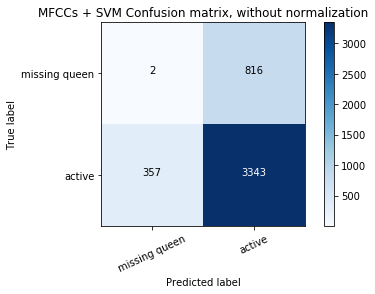

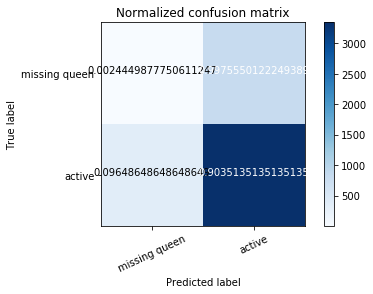

[2020-05-18 17:11:59 RAM65.1% 1.47GB] 
Clasification report MFCCs + SVM:
                precision    recall  f1-score   support

missing_queen       0.01      0.00      0.00       818
       active       0.80      0.90      0.85      3700

     accuracy                           0.74      4518
    macro avg       0.40      0.45      0.43      4518
 weighted avg       0.66      0.74      0.70      4518



In [131]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Test_GroundT, Test_Preds )
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='MFCCs + SVM Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report MFCCs + SVM:\n', classification_report(Test_GroundT, Test_Preds , target_names=target_names))

# Method 2: MFCCs+ CNN Classification 

In [32]:
import keras 
from keras.models import Sequential, Input, Model 
from keras.layers import Dense, Dropout, Flatten, Activation 
from keras.layers import Conv2D , MaxPooling2D
from keras.layers.normalization import BatchNormalization 
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model

###################################################################
# Set early stopping critiria
pat=5 # this is the number of epocks with no improvment after which the training will stop 
early_stopping= EarlyStopping(monitor='val_loss', patience=pat, verbose=1 )
n_folds=10
epochs=50
batch_size=145

In [176]:
y_concat, x_concat, sample_ids_concat= BalanceData_online(Y, X, sample_idss)

[2020-05-18 12:28:49 RAM78.3% 1.68GB] Balancing training data:
[2020-05-18 12:28:49 RAM78.3% 1.68GB] will randomly replicate samples from least represented class


In [80]:
x, y, z= x_concat.shape
#X=x_concat.reshape(x, y*z)
#Y=y_concat
#Y.shape,X.shape
y_concat.shape, x_concat.shape

((17702,), (17702, 20, 44))

In [81]:

X= x_concat.reshape(-1, 20, 44, 1)
Y=y_concat.reshape(-1, 1)
X.shape, Y.shape

((17702, 20, 44, 1), (17702, 1))

In [82]:
# Convert features and corresponding classification labels into numpy arrays

X = np.array(X.tolist())
y = np.array(Y.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 


# split the dataset 
from sklearn.model_selection import train_test_split 
 
x_train= X[4519:]
x_test=X[: 4518]
y_test=yy[:4518]
y_train= yy[4519:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape
#x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.3, random_state = 2020, shuffle=False)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


((13183, 20, 44, 1), (4518, 20, 44, 1), (13183, 2), (4518, 2))

In [180]:
#x_train.shape, x_test.shape, y_train.shape, y_test.shape

((12391, 20, 44, 1), (5311, 20, 44, 1), (12391, 2), (5311, 2))

In [83]:
def deep_model(size):
    # Neural Network Architecture 
    model=Sequential()
    # size= ( 20,44, 1)
   # for i in range(1, num_cnn_layers+1):
         
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=size , padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))
    # we add the dropout to skip the overfitting 
    # model.add(Dropout(0.25))



    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # we add the dropout to skip the overfitting 
    # model.add(Dropout(0.25))

    model.add(Conv2D(16, kernel_size=(3,1), activation='relu', padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))
    #model.add(Dropout(0.25))

    model.add(Conv2D(16, kernel_size=(3,1), activation='relu', padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # we add the dropout to skip the overfitting 
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(32 , activation='relu'))
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    return model

In [84]:
model=deep_model(( 20,44, 1))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 20, 44, 16)        160       
_________________________________________________________________
leaky_re_lu_73 (LeakyReLU)   (None, 20, 44, 16)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 10, 22, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 10, 22, 16)        2320      
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 10, 22, 16)        0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 5, 11, 16)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 5, 11, 16)       

In [85]:
# define the model check point callback -> this will keep saving the model as a physical file 
model_checkpoint= ModelCheckpoint('cnn_bee_1.h5', verbose=1, save_best_only=True )

# define a function to fit the model

def fit_and_evaluate(train_x, val_x, train_y, val_y, EPOCHS=50, BATCH_SIZE=145 ):
    model=None
    model=deep_model(( 20,44, 1))
    results= model.fit(train_x, train_y, epochs=EPOCHS, batch_size= BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.1)
    print("Val Score :", model.evaluate(val_x, val_y))
    return results 
    

In [86]:
# save the model history in a list after fitting so we can plot later 
model_history=[]
for i in range(n_folds):
    print("Training on Fold :", i+1)
    x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.10, random_state = 2020)
    model_history.append(fit_and_evaluate(x_t, x_v, y_t, y_v, epochs, batch_size))
    print("============="*12, end="\n\n\n")

[2020-05-18 16:16:03 RAM66.0% 0.94GB] Training on Fold : 1
Train on 10677 samples, validate on 1187 samples
Epoch 1/50
10677/10677 [==============================] - ETA: 23s - loss: 2.8729 - accuracy: 0.455 - ETA: 14s - loss: 3.0554 - accuracy: 0.544 - ETA: 11s - loss: 2.3802 - accuracy: 0.547 - ETA: 10s - loss: 2.0339 - accuracy: 0.529 - ETA: 9s - loss: 1.8274 - accuracy: 0.536 - ETA: 8s - loss: 1.6496 - accuracy: 0.53 - ETA: 7s - loss: 1.5263 - accuracy: 0.53 - ETA: 7s - loss: 1.4337 - accuracy: 0.53 - ETA: 7s - loss: 1.3556 - accuracy: 0.54 - ETA: 6s - loss: 1.2955 - accuracy: 0.54 - ETA: 6s - loss: 1.2435 - accuracy: 0.54 - ETA: 6s - loss: 1.1991 - accuracy: 0.54 - ETA: 6s - loss: 1.1623 - accuracy: 0.54 - ETA: 5s - loss: 1.1269 - accuracy: 0.55 - ETA: 5s - loss: 1.1019 - accuracy: 0.55 - ETA: 5s - loss: 1.0752 - accuracy: 0.55 - ETA: 5s - loss: 1.0502 - accuracy: 0.55 - ETA: 5s - loss: 1.0290 - accuracy: 0.56 - ETA: 5s - loss: 1.0071 - accuracy: 0.56 - ETA: 5s - loss: 0.9888 - ac

10677/10677 [==============================] - ETA: 5s - loss: 0.0195 - accuracy: 0.99 - ETA: 5s - loss: 0.0348 - accuracy: 0.98 - ETA: 5s - loss: 0.0308 - accuracy: 0.98 - ETA: 5s - loss: 0.0328 - accuracy: 0.98 - ETA: 5s - loss: 0.0329 - accuracy: 0.98 - ETA: 5s - loss: 0.0341 - accuracy: 0.98 - ETA: 5s - loss: 0.0308 - accuracy: 0.98 - ETA: 5s - loss: 0.0297 - accuracy: 0.98 - ETA: 5s - loss: 0.0335 - accuracy: 0.98 - ETA: 5s - loss: 0.0335 - accuracy: 0.98 - ETA: 5s - loss: 0.0396 - accuracy: 0.98 - ETA: 5s - loss: 0.0411 - accuracy: 0.98 - ETA: 5s - loss: 0.0426 - accuracy: 0.98 - ETA: 5s - loss: 0.0560 - accuracy: 0.97 - ETA: 4s - loss: 0.0644 - accuracy: 0.97 - ETA: 4s - loss: 0.0635 - accuracy: 0.97 - ETA: 4s - loss: 0.0658 - accuracy: 0.97 - ETA: 4s - loss: 0.0635 - accuracy: 0.97 - ETA: 4s - loss: 0.0615 - accuracy: 0.97 - ETA: 4s - loss: 0.0624 - accuracy: 0.97 - ETA: 4s - loss: 0.0655 - accuracy: 0.97 - ETA: 4s - loss: 0.0655 - accuracy: 0.97 - ETA: 4s - loss: 0.0695 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0494 - accuracy: 0.98 - ETA: 5s - loss: 0.0442 - accuracy: 0.98 - ETA: 5s - loss: 0.0382 - accuracy: 0.98 - ETA: 5s - loss: 0.0315 - accuracy: 0.99 - ETA: 5s - loss: 0.0308 - accuracy: 0.98 - ETA: 5s - loss: 0.0425 - accuracy: 0.98 - ETA: 5s - loss: 0.0398 - accuracy: 0.98 - ETA: 5s - loss: 0.0435 - accuracy: 0.98 - ETA: 5s - loss: 0.0436 - accuracy: 0.98 - ETA: 5s - loss: 0.0440 - accuracy: 0.98 - ETA: 5s - loss: 0.0443 - accuracy: 0.98 - ETA: 5s - loss: 0.0436 - accuracy: 0.98 - ETA: 4s - loss: 0.0411 - accuracy: 0.98 - ETA: 4s - loss: 0.0404 - accuracy: 0.98 - ETA: 4s - loss: 0.0407 - accuracy: 0.98 - ETA: 4s - loss: 0.0391 - accuracy: 0.98 - ETA: 4s - loss: 0.0385 - accuracy: 0.98 - ETA: 4s - loss: 0.0368 - accuracy: 0.98 - ETA: 4s - loss: 0.0360 - accuracy: 0.98 - ETA: 4s - loss: 0.0353 - accuracy: 0.98 - ETA: 4s - loss: 0.0355 - accuracy: 0.98 - ETA: 4s - loss: 0.0401 - accuracy: 0.98 - ETA: 4s - loss: 0.0504 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0136 - accuracy: 0.99 - ETA: 5s - loss: 0.0118 - accuracy: 0.99 - ETA: 5s - loss: 0.0083 - accuracy: 0.99 - ETA: 5s - loss: 0.0089 - accuracy: 0.99 - ETA: 5s - loss: 0.0103 - accuracy: 0.99 - ETA: 5s - loss: 0.0205 - accuracy: 0.99 - ETA: 5s - loss: 0.0333 - accuracy: 0.98 - ETA: 5s - loss: 0.0475 - accuracy: 0.98 - ETA: 5s - loss: 0.0609 - accuracy: 0.98 - ETA: 5s - loss: 0.0572 - accuracy: 0.98 - ETA: 5s - loss: 0.0575 - accuracy: 0.98 - ETA: 5s - loss: 0.0555 - accuracy: 0.98 - ETA: 4s - loss: 0.0517 - accuracy: 0.98 - ETA: 4s - loss: 0.0482 - accuracy: 0.98 - ETA: 4s - loss: 0.0462 - accuracy: 0.98 - ETA: 4s - loss: 0.0436 - accuracy: 0.98 - ETA: 4s - loss: 0.0430 - accuracy: 0.98 - ETA: 4s - loss: 0.0415 - accuracy: 0.98 - ETA: 4s - loss: 0.0395 - accuracy: 0.98 - ETA: 4s - loss: 0.0400 - accuracy: 0.98 - ETA: 4s - loss: 0.0405 - accuracy: 0.98 - ETA: 4s - loss: 0.0399 - accuracy: 0.98 - ETA: 4s - loss: 0.0430 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0148 - accuracy: 0.99 - ETA: 6s - loss: 0.0098 - accuracy: 0.99 - ETA: 6s - loss: 0.0077 - accuracy: 0.99 - ETA: 5s - loss: 0.0139 - accuracy: 0.99 - ETA: 5s - loss: 0.0189 - accuracy: 0.99 - ETA: 5s - loss: 0.0190 - accuracy: 0.99 - ETA: 5s - loss: 0.0302 - accuracy: 0.98 - ETA: 5s - loss: 0.0327 - accuracy: 0.98 - ETA: 5s - loss: 0.0359 - accuracy: 0.98 - ETA: 5s - loss: 0.0381 - accuracy: 0.98 - ETA: 5s - loss: 0.0396 - accuracy: 0.98 - ETA: 5s - loss: 0.0391 - accuracy: 0.98 - ETA: 5s - loss: 0.0370 - accuracy: 0.98 - ETA: 5s - loss: 0.0393 - accuracy: 0.98 - ETA: 5s - loss: 0.0373 - accuracy: 0.98 - ETA: 4s - loss: 0.0352 - accuracy: 0.98 - ETA: 4s - loss: 0.0341 - accuracy: 0.98 - ETA: 4s - loss: 0.0325 - accuracy: 0.98 - ETA: 4s - loss: 0.0323 - accuracy: 0.98 - ETA: 4s - loss: 0.0324 - accuracy: 0.98 - ETA: 4s - loss: 0.0311 - accuracy: 0.98 - ETA: 4s - loss: 0.0299 - accuracy: 0.98 - ETA: 4s - loss: 0.0301 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0135 - accuracy: 0.99 - ETA: 5s - loss: 0.0085 - accuracy: 0.99 - ETA: 5s - loss: 0.0081 - accuracy: 0.99 - ETA: 5s - loss: 0.0063 - accuracy: 0.99 - ETA: 5s - loss: 0.0130 - accuracy: 0.99 - ETA: 5s - loss: 0.0902 - accuracy: 0.97 - ETA: 5s - loss: 0.0811 - accuracy: 0.97 - ETA: 5s - loss: 0.0717 - accuracy: 0.98 - ETA: 5s - loss: 0.0639 - accuracy: 0.98 - ETA: 5s - loss: 0.0579 - accuracy: 0.98 - ETA: 5s - loss: 0.0560 - accuracy: 0.98 - ETA: 4s - loss: 0.0515 - accuracy: 0.98 - ETA: 4s - loss: 0.0485 - accuracy: 0.98 - ETA: 4s - loss: 0.0454 - accuracy: 0.98 - ETA: 4s - loss: 0.0450 - accuracy: 0.98 - ETA: 4s - loss: 0.0459 - accuracy: 0.98 - ETA: 4s - loss: 0.0435 - accuracy: 0.98 - ETA: 4s - loss: 0.0419 - accuracy: 0.98 - ETA: 4s - loss: 0.0399 - accuracy: 0.98 - ETA: 4s - loss: 0.0383 - accuracy: 0.98 - ETA: 4s - loss: 0.0370 - accuracy: 0.98 - ETA: 4s - loss: 0.0369 - accuracy: 0.99 - ETA: 4s - loss: 0.0405 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0128 - accuracy: 1.00 - ETA: 5s - loss: 0.0090 - accuracy: 1.00 - ETA: 5s - loss: 0.0077 - accuracy: 1.00 - ETA: 5s - loss: 0.0066 - accuracy: 1.00 - ETA: 5s - loss: 0.0067 - accuracy: 1.00 - ETA: 5s - loss: 0.0079 - accuracy: 0.99 - ETA: 5s - loss: 0.0083 - accuracy: 0.99 - ETA: 5s - loss: 0.0085 - accuracy: 0.99 - ETA: 5s - loss: 0.0083 - accuracy: 0.99 - ETA: 5s - loss: 0.0101 - accuracy: 0.99 - ETA: 5s - loss: 0.0097 - accuracy: 0.99 - ETA: 5s - loss: 0.0118 - accuracy: 0.99 - ETA: 5s - loss: 0.0190 - accuracy: 0.99 - ETA: 4s - loss: 0.0186 - accuracy: 0.99 - ETA: 4s - loss: 0.0179 - accuracy: 0.99 - ETA: 4s - loss: 0.0171 - accuracy: 0.99 - ETA: 4s - loss: 0.0171 - accuracy: 0.99 - ETA: 4s - loss: 0.0166 - accuracy: 0.99 - ETA: 4s - loss: 0.0178 - accuracy: 0.99 - ETA: 4s - loss: 0.0173 - accuracy: 0.99 - ETA: 4s - loss: 0.0172 - accuracy: 0.99 - ETA: 4s - loss: 0.0166 - accuracy: 0.99 - ETA: 4s - loss: 0.0164 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0900 - accuracy: 0.97 - ETA: 5s - loss: 0.1255 - accuracy: 0.95 - ETA: 5s - loss: 0.1200 - accuracy: 0.95 - ETA: 5s - loss: 0.1235 - accuracy: 0.95 - ETA: 5s - loss: 0.1224 - accuracy: 0.95 - ETA: 5s - loss: 0.1298 - accuracy: 0.94 - ETA: 5s - loss: 0.1320 - accuracy: 0.94 - ETA: 5s - loss: 0.1474 - accuracy: 0.93 - ETA: 5s - loss: 0.1854 - accuracy: 0.92 - ETA: 5s - loss: 0.1920 - accuracy: 0.91 - ETA: 5s - loss: 0.1986 - accuracy: 0.91 - ETA: 5s - loss: 0.2035 - accuracy: 0.91 - ETA: 4s - loss: 0.2014 - accuracy: 0.91 - ETA: 4s - loss: 0.2000 - accuracy: 0.91 - ETA: 4s - loss: 0.1972 - accuracy: 0.91 - ETA: 4s - loss: 0.1943 - accuracy: 0.91 - ETA: 4s - loss: 0.1922 - accuracy: 0.91 - ETA: 4s - loss: 0.1900 - accuracy: 0.91 - ETA: 4s - loss: 0.1881 - accuracy: 0.92 - ETA: 4s - loss: 0.1845 - accuracy: 0.92 - ETA: 4s - loss: 0.1827 - accuracy: 0.92 - ETA: 4s - loss: 0.1845 - accuracy: 0.92 - ETA: 4s - loss: 0.1907 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.1362 - accuracy: 0.95 - ETA: 5s - loss: 0.1292 - accuracy: 0.96 - ETA: 5s - loss: 0.1085 - accuracy: 0.96 - ETA: 5s - loss: 0.0892 - accuracy: 0.97 - ETA: 5s - loss: 0.0794 - accuracy: 0.97 - ETA: 5s - loss: 0.0774 - accuracy: 0.97 - ETA: 5s - loss: 0.0705 - accuracy: 0.97 - ETA: 5s - loss: 0.0689 - accuracy: 0.97 - ETA: 5s - loss: 0.0813 - accuracy: 0.97 - ETA: 5s - loss: 0.0792 - accuracy: 0.97 - ETA: 5s - loss: 0.0757 - accuracy: 0.97 - ETA: 5s - loss: 0.0758 - accuracy: 0.97 - ETA: 4s - loss: 0.0730 - accuracy: 0.97 - ETA: 4s - loss: 0.0734 - accuracy: 0.97 - ETA: 4s - loss: 0.0703 - accuracy: 0.97 - ETA: 4s - loss: 0.0749 - accuracy: 0.97 - ETA: 4s - loss: 0.1016 - accuracy: 0.96 - ETA: 4s - loss: 0.1103 - accuracy: 0.96 - ETA: 4s - loss: 0.1128 - accuracy: 0.96 - ETA: 4s - loss: 0.1125 - accuracy: 0.96 - ETA: 4s - loss: 0.1084 - accuracy: 0.96 - ETA: 4s - loss: 0.1061 - accuracy: 0.96 - ETA: 4s - loss: 0.1048 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0271 - accuracy: 0.99 - ETA: 6s - loss: 0.0515 - accuracy: 0.98 - ETA: 6s - loss: 0.0451 - accuracy: 0.98 - ETA: 6s - loss: 0.0376 - accuracy: 0.98 - ETA: 5s - loss: 0.0419 - accuracy: 0.98 - ETA: 5s - loss: 0.0409 - accuracy: 0.98 - ETA: 5s - loss: 0.0411 - accuracy: 0.98 - ETA: 5s - loss: 0.0397 - accuracy: 0.98 - ETA: 5s - loss: 0.0380 - accuracy: 0.98 - ETA: 5s - loss: 0.0356 - accuracy: 0.98 - ETA: 5s - loss: 0.0345 - accuracy: 0.98 - ETA: 5s - loss: 0.0362 - accuracy: 0.98 - ETA: 5s - loss: 0.0408 - accuracy: 0.98 - ETA: 5s - loss: 0.0413 - accuracy: 0.98 - ETA: 4s - loss: 0.0428 - accuracy: 0.98 - ETA: 4s - loss: 0.0436 - accuracy: 0.98 - ETA: 4s - loss: 0.0455 - accuracy: 0.98 - ETA: 4s - loss: 0.0447 - accuracy: 0.98 - ETA: 4s - loss: 0.0433 - accuracy: 0.98 - ETA: 4s - loss: 0.0430 - accuracy: 0.98 - ETA: 4s - loss: 0.0425 - accuracy: 0.98 - ETA: 4s - loss: 0.0414 - accuracy: 0.98 - ETA: 4s - loss: 0.0418 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0732 - accuracy: 0.96 - ETA: 5s - loss: 0.0875 - accuracy: 0.96 - ETA: 5s - loss: 0.0776 - accuracy: 0.96 - ETA: 5s - loss: 0.0747 - accuracy: 0.97 - ETA: 5s - loss: 0.0646 - accuracy: 0.97 - ETA: 5s - loss: 0.0556 - accuracy: 0.98 - ETA: 5s - loss: 0.0487 - accuracy: 0.98 - ETA: 5s - loss: 0.0449 - accuracy: 0.98 - ETA: 5s - loss: 0.0424 - accuracy: 0.98 - ETA: 4s - loss: 0.0400 - accuracy: 0.98 - ETA: 4s - loss: 0.0382 - accuracy: 0.98 - ETA: 4s - loss: 0.0356 - accuracy: 0.98 - ETA: 4s - loss: 0.0355 - accuracy: 0.98 - ETA: 4s - loss: 0.0426 - accuracy: 0.98 - ETA: 4s - loss: 0.0440 - accuracy: 0.98 - ETA: 4s - loss: 0.0433 - accuracy: 0.98 - ETA: 4s - loss: 0.0428 - accuracy: 0.98 - ETA: 4s - loss: 0.0416 - accuracy: 0.98 - ETA: 4s - loss: 0.0414 - accuracy: 0.98 - ETA: 4s - loss: 0.0402 - accuracy: 0.98 - ETA: 4s - loss: 0.0395 - accuracy: 0.98 - ETA: 4s - loss: 0.0390 - accuracy: 0.98 - ETA: 3s - loss: 0.0439 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0609 - accuracy: 0.97 - ETA: 5s - loss: 0.0575 - accuracy: 0.98 - ETA: 5s - loss: 0.0442 - accuracy: 0.98 - ETA: 5s - loss: 0.0369 - accuracy: 0.98 - ETA: 5s - loss: 0.0304 - accuracy: 0.98 - ETA: 5s - loss: 0.0288 - accuracy: 0.98 - ETA: 5s - loss: 0.0277 - accuracy: 0.98 - ETA: 5s - loss: 0.0258 - accuracy: 0.98 - ETA: 5s - loss: 0.0260 - accuracy: 0.98 - ETA: 5s - loss: 0.0285 - accuracy: 0.98 - ETA: 4s - loss: 0.0440 - accuracy: 0.98 - ETA: 4s - loss: 0.0512 - accuracy: 0.98 - ETA: 4s - loss: 0.0513 - accuracy: 0.98 - ETA: 4s - loss: 0.0494 - accuracy: 0.98 - ETA: 4s - loss: 0.0491 - accuracy: 0.98 - ETA: 4s - loss: 0.0495 - accuracy: 0.98 - ETA: 4s - loss: 0.0476 - accuracy: 0.98 - ETA: 4s - loss: 0.0463 - accuracy: 0.98 - ETA: 4s - loss: 0.0476 - accuracy: 0.98 - ETA: 4s - loss: 0.0462 - accuracy: 0.98 - ETA: 4s - loss: 0.0449 - accuracy: 0.98 - ETA: 4s - loss: 0.0442 - accuracy: 0.98 - ETA: 3s - loss: 0.0426 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0022 - accuracy: 1.00 - ETA: 5s - loss: 0.0098 - accuracy: 0.99 - ETA: 5s - loss: 0.0189 - accuracy: 0.99 - ETA: 5s - loss: 0.0473 - accuracy: 0.98 - ETA: 5s - loss: 0.0411 - accuracy: 0.98 - ETA: 5s - loss: 0.0364 - accuracy: 0.98 - ETA: 5s - loss: 0.0434 - accuracy: 0.98 - ETA: 5s - loss: 0.0458 - accuracy: 0.98 - ETA: 4s - loss: 0.0437 - accuracy: 0.98 - ETA: 4s - loss: 0.0408 - accuracy: 0.98 - ETA: 4s - loss: 0.0375 - accuracy: 0.98 - ETA: 4s - loss: 0.0353 - accuracy: 0.98 - ETA: 4s - loss: 0.0345 - accuracy: 0.98 - ETA: 4s - loss: 0.0321 - accuracy: 0.98 - ETA: 4s - loss: 0.0312 - accuracy: 0.98 - ETA: 4s - loss: 0.0303 - accuracy: 0.98 - ETA: 4s - loss: 0.0292 - accuracy: 0.98 - ETA: 4s - loss: 0.0283 - accuracy: 0.98 - ETA: 4s - loss: 0.0285 - accuracy: 0.98 - ETA: 4s - loss: 0.0291 - accuracy: 0.98 - ETA: 4s - loss: 0.0291 - accuracy: 0.98 - ETA: 3s - loss: 0.0286 - accuracy: 0.98 - ETA: 3s - loss: 0.0283 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.0952 - accuracy: 0.97 - ETA: 5s - loss: 0.0612 - accuracy: 0.98 - ETA: 5s - loss: 0.0431 - accuracy: 0.99 - ETA: 5s - loss: 0.0340 - accuracy: 0.99 - ETA: 5s - loss: 0.0287 - accuracy: 0.99 - ETA: 5s - loss: 0.0241 - accuracy: 0.99 - ETA: 4s - loss: 0.0237 - accuracy: 0.99 - ETA: 4s - loss: 0.0218 - accuracy: 0.99 - ETA: 4s - loss: 0.0228 - accuracy: 0.99 - ETA: 4s - loss: 0.0259 - accuracy: 0.99 - ETA: 4s - loss: 0.0266 - accuracy: 0.99 - ETA: 4s - loss: 0.0291 - accuracy: 0.99 - ETA: 4s - loss: 0.0292 - accuracy: 0.99 - ETA: 4s - loss: 0.0293 - accuracy: 0.99 - ETA: 4s - loss: 0.0282 - accuracy: 0.99 - ETA: 4s - loss: 0.0276 - accuracy: 0.99 - ETA: 4s - loss: 0.0267 - accuracy: 0.99 - ETA: 4s - loss: 0.0259 - accuracy: 0.99 - ETA: 4s - loss: 0.0257 - accuracy: 0.99 - ETA: 4s - loss: 0.0246 - accuracy: 0.99 - ETA: 4s - loss: 0.0237 - accuracy: 0.99 - ETA: 3s - loss: 0.0236 - accuracy: 0.99 - ETA: 3s - loss: 0.0237 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.0021 - accuracy: 1.00 - ETA: 5s - loss: 0.0174 - accuracy: 0.98 - ETA: 5s - loss: 0.0503 - accuracy: 0.98 - ETA: 5s - loss: 0.0541 - accuracy: 0.97 - ETA: 5s - loss: 0.0465 - accuracy: 0.98 - ETA: 5s - loss: 0.0409 - accuracy: 0.98 - ETA: 5s - loss: 0.0365 - accuracy: 0.98 - ETA: 5s - loss: 0.0330 - accuracy: 0.98 - ETA: 5s - loss: 0.0316 - accuracy: 0.98 - ETA: 4s - loss: 0.0286 - accuracy: 0.98 - ETA: 4s - loss: 0.0270 - accuracy: 0.99 - ETA: 4s - loss: 0.0266 - accuracy: 0.99 - ETA: 4s - loss: 0.0247 - accuracy: 0.99 - ETA: 4s - loss: 0.0233 - accuracy: 0.99 - ETA: 4s - loss: 0.0218 - accuracy: 0.99 - ETA: 4s - loss: 0.0213 - accuracy: 0.99 - ETA: 4s - loss: 0.0203 - accuracy: 0.99 - ETA: 4s - loss: 0.0192 - accuracy: 0.99 - ETA: 4s - loss: 0.0183 - accuracy: 0.99 - ETA: 4s - loss: 0.0180 - accuracy: 0.99 - ETA: 4s - loss: 0.0174 - accuracy: 0.99 - ETA: 4s - loss: 0.0168 - accuracy: 0.99 - ETA: 4s - loss: 0.0162 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0241 - accuracy: 0.99 - ETA: 5s - loss: 0.0141 - accuracy: 0.99 - ETA: 5s - loss: 0.0102 - accuracy: 0.99 - ETA: 5s - loss: 0.0230 - accuracy: 0.99 - ETA: 5s - loss: 0.0195 - accuracy: 0.99 - ETA: 5s - loss: 0.0181 - accuracy: 0.99 - ETA: 5s - loss: 0.0218 - accuracy: 0.99 - ETA: 5s - loss: 0.0233 - accuracy: 0.99 - ETA: 5s - loss: 0.0214 - accuracy: 0.99 - ETA: 5s - loss: 0.0204 - accuracy: 0.99 - ETA: 4s - loss: 0.0188 - accuracy: 0.99 - ETA: 4s - loss: 0.0185 - accuracy: 0.99 - ETA: 4s - loss: 0.0183 - accuracy: 0.99 - ETA: 4s - loss: 0.0170 - accuracy: 0.99 - ETA: 4s - loss: 0.0167 - accuracy: 0.99 - ETA: 4s - loss: 0.0162 - accuracy: 0.99 - ETA: 4s - loss: 0.0154 - accuracy: 0.99 - ETA: 4s - loss: 0.0193 - accuracy: 0.99 - ETA: 4s - loss: 0.0210 - accuracy: 0.99 - ETA: 4s - loss: 0.0206 - accuracy: 0.99 - ETA: 4s - loss: 0.0215 - accuracy: 0.99 - ETA: 4s - loss: 0.0213 - accuracy: 0.99 - ETA: 3s - loss: 0.0275 - accu

10677/10677 [==============================] - ETA: 25s - loss: 1.8623 - accuracy: 0.441 - ETA: 15s - loss: 1.8800 - accuracy: 0.513 - ETA: 12s - loss: 1.4933 - accuracy: 0.542 - ETA: 10s - loss: 1.2951 - accuracy: 0.562 - ETA: 9s - loss: 1.1890 - accuracy: 0.554 - ETA: 8s - loss: 1.1086 - accuracy: 0.55 - ETA: 7s - loss: 1.0463 - accuracy: 0.56 - ETA: 7s - loss: 1.0018 - accuracy: 0.56 - ETA: 7s - loss: 0.9655 - accuracy: 0.57 - ETA: 6s - loss: 0.9414 - accuracy: 0.57 - ETA: 6s - loss: 0.9192 - accuracy: 0.57 - ETA: 6s - loss: 0.8977 - accuracy: 0.58 - ETA: 6s - loss: 0.8846 - accuracy: 0.58 - ETA: 6s - loss: 0.8732 - accuracy: 0.57 - ETA: 5s - loss: 0.8618 - accuracy: 0.57 - ETA: 5s - loss: 0.8503 - accuracy: 0.57 - ETA: 5s - loss: 0.8382 - accuracy: 0.58 - ETA: 5s - loss: 0.8307 - accuracy: 0.58 - ETA: 5s - loss: 0.8206 - accuracy: 0.58 - ETA: 5s - loss: 0.8103 - accuracy: 0.58 - ETA: 5s - loss: 0.8032 - accuracy: 0.58 - ETA: 4s - loss: 0.7977 - accuracy: 0.58 - ETA: 4s - loss: 0.79

10677/10677 [==============================] - ETA: 5s - loss: 0.1183 - accuracy: 0.94 - ETA: 5s - loss: 0.1150 - accuracy: 0.94 - ETA: 5s - loss: 0.0988 - accuracy: 0.95 - ETA: 5s - loss: 0.0922 - accuracy: 0.95 - ETA: 5s - loss: 0.0835 - accuracy: 0.96 - ETA: 5s - loss: 0.0784 - accuracy: 0.96 - ETA: 5s - loss: 0.0734 - accuracy: 0.96 - ETA: 5s - loss: 0.0748 - accuracy: 0.96 - ETA: 5s - loss: 0.0724 - accuracy: 0.96 - ETA: 5s - loss: 0.0697 - accuracy: 0.96 - ETA: 4s - loss: 0.0717 - accuracy: 0.96 - ETA: 4s - loss: 0.0800 - accuracy: 0.96 - ETA: 4s - loss: 0.0770 - accuracy: 0.96 - ETA: 4s - loss: 0.0804 - accuracy: 0.96 - ETA: 4s - loss: 0.0841 - accuracy: 0.96 - ETA: 4s - loss: 0.0861 - accuracy: 0.96 - ETA: 4s - loss: 0.0839 - accuracy: 0.96 - ETA: 4s - loss: 0.0815 - accuracy: 0.96 - ETA: 4s - loss: 0.0815 - accuracy: 0.96 - ETA: 4s - loss: 0.0803 - accuracy: 0.96 - ETA: 4s - loss: 0.0787 - accuracy: 0.96 - ETA: 4s - loss: 0.0776 - accuracy: 0.96 - ETA: 3s - loss: 0.0755 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0301 - accuracy: 0.98 - ETA: 6s - loss: 0.0403 - accuracy: 0.97 - ETA: 6s - loss: 0.0459 - accuracy: 0.97 - ETA: 6s - loss: 0.0391 - accuracy: 0.98 - ETA: 6s - loss: 0.0346 - accuracy: 0.98 - ETA: 6s - loss: 0.0356 - accuracy: 0.98 - ETA: 5s - loss: 0.0447 - accuracy: 0.98 - ETA: 5s - loss: 0.0486 - accuracy: 0.97 - ETA: 5s - loss: 0.0567 - accuracy: 0.97 - ETA: 5s - loss: 0.0537 - accuracy: 0.97 - ETA: 5s - loss: 0.0564 - accuracy: 0.97 - ETA: 5s - loss: 0.0533 - accuracy: 0.97 - ETA: 5s - loss: 0.0529 - accuracy: 0.97 - ETA: 5s - loss: 0.0549 - accuracy: 0.97 - ETA: 4s - loss: 0.0581 - accuracy: 0.97 - ETA: 4s - loss: 0.0576 - accuracy: 0.97 - ETA: 4s - loss: 0.0556 - accuracy: 0.97 - ETA: 4s - loss: 0.0545 - accuracy: 0.97 - ETA: 4s - loss: 0.0519 - accuracy: 0.97 - ETA: 4s - loss: 0.0510 - accuracy: 0.97 - ETA: 4s - loss: 0.0503 - accuracy: 0.98 - ETA: 4s - loss: 0.0502 - accuracy: 0.98 - ETA: 4s - loss: 0.0504 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0638 - accuracy: 0.97 - ETA: 5s - loss: 0.0587 - accuracy: 0.97 - ETA: 5s - loss: 0.0503 - accuracy: 0.98 - ETA: 5s - loss: 0.0478 - accuracy: 0.98 - ETA: 5s - loss: 0.0433 - accuracy: 0.98 - ETA: 5s - loss: 0.0379 - accuracy: 0.98 - ETA: 5s - loss: 0.0359 - accuracy: 0.98 - ETA: 5s - loss: 0.0347 - accuracy: 0.98 - ETA: 5s - loss: 0.0330 - accuracy: 0.98 - ETA: 5s - loss: 0.0315 - accuracy: 0.98 - ETA: 4s - loss: 0.0293 - accuracy: 0.98 - ETA: 4s - loss: 0.0289 - accuracy: 0.98 - ETA: 4s - loss: 0.0273 - accuracy: 0.98 - ETA: 4s - loss: 0.0276 - accuracy: 0.98 - ETA: 4s - loss: 0.0309 - accuracy: 0.98 - ETA: 4s - loss: 0.0307 - accuracy: 0.98 - ETA: 4s - loss: 0.0339 - accuracy: 0.98 - ETA: 4s - loss: 0.0329 - accuracy: 0.98 - ETA: 4s - loss: 0.0329 - accuracy: 0.98 - ETA: 4s - loss: 0.0338 - accuracy: 0.98 - ETA: 4s - loss: 0.0339 - accuracy: 0.98 - ETA: 4s - loss: 0.0335 - accuracy: 0.98 - ETA: 4s - loss: 0.0342 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0517 - accuracy: 0.97 - ETA: 5s - loss: 0.0302 - accuracy: 0.98 - ETA: 5s - loss: 0.0338 - accuracy: 0.98 - ETA: 5s - loss: 0.0315 - accuracy: 0.98 - ETA: 5s - loss: 0.0355 - accuracy: 0.98 - ETA: 5s - loss: 0.0365 - accuracy: 0.98 - ETA: 5s - loss: 0.0325 - accuracy: 0.98 - ETA: 5s - loss: 0.0300 - accuracy: 0.98 - ETA: 5s - loss: 0.0284 - accuracy: 0.98 - ETA: 4s - loss: 0.0296 - accuracy: 0.98 - ETA: 5s - loss: 0.0296 - accuracy: 0.98 - ETA: 4s - loss: 0.0275 - accuracy: 0.98 - ETA: 4s - loss: 0.0257 - accuracy: 0.98 - ETA: 4s - loss: 0.0251 - accuracy: 0.99 - ETA: 4s - loss: 0.0243 - accuracy: 0.99 - ETA: 4s - loss: 0.0250 - accuracy: 0.98 - ETA: 4s - loss: 0.0254 - accuracy: 0.98 - ETA: 4s - loss: 0.0247 - accuracy: 0.99 - ETA: 4s - loss: 0.0259 - accuracy: 0.98 - ETA: 4s - loss: 0.0259 - accuracy: 0.98 - ETA: 4s - loss: 0.0252 - accuracy: 0.99 - ETA: 4s - loss: 0.0257 - accuracy: 0.98 - ETA: 4s - loss: 0.0289 - accu

10677/10677 [==============================] - ETA: 22s - loss: 1.1332 - accuracy: 0.503 - ETA: 13s - loss: 1.0966 - accuracy: 0.496 - ETA: 10s - loss: 1.6210 - accuracy: 0.514 - ETA: 9s - loss: 1.3856 - accuracy: 0.537 - ETA: 8s - loss: 1.2504 - accuracy: 0.55 - ETA: 7s - loss: 1.1588 - accuracy: 0.55 - ETA: 7s - loss: 1.0886 - accuracy: 0.57 - ETA: 7s - loss: 1.0375 - accuracy: 0.57 - ETA: 6s - loss: 0.9925 - accuracy: 0.58 - ETA: 6s - loss: 0.9572 - accuracy: 0.59 - ETA: 6s - loss: 0.9256 - accuracy: 0.60 - ETA: 6s - loss: 0.9001 - accuracy: 0.60 - ETA: 5s - loss: 0.8792 - accuracy: 0.61 - ETA: 5s - loss: 0.8597 - accuracy: 0.61 - ETA: 5s - loss: 0.8413 - accuracy: 0.62 - ETA: 5s - loss: 0.8418 - accuracy: 0.62 - ETA: 5s - loss: 0.8338 - accuracy: 0.61 - ETA: 5s - loss: 0.8241 - accuracy: 0.61 - ETA: 4s - loss: 0.8112 - accuracy: 0.62 - ETA: 4s - loss: 0.7964 - accuracy: 0.63 - ETA: 4s - loss: 0.7852 - accuracy: 0.63 - ETA: 4s - loss: 0.7739 - accuracy: 0.64 - ETA: 4s - loss: 0.7660

10677/10677 [==============================] - ETA: 5s - loss: 0.1347 - accuracy: 0.95 - ETA: 5s - loss: 0.1001 - accuracy: 0.96 - ETA: 5s - loss: 0.1073 - accuracy: 0.97 - ETA: 5s - loss: 0.1032 - accuracy: 0.96 - ETA: 5s - loss: 0.1049 - accuracy: 0.96 - ETA: 5s - loss: 0.0996 - accuracy: 0.96 - ETA: 5s - loss: 0.0926 - accuracy: 0.96 - ETA: 4s - loss: 0.0856 - accuracy: 0.96 - ETA: 4s - loss: 0.0828 - accuracy: 0.96 - ETA: 4s - loss: 0.0840 - accuracy: 0.96 - ETA: 4s - loss: 0.0811 - accuracy: 0.96 - ETA: 4s - loss: 0.0813 - accuracy: 0.96 - ETA: 4s - loss: 0.0795 - accuracy: 0.96 - ETA: 4s - loss: 0.0771 - accuracy: 0.96 - ETA: 4s - loss: 0.0792 - accuracy: 0.96 - ETA: 4s - loss: 0.0770 - accuracy: 0.97 - ETA: 4s - loss: 0.0748 - accuracy: 0.97 - ETA: 4s - loss: 0.0737 - accuracy: 0.97 - ETA: 4s - loss: 0.0777 - accuracy: 0.96 - ETA: 4s - loss: 0.0855 - accuracy: 0.96 - ETA: 4s - loss: 0.0873 - accuracy: 0.96 - ETA: 3s - loss: 0.0868 - accuracy: 0.96 - ETA: 3s - loss: 0.0879 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0407 - accuracy: 0.98 - ETA: 6s - loss: 0.0663 - accuracy: 0.97 - ETA: 5s - loss: 0.0863 - accuracy: 0.96 - ETA: 5s - loss: 0.0948 - accuracy: 0.96 - ETA: 5s - loss: 0.0790 - accuracy: 0.97 - ETA: 5s - loss: 0.0708 - accuracy: 0.97 - ETA: 5s - loss: 0.0650 - accuracy: 0.97 - ETA: 5s - loss: 0.0602 - accuracy: 0.97 - ETA: 5s - loss: 0.0548 - accuracy: 0.98 - ETA: 4s - loss: 0.0511 - accuracy: 0.98 - ETA: 4s - loss: 0.0481 - accuracy: 0.98 - ETA: 4s - loss: 0.0462 - accuracy: 0.98 - ETA: 4s - loss: 0.0451 - accuracy: 0.98 - ETA: 4s - loss: 0.0431 - accuracy: 0.98 - ETA: 4s - loss: 0.0414 - accuracy: 0.98 - ETA: 4s - loss: 0.0392 - accuracy: 0.98 - ETA: 4s - loss: 0.0397 - accuracy: 0.98 - ETA: 4s - loss: 0.0512 - accuracy: 0.98 - ETA: 4s - loss: 0.0735 - accuracy: 0.97 - ETA: 4s - loss: 0.0771 - accuracy: 0.97 - ETA: 4s - loss: 0.0754 - accuracy: 0.97 - ETA: 4s - loss: 0.0743 - accuracy: 0.97 - ETA: 3s - loss: 0.0742 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0114 - accuracy: 1.00 - ETA: 5s - loss: 0.0209 - accuracy: 0.99 - ETA: 5s - loss: 0.0302 - accuracy: 0.99 - ETA: 5s - loss: 0.0284 - accuracy: 0.99 - ETA: 5s - loss: 0.0316 - accuracy: 0.98 - ETA: 5s - loss: 0.0311 - accuracy: 0.98 - ETA: 5s - loss: 0.0336 - accuracy: 0.99 - ETA: 5s - loss: 0.0421 - accuracy: 0.98 - ETA: 5s - loss: 0.0422 - accuracy: 0.98 - ETA: 5s - loss: 0.0389 - accuracy: 0.98 - ETA: 5s - loss: 0.0360 - accuracy: 0.98 - ETA: 4s - loss: 0.0349 - accuracy: 0.98 - ETA: 4s - loss: 0.0337 - accuracy: 0.98 - ETA: 4s - loss: 0.0320 - accuracy: 0.99 - ETA: 4s - loss: 0.0306 - accuracy: 0.99 - ETA: 4s - loss: 0.0307 - accuracy: 0.99 - ETA: 4s - loss: 0.0302 - accuracy: 0.98 - ETA: 4s - loss: 0.0289 - accuracy: 0.99 - ETA: 4s - loss: 0.0290 - accuracy: 0.99 - ETA: 4s - loss: 0.0280 - accuracy: 0.99 - ETA: 4s - loss: 0.0271 - accuracy: 0.99 - ETA: 4s - loss: 0.0265 - accuracy: 0.99 - ETA: 4s - loss: 0.0261 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0197 - accuracy: 0.99 - ETA: 5s - loss: 0.0277 - accuracy: 0.98 - ETA: 5s - loss: 0.0317 - accuracy: 0.99 - ETA: 5s - loss: 0.0253 - accuracy: 0.99 - ETA: 5s - loss: 0.0230 - accuracy: 0.99 - ETA: 5s - loss: 0.0204 - accuracy: 0.99 - ETA: 5s - loss: 0.0212 - accuracy: 0.99 - ETA: 5s - loss: 0.0402 - accuracy: 0.98 - ETA: 5s - loss: 0.0582 - accuracy: 0.98 - ETA: 5s - loss: 0.0539 - accuracy: 0.98 - ETA: 4s - loss: 0.0497 - accuracy: 0.98 - ETA: 4s - loss: 0.0459 - accuracy: 0.98 - ETA: 4s - loss: 0.0435 - accuracy: 0.98 - ETA: 4s - loss: 0.0414 - accuracy: 0.98 - ETA: 4s - loss: 0.0404 - accuracy: 0.98 - ETA: 4s - loss: 0.0380 - accuracy: 0.98 - ETA: 4s - loss: 0.0360 - accuracy: 0.98 - ETA: 4s - loss: 0.0349 - accuracy: 0.98 - ETA: 4s - loss: 0.0363 - accuracy: 0.98 - ETA: 4s - loss: 0.0356 - accuracy: 0.98 - ETA: 4s - loss: 0.0341 - accuracy: 0.98 - ETA: 4s - loss: 0.0336 - accuracy: 0.99 - ETA: 4s - loss: 0.0327 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0105 - accuracy: 0.99 - ETA: 5s - loss: 0.0128 - accuracy: 0.98 - ETA: 5s - loss: 0.0410 - accuracy: 0.97 - ETA: 5s - loss: 0.0918 - accuracy: 0.97 - ETA: 5s - loss: 0.0828 - accuracy: 0.97 - ETA: 5s - loss: 0.0712 - accuracy: 0.97 - ETA: 5s - loss: 0.0630 - accuracy: 0.98 - ETA: 5s - loss: 0.0571 - accuracy: 0.98 - ETA: 5s - loss: 0.0522 - accuracy: 0.98 - ETA: 5s - loss: 0.0486 - accuracy: 0.98 - ETA: 5s - loss: 0.0447 - accuracy: 0.98 - ETA: 5s - loss: 0.0410 - accuracy: 0.98 - ETA: 5s - loss: 0.0382 - accuracy: 0.98 - ETA: 5s - loss: 0.0359 - accuracy: 0.98 - ETA: 5s - loss: 0.0336 - accuracy: 0.98 - ETA: 5s - loss: 0.0317 - accuracy: 0.98 - ETA: 5s - loss: 0.0299 - accuracy: 0.99 - ETA: 4s - loss: 0.0291 - accuracy: 0.99 - ETA: 4s - loss: 0.0311 - accuracy: 0.98 - ETA: 4s - loss: 0.0361 - accuracy: 0.98 - ETA: 4s - loss: 0.0360 - accuracy: 0.98 - ETA: 4s - loss: 0.0356 - accuracy: 0.98 - ETA: 4s - loss: 0.0344 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0174 - accuracy: 0.99 - ETA: 5s - loss: 0.0156 - accuracy: 0.99 - ETA: 5s - loss: 0.0107 - accuracy: 0.99 - ETA: 5s - loss: 0.0121 - accuracy: 0.99 - ETA: 5s - loss: 0.0107 - accuracy: 0.99 - ETA: 5s - loss: 0.0140 - accuracy: 0.99 - ETA: 5s - loss: 0.0123 - accuracy: 0.99 - ETA: 5s - loss: 0.0155 - accuracy: 0.99 - ETA: 5s - loss: 0.0220 - accuracy: 0.98 - ETA: 5s - loss: 0.0418 - accuracy: 0.98 - ETA: 5s - loss: 0.0462 - accuracy: 0.98 - ETA: 5s - loss: 0.0447 - accuracy: 0.98 - ETA: 5s - loss: 0.0428 - accuracy: 0.98 - ETA: 4s - loss: 0.0435 - accuracy: 0.98 - ETA: 4s - loss: 0.0411 - accuracy: 0.98 - ETA: 4s - loss: 0.0390 - accuracy: 0.98 - ETA: 4s - loss: 0.0370 - accuracy: 0.98 - ETA: 4s - loss: 0.0355 - accuracy: 0.98 - ETA: 4s - loss: 0.0356 - accuracy: 0.98 - ETA: 4s - loss: 0.0362 - accuracy: 0.98 - ETA: 4s - loss: 0.0359 - accuracy: 0.98 - ETA: 4s - loss: 0.0343 - accuracy: 0.98 - ETA: 4s - loss: 0.0330 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.1679 - accuracy: 0.95 - ETA: 5s - loss: 0.1745 - accuracy: 0.92 - ETA: 5s - loss: 0.1704 - accuracy: 0.92 - ETA: 5s - loss: 0.1605 - accuracy: 0.93 - ETA: 5s - loss: 0.1586 - accuracy: 0.93 - ETA: 5s - loss: 0.1640 - accuracy: 0.92 - ETA: 5s - loss: 0.1575 - accuracy: 0.92 - ETA: 5s - loss: 0.1499 - accuracy: 0.93 - ETA: 5s - loss: 0.1560 - accuracy: 0.93 - ETA: 5s - loss: 0.1703 - accuracy: 0.92 - ETA: 5s - loss: 0.1683 - accuracy: 0.92 - ETA: 5s - loss: 0.1682 - accuracy: 0.92 - ETA: 4s - loss: 0.1613 - accuracy: 0.92 - ETA: 4s - loss: 0.1563 - accuracy: 0.92 - ETA: 4s - loss: 0.1509 - accuracy: 0.93 - ETA: 4s - loss: 0.1509 - accuracy: 0.93 - ETA: 4s - loss: 0.1507 - accuracy: 0.93 - ETA: 4s - loss: 0.1482 - accuracy: 0.93 - ETA: 4s - loss: 0.1462 - accuracy: 0.93 - ETA: 4s - loss: 0.1483 - accuracy: 0.93 - ETA: 4s - loss: 0.1501 - accuracy: 0.93 - ETA: 4s - loss: 0.1512 - accuracy: 0.93 - ETA: 4s - loss: 0.1511 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0322 - accuracy: 0.98 - ETA: 5s - loss: 0.0564 - accuracy: 0.97 - ETA: 5s - loss: 0.1247 - accuracy: 0.94 - ETA: 5s - loss: 0.1359 - accuracy: 0.95 - ETA: 5s - loss: 0.1444 - accuracy: 0.94 - ETA: 5s - loss: 0.1282 - accuracy: 0.95 - ETA: 5s - loss: 0.1144 - accuracy: 0.95 - ETA: 5s - loss: 0.1038 - accuracy: 0.96 - ETA: 5s - loss: 0.0986 - accuracy: 0.96 - ETA: 4s - loss: 0.0949 - accuracy: 0.96 - ETA: 4s - loss: 0.0916 - accuracy: 0.96 - ETA: 4s - loss: 0.0861 - accuracy: 0.96 - ETA: 4s - loss: 0.0832 - accuracy: 0.96 - ETA: 4s - loss: 0.0848 - accuracy: 0.96 - ETA: 4s - loss: 0.0826 - accuracy: 0.96 - ETA: 4s - loss: 0.0839 - accuracy: 0.96 - ETA: 4s - loss: 0.0817 - accuracy: 0.96 - ETA: 4s - loss: 0.0799 - accuracy: 0.96 - ETA: 4s - loss: 0.0765 - accuracy: 0.97 - ETA: 4s - loss: 0.0762 - accuracy: 0.97 - ETA: 4s - loss: 0.0753 - accuracy: 0.97 - ETA: 4s - loss: 0.0732 - accuracy: 0.97 - ETA: 3s - loss: 0.0739 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0439 - accuracy: 0.98 - ETA: 5s - loss: 0.0519 - accuracy: 0.98 - ETA: 5s - loss: 0.0505 - accuracy: 0.98 - ETA: 5s - loss: 0.0488 - accuracy: 0.98 - ETA: 5s - loss: 0.0416 - accuracy: 0.98 - ETA: 5s - loss: 0.0414 - accuracy: 0.98 - ETA: 5s - loss: 0.0391 - accuracy: 0.98 - ETA: 4s - loss: 0.0357 - accuracy: 0.98 - ETA: 4s - loss: 0.0373 - accuracy: 0.98 - ETA: 4s - loss: 0.0341 - accuracy: 0.98 - ETA: 4s - loss: 0.0318 - accuracy: 0.98 - ETA: 4s - loss: 0.0308 - accuracy: 0.98 - ETA: 4s - loss: 0.0337 - accuracy: 0.98 - ETA: 4s - loss: 0.0334 - accuracy: 0.98 - ETA: 4s - loss: 0.0336 - accuracy: 0.98 - ETA: 4s - loss: 0.0339 - accuracy: 0.98 - ETA: 4s - loss: 0.0325 - accuracy: 0.98 - ETA: 4s - loss: 0.0331 - accuracy: 0.99 - ETA: 4s - loss: 0.0322 - accuracy: 0.99 - ETA: 4s - loss: 0.0310 - accuracy: 0.99 - ETA: 3s - loss: 0.0299 - accuracy: 0.99 - ETA: 3s - loss: 0.0288 - accuracy: 0.99 - ETA: 3s - loss: 0.0284 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0926 - accuracy: 0.95 - ETA: 7s - loss: 0.0876 - accuracy: 0.96 - ETA: 7s - loss: 0.0772 - accuracy: 0.96 - ETA: 6s - loss: 0.0918 - accuracy: 0.96 - ETA: 6s - loss: 0.0780 - accuracy: 0.97 - ETA: 6s - loss: 0.0697 - accuracy: 0.97 - ETA: 6s - loss: 0.0612 - accuracy: 0.98 - ETA: 5s - loss: 0.0553 - accuracy: 0.98 - ETA: 5s - loss: 0.0495 - accuracy: 0.98 - ETA: 5s - loss: 0.0478 - accuracy: 0.98 - ETA: 5s - loss: 0.0444 - accuracy: 0.98 - ETA: 5s - loss: 0.0411 - accuracy: 0.98 - ETA: 5s - loss: 0.0385 - accuracy: 0.98 - ETA: 5s - loss: 0.0368 - accuracy: 0.98 - ETA: 5s - loss: 0.0351 - accuracy: 0.98 - ETA: 5s - loss: 0.0362 - accuracy: 0.98 - ETA: 4s - loss: 0.0359 - accuracy: 0.98 - ETA: 4s - loss: 0.0352 - accuracy: 0.98 - ETA: 4s - loss: 0.0344 - accuracy: 0.98 - ETA: 4s - loss: 0.0330 - accuracy: 0.98 - ETA: 4s - loss: 0.0318 - accuracy: 0.98 - ETA: 4s - loss: 0.0307 - accuracy: 0.99 - ETA: 4s - loss: 0.0306 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.1672 - accuracy: 0.93 - ETA: 6s - loss: 0.1714 - accuracy: 0.93 - ETA: 5s - loss: 0.2193 - accuracy: 0.91 - ETA: 5s - loss: 0.2191 - accuracy: 0.91 - ETA: 5s - loss: 0.2126 - accuracy: 0.91 - ETA: 5s - loss: 0.2139 - accuracy: 0.91 - ETA: 5s - loss: 0.2113 - accuracy: 0.91 - ETA: 5s - loss: 0.2064 - accuracy: 0.91 - ETA: 5s - loss: 0.2052 - accuracy: 0.92 - ETA: 5s - loss: 0.2066 - accuracy: 0.91 - ETA: 4s - loss: 0.2092 - accuracy: 0.91 - ETA: 4s - loss: 0.2065 - accuracy: 0.91 - ETA: 4s - loss: 0.2054 - accuracy: 0.91 - ETA: 4s - loss: 0.2065 - accuracy: 0.91 - ETA: 4s - loss: 0.2116 - accuracy: 0.91 - ETA: 4s - loss: 0.2228 - accuracy: 0.90 - ETA: 4s - loss: 0.2354 - accuracy: 0.90 - ETA: 4s - loss: 0.2328 - accuracy: 0.90 - ETA: 4s - loss: 0.2286 - accuracy: 0.90 - ETA: 4s - loss: 0.2278 - accuracy: 0.90 - ETA: 4s - loss: 0.2242 - accuracy: 0.90 - ETA: 4s - loss: 0.2212 - accuracy: 0.90 - ETA: 4s - loss: 0.2169 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0562 - accuracy: 0.97 - ETA: 5s - loss: 0.0606 - accuracy: 0.97 - ETA: 5s - loss: 0.0764 - accuracy: 0.96 - ETA: 5s - loss: 0.0733 - accuracy: 0.96 - ETA: 5s - loss: 0.0758 - accuracy: 0.96 - ETA: 5s - loss: 0.0720 - accuracy: 0.96 - ETA: 5s - loss: 0.0671 - accuracy: 0.97 - ETA: 5s - loss: 0.0617 - accuracy: 0.97 - ETA: 5s - loss: 0.0596 - accuracy: 0.97 - ETA: 5s - loss: 0.0696 - accuracy: 0.97 - ETA: 5s - loss: 0.0785 - accuracy: 0.96 - ETA: 5s - loss: 0.0879 - accuracy: 0.96 - ETA: 5s - loss: 0.0876 - accuracy: 0.96 - ETA: 5s - loss: 0.0888 - accuracy: 0.96 - ETA: 5s - loss: 0.0847 - accuracy: 0.96 - ETA: 4s - loss: 0.0858 - accuracy: 0.96 - ETA: 4s - loss: 0.0857 - accuracy: 0.96 - ETA: 4s - loss: 0.0848 - accuracy: 0.96 - ETA: 4s - loss: 0.0834 - accuracy: 0.96 - ETA: 4s - loss: 0.0836 - accuracy: 0.96 - ETA: 4s - loss: 0.0863 - accuracy: 0.96 - ETA: 4s - loss: 0.0871 - accuracy: 0.96 - ETA: 4s - loss: 0.0861 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0407 - accuracy: 0.97 - ETA: 6s - loss: 0.0295 - accuracy: 0.98 - ETA: 6s - loss: 0.0446 - accuracy: 0.97 - ETA: 5s - loss: 0.0412 - accuracy: 0.97 - ETA: 5s - loss: 0.0478 - accuracy: 0.97 - ETA: 5s - loss: 0.0447 - accuracy: 0.97 - ETA: 5s - loss: 0.0409 - accuracy: 0.98 - ETA: 5s - loss: 0.0366 - accuracy: 0.98 - ETA: 5s - loss: 0.0395 - accuracy: 0.98 - ETA: 5s - loss: 0.0432 - accuracy: 0.98 - ETA: 5s - loss: 0.0455 - accuracy: 0.97 - ETA: 5s - loss: 0.0425 - accuracy: 0.98 - ETA: 5s - loss: 0.0415 - accuracy: 0.98 - ETA: 5s - loss: 0.0419 - accuracy: 0.98 - ETA: 5s - loss: 0.0403 - accuracy: 0.98 - ETA: 4s - loss: 0.0393 - accuracy: 0.98 - ETA: 4s - loss: 0.0390 - accuracy: 0.98 - ETA: 4s - loss: 0.0404 - accuracy: 0.98 - ETA: 4s - loss: 0.0392 - accuracy: 0.98 - ETA: 4s - loss: 0.0398 - accuracy: 0.98 - ETA: 4s - loss: 0.0389 - accuracy: 0.98 - ETA: 4s - loss: 0.0379 - accuracy: 0.98 - ETA: 4s - loss: 0.0372 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0910 - accuracy: 0.96 - ETA: 6s - loss: 0.0711 - accuracy: 0.96 - ETA: 6s - loss: 0.0696 - accuracy: 0.96 - ETA: 5s - loss: 0.0586 - accuracy: 0.96 - ETA: 5s - loss: 0.0552 - accuracy: 0.97 - ETA: 5s - loss: 0.0496 - accuracy: 0.97 - ETA: 5s - loss: 0.0450 - accuracy: 0.97 - ETA: 5s - loss: 0.0461 - accuracy: 0.97 - ETA: 5s - loss: 0.0488 - accuracy: 0.97 - ETA: 5s - loss: 0.0480 - accuracy: 0.97 - ETA: 5s - loss: 0.0445 - accuracy: 0.97 - ETA: 5s - loss: 0.0440 - accuracy: 0.97 - ETA: 5s - loss: 0.0418 - accuracy: 0.98 - ETA: 5s - loss: 0.0411 - accuracy: 0.98 - ETA: 5s - loss: 0.0397 - accuracy: 0.98 - ETA: 4s - loss: 0.0382 - accuracy: 0.98 - ETA: 4s - loss: 0.0376 - accuracy: 0.98 - ETA: 4s - loss: 0.0363 - accuracy: 0.98 - ETA: 4s - loss: 0.0367 - accuracy: 0.98 - ETA: 4s - loss: 0.0359 - accuracy: 0.98 - ETA: 4s - loss: 0.0394 - accuracy: 0.98 - ETA: 4s - loss: 0.0457 - accuracy: 0.98 - ETA: 4s - loss: 0.0475 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.5651 - accuracy: 0.68 - ETA: 5s - loss: 0.5018 - accuracy: 0.75 - ETA: 5s - loss: 0.4637 - accuracy: 0.78 - ETA: 5s - loss: 0.4403 - accuracy: 0.80 - ETA: 5s - loss: 0.4122 - accuracy: 0.81 - ETA: 5s - loss: 0.4005 - accuracy: 0.82 - ETA: 5s - loss: 0.4022 - accuracy: 0.82 - ETA: 5s - loss: 0.3998 - accuracy: 0.82 - ETA: 5s - loss: 0.4068 - accuracy: 0.81 - ETA: 5s - loss: 0.4200 - accuracy: 0.80 - ETA: 4s - loss: 0.4312 - accuracy: 0.79 - ETA: 4s - loss: 0.4311 - accuracy: 0.79 - ETA: 4s - loss: 0.4240 - accuracy: 0.80 - ETA: 4s - loss: 0.4148 - accuracy: 0.80 - ETA: 4s - loss: 0.4072 - accuracy: 0.81 - ETA: 4s - loss: 0.4041 - accuracy: 0.81 - ETA: 4s - loss: 0.3977 - accuracy: 0.81 - ETA: 4s - loss: 0.3990 - accuracy: 0.81 - ETA: 4s - loss: 0.3918 - accuracy: 0.82 - ETA: 4s - loss: 0.3900 - accuracy: 0.82 - ETA: 4s - loss: 0.3848 - accuracy: 0.82 - ETA: 4s - loss: 0.3819 - accuracy: 0.82 - ETA: 4s - loss: 0.3826 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0670 - accuracy: 0.98 - ETA: 5s - loss: 0.0598 - accuracy: 0.98 - ETA: 5s - loss: 0.0611 - accuracy: 0.98 - ETA: 5s - loss: 0.0628 - accuracy: 0.98 - ETA: 5s - loss: 0.0750 - accuracy: 0.97 - ETA: 5s - loss: 0.0840 - accuracy: 0.97 - ETA: 5s - loss: 0.0984 - accuracy: 0.96 - ETA: 5s - loss: 0.1081 - accuracy: 0.95 - ETA: 5s - loss: 0.1126 - accuracy: 0.95 - ETA: 5s - loss: 0.1054 - accuracy: 0.95 - ETA: 5s - loss: 0.1045 - accuracy: 0.96 - ETA: 4s - loss: 0.1045 - accuracy: 0.96 - ETA: 4s - loss: 0.1070 - accuracy: 0.96 - ETA: 4s - loss: 0.1094 - accuracy: 0.96 - ETA: 4s - loss: 0.1062 - accuracy: 0.96 - ETA: 4s - loss: 0.1023 - accuracy: 0.96 - ETA: 4s - loss: 0.1035 - accuracy: 0.96 - ETA: 4s - loss: 0.1073 - accuracy: 0.95 - ETA: 4s - loss: 0.1101 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1158 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1111 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0293 - accuracy: 0.98 - ETA: 5s - loss: 0.0305 - accuracy: 0.98 - ETA: 6s - loss: 0.0340 - accuracy: 0.98 - ETA: 5s - loss: 0.0361 - accuracy: 0.98 - ETA: 5s - loss: 0.0347 - accuracy: 0.98 - ETA: 5s - loss: 0.0339 - accuracy: 0.98 - ETA: 5s - loss: 0.0327 - accuracy: 0.98 - ETA: 5s - loss: 0.0345 - accuracy: 0.98 - ETA: 5s - loss: 0.0379 - accuracy: 0.98 - ETA: 5s - loss: 0.0421 - accuracy: 0.98 - ETA: 5s - loss: 0.0420 - accuracy: 0.98 - ETA: 5s - loss: 0.0411 - accuracy: 0.98 - ETA: 4s - loss: 0.0415 - accuracy: 0.98 - ETA: 4s - loss: 0.0445 - accuracy: 0.98 - ETA: 4s - loss: 0.0575 - accuracy: 0.97 - ETA: 4s - loss: 0.0690 - accuracy: 0.97 - ETA: 4s - loss: 0.0686 - accuracy: 0.97 - ETA: 4s - loss: 0.0684 - accuracy: 0.97 - ETA: 4s - loss: 0.0669 - accuracy: 0.97 - ETA: 4s - loss: 0.0643 - accuracy: 0.97 - ETA: 4s - loss: 0.0629 - accuracy: 0.97 - ETA: 4s - loss: 0.0642 - accuracy: 0.97 - ETA: 4s - loss: 0.0695 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0174 - accuracy: 0.99 - ETA: 5s - loss: 0.0221 - accuracy: 0.99 - ETA: 5s - loss: 0.0288 - accuracy: 0.99 - ETA: 5s - loss: 0.0323 - accuracy: 0.98 - ETA: 5s - loss: 0.0287 - accuracy: 0.99 - ETA: 5s - loss: 0.0313 - accuracy: 0.99 - ETA: 5s - loss: 0.0329 - accuracy: 0.98 - ETA: 5s - loss: 0.0376 - accuracy: 0.98 - ETA: 5s - loss: 0.0401 - accuracy: 0.98 - ETA: 5s - loss: 0.0368 - accuracy: 0.98 - ETA: 5s - loss: 0.0346 - accuracy: 0.98 - ETA: 5s - loss: 0.0326 - accuracy: 0.98 - ETA: 5s - loss: 0.0304 - accuracy: 0.98 - ETA: 5s - loss: 0.0309 - accuracy: 0.98 - ETA: 5s - loss: 0.0335 - accuracy: 0.98 - ETA: 4s - loss: 0.0427 - accuracy: 0.98 - ETA: 4s - loss: 0.0433 - accuracy: 0.98 - ETA: 4s - loss: 0.0444 - accuracy: 0.98 - ETA: 4s - loss: 0.0425 - accuracy: 0.98 - ETA: 4s - loss: 0.0412 - accuracy: 0.98 - ETA: 4s - loss: 0.0409 - accuracy: 0.98 - ETA: 4s - loss: 0.0416 - accuracy: 0.98 - ETA: 4s - loss: 0.0455 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0015 - accuracy: 1.00 - ETA: 6s - loss: 0.0175 - accuracy: 0.98 - ETA: 6s - loss: 0.0197 - accuracy: 0.99 - ETA: 5s - loss: 0.0175 - accuracy: 0.99 - ETA: 5s - loss: 0.0203 - accuracy: 0.99 - ETA: 5s - loss: 0.0317 - accuracy: 0.99 - ETA: 5s - loss: 0.0323 - accuracy: 0.99 - ETA: 5s - loss: 0.0316 - accuracy: 0.99 - ETA: 5s - loss: 0.0323 - accuracy: 0.99 - ETA: 5s - loss: 0.0335 - accuracy: 0.98 - ETA: 5s - loss: 0.0311 - accuracy: 0.99 - ETA: 5s - loss: 0.0298 - accuracy: 0.99 - ETA: 5s - loss: 0.0301 - accuracy: 0.98 - ETA: 5s - loss: 0.0311 - accuracy: 0.99 - ETA: 4s - loss: 0.0321 - accuracy: 0.98 - ETA: 4s - loss: 0.0393 - accuracy: 0.98 - ETA: 4s - loss: 0.0428 - accuracy: 0.98 - ETA: 4s - loss: 0.0417 - accuracy: 0.98 - ETA: 4s - loss: 0.0400 - accuracy: 0.98 - ETA: 4s - loss: 0.0388 - accuracy: 0.98 - ETA: 4s - loss: 0.0386 - accuracy: 0.98 - ETA: 4s - loss: 0.0398 - accuracy: 0.98 - ETA: 4s - loss: 0.0427 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0103 - accuracy: 1.00 - ETA: 6s - loss: 0.0152 - accuracy: 0.99 - ETA: 5s - loss: 0.0157 - accuracy: 0.99 - ETA: 5s - loss: 0.0136 - accuracy: 0.99 - ETA: 5s - loss: 0.0159 - accuracy: 0.99 - ETA: 5s - loss: 0.0304 - accuracy: 0.98 - ETA: 5s - loss: 0.0387 - accuracy: 0.98 - ETA: 5s - loss: 0.0361 - accuracy: 0.98 - ETA: 5s - loss: 0.0351 - accuracy: 0.98 - ETA: 5s - loss: 0.0348 - accuracy: 0.98 - ETA: 5s - loss: 0.0370 - accuracy: 0.98 - ETA: 5s - loss: 0.0341 - accuracy: 0.98 - ETA: 5s - loss: 0.0316 - accuracy: 0.98 - ETA: 5s - loss: 0.0332 - accuracy: 0.98 - ETA: 4s - loss: 0.0314 - accuracy: 0.98 - ETA: 4s - loss: 0.0308 - accuracy: 0.98 - ETA: 4s - loss: 0.0298 - accuracy: 0.98 - ETA: 4s - loss: 0.0284 - accuracy: 0.99 - ETA: 4s - loss: 0.0279 - accuracy: 0.99 - ETA: 4s - loss: 0.0272 - accuracy: 0.99 - ETA: 4s - loss: 0.0267 - accuracy: 0.99 - ETA: 4s - loss: 0.0278 - accuracy: 0.99 - ETA: 4s - loss: 0.0293 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.1698 - accuracy: 0.93 - ETA: 6s - loss: 0.1244 - accuracy: 0.95 - ETA: 5s - loss: 0.1105 - accuracy: 0.95 - ETA: 5s - loss: 0.1102 - accuracy: 0.95 - ETA: 5s - loss: 0.1257 - accuracy: 0.94 - ETA: 5s - loss: 0.1264 - accuracy: 0.94 - ETA: 5s - loss: 0.1227 - accuracy: 0.95 - ETA: 5s - loss: 0.1246 - accuracy: 0.95 - ETA: 5s - loss: 0.1241 - accuracy: 0.95 - ETA: 5s - loss: 0.1247 - accuracy: 0.95 - ETA: 5s - loss: 0.1253 - accuracy: 0.95 - ETA: 5s - loss: 0.1246 - accuracy: 0.95 - ETA: 5s - loss: 0.1221 - accuracy: 0.95 - ETA: 5s - loss: 0.1222 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 4s - loss: 0.1226 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0344 - accuracy: 0.98 - ETA: 6s - loss: 0.0330 - accuracy: 0.98 - ETA: 6s - loss: 0.0436 - accuracy: 0.98 - ETA: 5s - loss: 0.0374 - accuracy: 0.98 - ETA: 5s - loss: 0.0460 - accuracy: 0.98 - ETA: 5s - loss: 0.0528 - accuracy: 0.98 - ETA: 5s - loss: 0.0570 - accuracy: 0.97 - ETA: 5s - loss: 0.0525 - accuracy: 0.98 - ETA: 5s - loss: 0.0504 - accuracy: 0.98 - ETA: 5s - loss: 0.0506 - accuracy: 0.98 - ETA: 5s - loss: 0.0560 - accuracy: 0.98 - ETA: 5s - loss: 0.0591 - accuracy: 0.97 - ETA: 5s - loss: 0.0582 - accuracy: 0.97 - ETA: 5s - loss: 0.0556 - accuracy: 0.98 - ETA: 5s - loss: 0.0536 - accuracy: 0.98 - ETA: 5s - loss: 0.0516 - accuracy: 0.98 - ETA: 4s - loss: 0.0504 - accuracy: 0.98 - ETA: 4s - loss: 0.0505 - accuracy: 0.98 - ETA: 4s - loss: 0.0494 - accuracy: 0.98 - ETA: 4s - loss: 0.0503 - accuracy: 0.98 - ETA: 4s - loss: 0.0500 - accuracy: 0.98 - ETA: 4s - loss: 0.0508 - accuracy: 0.98 - ETA: 4s - loss: 0.0538 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0406 - accuracy: 0.97 - ETA: 5s - loss: 0.0251 - accuracy: 0.98 - ETA: 5s - loss: 0.0283 - accuracy: 0.98 - ETA: 5s - loss: 0.0281 - accuracy: 0.98 - ETA: 5s - loss: 0.0264 - accuracy: 0.98 - ETA: 5s - loss: 0.0254 - accuracy: 0.98 - ETA: 5s - loss: 0.0236 - accuracy: 0.98 - ETA: 5s - loss: 0.0217 - accuracy: 0.98 - ETA: 5s - loss: 0.0208 - accuracy: 0.99 - ETA: 5s - loss: 0.0258 - accuracy: 0.98 - ETA: 5s - loss: 0.0319 - accuracy: 0.98 - ETA: 4s - loss: 0.0376 - accuracy: 0.98 - ETA: 4s - loss: 0.0368 - accuracy: 0.98 - ETA: 4s - loss: 0.0360 - accuracy: 0.98 - ETA: 4s - loss: 0.0346 - accuracy: 0.98 - ETA: 4s - loss: 0.0330 - accuracy: 0.98 - ETA: 4s - loss: 0.0327 - accuracy: 0.98 - ETA: 4s - loss: 0.0321 - accuracy: 0.98 - ETA: 4s - loss: 0.0315 - accuracy: 0.98 - ETA: 4s - loss: 0.0310 - accuracy: 0.98 - ETA: 4s - loss: 0.0298 - accuracy: 0.98 - ETA: 4s - loss: 0.0290 - accuracy: 0.98 - ETA: 4s - loss: 0.0317 - accu

10677/10677 [==============================] - ETA: 7s - loss: 0.0506 - accuracy: 0.98 - ETA: 7s - loss: 0.0696 - accuracy: 0.97 - ETA: 7s - loss: 0.0697 - accuracy: 0.97 - ETA: 7s - loss: 0.0555 - accuracy: 0.98 - ETA: 7s - loss: 0.0456 - accuracy: 0.98 - ETA: 6s - loss: 0.0392 - accuracy: 0.98 - ETA: 6s - loss: 0.0341 - accuracy: 0.99 - ETA: 6s - loss: 0.0311 - accuracy: 0.99 - ETA: 6s - loss: 0.0284 - accuracy: 0.99 - ETA: 6s - loss: 0.0267 - accuracy: 0.99 - ETA: 6s - loss: 0.0594 - accuracy: 0.98 - ETA: 6s - loss: 0.0712 - accuracy: 0.98 - ETA: 6s - loss: 0.0698 - accuracy: 0.98 - ETA: 6s - loss: 0.0667 - accuracy: 0.98 - ETA: 6s - loss: 0.0629 - accuracy: 0.98 - ETA: 5s - loss: 0.0591 - accuracy: 0.98 - ETA: 5s - loss: 0.0572 - accuracy: 0.98 - ETA: 5s - loss: 0.0549 - accuracy: 0.98 - ETA: 5s - loss: 0.0523 - accuracy: 0.98 - ETA: 5s - loss: 0.0525 - accuracy: 0.98 - ETA: 5s - loss: 0.0529 - accuracy: 0.98 - ETA: 5s - loss: 0.0511 - accuracy: 0.98 - ETA: 5s - loss: 0.0506 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.0018 - accuracy: 1.00 - ETA: 5s - loss: 0.0130 - accuracy: 0.99 - ETA: 5s - loss: 0.0267 - accuracy: 0.99 - ETA: 5s - loss: 0.0221 - accuracy: 0.99 - ETA: 5s - loss: 0.0196 - accuracy: 0.99 - ETA: 5s - loss: 0.0168 - accuracy: 0.99 - ETA: 5s - loss: 0.0161 - accuracy: 0.99 - ETA: 5s - loss: 0.0168 - accuracy: 0.99 - ETA: 5s - loss: 0.0201 - accuracy: 0.99 - ETA: 4s - loss: 0.0183 - accuracy: 0.99 - ETA: 4s - loss: 0.0175 - accuracy: 0.99 - ETA: 4s - loss: 0.0196 - accuracy: 0.99 - ETA: 4s - loss: 0.0235 - accuracy: 0.99 - ETA: 4s - loss: 0.0263 - accuracy: 0.99 - ETA: 4s - loss: 0.0317 - accuracy: 0.99 - ETA: 4s - loss: 0.0351 - accuracy: 0.98 - ETA: 4s - loss: 0.0351 - accuracy: 0.98 - ETA: 4s - loss: 0.0350 - accuracy: 0.98 - ETA: 4s - loss: 0.0333 - accuracy: 0.98 - ETA: 4s - loss: 0.0320 - accuracy: 0.98 - ETA: 4s - loss: 0.0314 - accuracy: 0.98 - ETA: 4s - loss: 0.0321 - accuracy: 0.98 - ETA: 3s - loss: 0.0310 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0254 - accuracy: 0.99 - ETA: 5s - loss: 0.0241 - accuracy: 0.99 - ETA: 5s - loss: 0.0266 - accuracy: 0.99 - ETA: 5s - loss: 0.0263 - accuracy: 0.99 - ETA: 5s - loss: 0.0225 - accuracy: 0.99 - ETA: 5s - loss: 0.0216 - accuracy: 0.99 - ETA: 5s - loss: 0.0212 - accuracy: 0.99 - ETA: 4s - loss: 0.0201 - accuracy: 0.99 - ETA: 4s - loss: 0.0183 - accuracy: 0.99 - ETA: 4s - loss: 0.0169 - accuracy: 0.99 - ETA: 4s - loss: 0.0166 - accuracy: 0.99 - ETA: 4s - loss: 0.0155 - accuracy: 0.99 - ETA: 4s - loss: 0.0148 - accuracy: 0.99 - ETA: 4s - loss: 0.0144 - accuracy: 0.99 - ETA: 4s - loss: 0.0136 - accuracy: 0.99 - ETA: 4s - loss: 0.0129 - accuracy: 0.99 - ETA: 4s - loss: 0.0124 - accuracy: 0.99 - ETA: 4s - loss: 0.0125 - accuracy: 0.99 - ETA: 4s - loss: 0.0146 - accuracy: 0.99 - ETA: 4s - loss: 0.0147 - accuracy: 0.99 - ETA: 4s - loss: 0.0147 - accuracy: 0.99 - ETA: 3s - loss: 0.0147 - accuracy: 0.99 - ETA: 3s - loss: 0.0176 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.1411 - accuracy: 0.94 - ETA: 5s - loss: 0.1459 - accuracy: 0.93 - ETA: 5s - loss: 0.1375 - accuracy: 0.94 - ETA: 5s - loss: 0.1382 - accuracy: 0.94 - ETA: 5s - loss: 0.1342 - accuracy: 0.94 - ETA: 5s - loss: 0.1271 - accuracy: 0.94 - ETA: 5s - loss: 0.1373 - accuracy: 0.94 - ETA: 4s - loss: 0.1382 - accuracy: 0.94 - ETA: 4s - loss: 0.1387 - accuracy: 0.94 - ETA: 4s - loss: 0.1397 - accuracy: 0.94 - ETA: 4s - loss: 0.1404 - accuracy: 0.94 - ETA: 4s - loss: 0.1468 - accuracy: 0.94 - ETA: 4s - loss: 0.1684 - accuracy: 0.93 - ETA: 4s - loss: 0.1689 - accuracy: 0.93 - ETA: 4s - loss: 0.1672 - accuracy: 0.93 - ETA: 4s - loss: 0.1670 - accuracy: 0.93 - ETA: 4s - loss: 0.1657 - accuracy: 0.93 - ETA: 4s - loss: 0.1625 - accuracy: 0.93 - ETA: 4s - loss: 0.1676 - accuracy: 0.93 - ETA: 4s - loss: 0.1734 - accuracy: 0.93 - ETA: 3s - loss: 0.1762 - accuracy: 0.93 - ETA: 3s - loss: 0.1763 - accuracy: 0.92 - ETA: 3s - loss: 0.1774 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.0463 - accuracy: 0.97 - ETA: 5s - loss: 0.0469 - accuracy: 0.97 - ETA: 5s - loss: 0.0691 - accuracy: 0.97 - ETA: 5s - loss: 0.0669 - accuracy: 0.97 - ETA: 5s - loss: 0.0671 - accuracy: 0.97 - ETA: 4s - loss: 0.0744 - accuracy: 0.97 - ETA: 4s - loss: 0.0745 - accuracy: 0.97 - ETA: 4s - loss: 0.0810 - accuracy: 0.96 - ETA: 4s - loss: 0.0878 - accuracy: 0.96 - ETA: 4s - loss: 0.0863 - accuracy: 0.96 - ETA: 4s - loss: 0.0836 - accuracy: 0.96 - ETA: 4s - loss: 0.0795 - accuracy: 0.96 - ETA: 4s - loss: 0.0771 - accuracy: 0.97 - ETA: 4s - loss: 0.0747 - accuracy: 0.97 - ETA: 4s - loss: 0.0764 - accuracy: 0.97 - ETA: 4s - loss: 0.0852 - accuracy: 0.96 - ETA: 4s - loss: 0.0870 - accuracy: 0.96 - ETA: 4s - loss: 0.0847 - accuracy: 0.96 - ETA: 4s - loss: 0.0816 - accuracy: 0.97 - ETA: 4s - loss: 0.0814 - accuracy: 0.97 - ETA: 3s - loss: 0.0798 - accuracy: 0.97 - ETA: 3s - loss: 0.0782 - accuracy: 0.97 - ETA: 3s - loss: 0.0778 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0360 - accuracy: 0.98 - ETA: 5s - loss: 0.0260 - accuracy: 0.99 - ETA: 5s - loss: 0.0223 - accuracy: 0.99 - ETA: 4s - loss: 0.0189 - accuracy: 0.99 - ETA: 4s - loss: 0.0198 - accuracy: 0.99 - ETA: 4s - loss: 0.0183 - accuracy: 0.99 - ETA: 4s - loss: 0.0192 - accuracy: 0.99 - ETA: 4s - loss: 0.0185 - accuracy: 0.99 - ETA: 4s - loss: 0.0174 - accuracy: 0.99 - ETA: 4s - loss: 0.0206 - accuracy: 0.99 - ETA: 4s - loss: 0.0251 - accuracy: 0.99 - ETA: 4s - loss: 0.0269 - accuracy: 0.99 - ETA: 4s - loss: 0.0269 - accuracy: 0.99 - ETA: 4s - loss: 0.0285 - accuracy: 0.99 - ETA: 4s - loss: 0.0281 - accuracy: 0.99 - ETA: 4s - loss: 0.0292 - accuracy: 0.99 - ETA: 4s - loss: 0.0303 - accuracy: 0.98 - ETA: 4s - loss: 0.0301 - accuracy: 0.99 - ETA: 4s - loss: 0.0297 - accuracy: 0.99 - ETA: 3s - loss: 0.0288 - accuracy: 0.99 - ETA: 3s - loss: 0.0277 - accuracy: 0.99 - ETA: 3s - loss: 0.0265 - accuracy: 0.99 - ETA: 3s - loss: 0.0263 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0777 - accuracy: 0.97 - ETA: 5s - loss: 0.0497 - accuracy: 0.98 - ETA: 5s - loss: 0.0513 - accuracy: 0.98 - ETA: 4s - loss: 0.0635 - accuracy: 0.97 - ETA: 4s - loss: 0.0555 - accuracy: 0.98 - ETA: 4s - loss: 0.0632 - accuracy: 0.97 - ETA: 4s - loss: 0.0613 - accuracy: 0.97 - ETA: 4s - loss: 0.0549 - accuracy: 0.98 - ETA: 4s - loss: 0.0534 - accuracy: 0.98 - ETA: 4s - loss: 0.0509 - accuracy: 0.98 - ETA: 4s - loss: 0.0476 - accuracy: 0.98 - ETA: 4s - loss: 0.0460 - accuracy: 0.98 - ETA: 4s - loss: 0.0439 - accuracy: 0.98 - ETA: 4s - loss: 0.0421 - accuracy: 0.98 - ETA: 4s - loss: 0.0400 - accuracy: 0.98 - ETA: 4s - loss: 0.0397 - accuracy: 0.98 - ETA: 4s - loss: 0.0379 - accuracy: 0.98 - ETA: 4s - loss: 0.0360 - accuracy: 0.98 - ETA: 4s - loss: 0.0368 - accuracy: 0.98 - ETA: 3s - loss: 0.0356 - accuracy: 0.98 - ETA: 3s - loss: 0.0348 - accuracy: 0.98 - ETA: 3s - loss: 0.0335 - accuracy: 0.98 - ETA: 3s - loss: 0.0362 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.1164 - accuracy: 0.97 - ETA: 5s - loss: 0.0712 - accuracy: 0.97 - ETA: 4s - loss: 0.0597 - accuracy: 0.98 - ETA: 4s - loss: 0.0470 - accuracy: 0.98 - ETA: 4s - loss: 0.0386 - accuracy: 0.99 - ETA: 4s - loss: 0.0326 - accuracy: 0.99 - ETA: 4s - loss: 0.0330 - accuracy: 0.99 - ETA: 4s - loss: 0.0291 - accuracy: 0.99 - ETA: 4s - loss: 0.0271 - accuracy: 0.99 - ETA: 4s - loss: 0.0246 - accuracy: 0.99 - ETA: 4s - loss: 0.0225 - accuracy: 0.99 - ETA: 4s - loss: 0.0227 - accuracy: 0.99 - ETA: 4s - loss: 0.0237 - accuracy: 0.99 - ETA: 4s - loss: 0.0225 - accuracy: 0.99 - ETA: 4s - loss: 0.0217 - accuracy: 0.99 - ETA: 4s - loss: 0.0226 - accuracy: 0.99 - ETA: 4s - loss: 0.0234 - accuracy: 0.99 - ETA: 4s - loss: 0.0222 - accuracy: 0.99 - ETA: 4s - loss: 0.0215 - accuracy: 0.99 - ETA: 3s - loss: 0.0210 - accuracy: 0.99 - ETA: 3s - loss: 0.0202 - accuracy: 0.99 - ETA: 3s - loss: 0.0198 - accuracy: 0.99 - ETA: 3s - loss: 0.0193 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0103 - accuracy: 0.99 - ETA: 4s - loss: 0.0077 - accuracy: 0.99 - ETA: 5s - loss: 0.0065 - accuracy: 0.99 - ETA: 5s - loss: 0.0066 - accuracy: 0.99 - ETA: 5s - loss: 0.0169 - accuracy: 0.99 - ETA: 5s - loss: 0.0263 - accuracy: 0.98 - ETA: 4s - loss: 0.0368 - accuracy: 0.98 - ETA: 4s - loss: 0.0373 - accuracy: 0.98 - ETA: 4s - loss: 0.0355 - accuracy: 0.98 - ETA: 4s - loss: 0.0376 - accuracy: 0.98 - ETA: 4s - loss: 0.0360 - accuracy: 0.98 - ETA: 4s - loss: 0.0367 - accuracy: 0.98 - ETA: 4s - loss: 0.0341 - accuracy: 0.98 - ETA: 4s - loss: 0.0336 - accuracy: 0.98 - ETA: 4s - loss: 0.0316 - accuracy: 0.98 - ETA: 4s - loss: 0.0297 - accuracy: 0.98 - ETA: 4s - loss: 0.0286 - accuracy: 0.98 - ETA: 4s - loss: 0.0281 - accuracy: 0.98 - ETA: 4s - loss: 0.0270 - accuracy: 0.98 - ETA: 4s - loss: 0.0272 - accuracy: 0.98 - ETA: 3s - loss: 0.0282 - accuracy: 0.98 - ETA: 3s - loss: 0.0274 - accuracy: 0.98 - ETA: 3s - loss: 0.0270 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0019 - accuracy: 1.00 - ETA: 5s - loss: 0.0185 - accuracy: 0.99 - ETA: 5s - loss: 0.0136 - accuracy: 0.99 - ETA: 5s - loss: 0.0134 - accuracy: 0.99 - ETA: 5s - loss: 0.0152 - accuracy: 0.99 - ETA: 5s - loss: 0.0132 - accuracy: 0.99 - ETA: 5s - loss: 0.0163 - accuracy: 0.99 - ETA: 4s - loss: 0.0193 - accuracy: 0.99 - ETA: 4s - loss: 0.0296 - accuracy: 0.98 - ETA: 4s - loss: 0.0326 - accuracy: 0.98 - ETA: 4s - loss: 0.0305 - accuracy: 0.98 - ETA: 4s - loss: 0.0282 - accuracy: 0.99 - ETA: 4s - loss: 0.0272 - accuracy: 0.99 - ETA: 4s - loss: 0.0261 - accuracy: 0.99 - ETA: 4s - loss: 0.0254 - accuracy: 0.99 - ETA: 4s - loss: 0.0241 - accuracy: 0.99 - ETA: 4s - loss: 0.0233 - accuracy: 0.99 - ETA: 4s - loss: 0.0224 - accuracy: 0.99 - ETA: 4s - loss: 0.0218 - accuracy: 0.99 - ETA: 4s - loss: 0.0213 - accuracy: 0.99 - ETA: 3s - loss: 0.0209 - accuracy: 0.99 - ETA: 3s - loss: 0.0202 - accuracy: 0.99 - ETA: 3s - loss: 0.0202 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.1870 - accuracy: 0.89 - ETA: 5s - loss: 0.1643 - accuracy: 0.91 - ETA: 5s - loss: 0.1553 - accuracy: 0.92 - ETA: 5s - loss: 0.1475 - accuracy: 0.92 - ETA: 4s - loss: 0.1481 - accuracy: 0.93 - ETA: 5s - loss: 0.1564 - accuracy: 0.92 - ETA: 4s - loss: 0.1536 - accuracy: 0.93 - ETA: 4s - loss: 0.1458 - accuracy: 0.93 - ETA: 4s - loss: 0.1428 - accuracy: 0.93 - ETA: 4s - loss: 0.1415 - accuracy: 0.93 - ETA: 4s - loss: 0.1394 - accuracy: 0.93 - ETA: 4s - loss: 0.1448 - accuracy: 0.93 - ETA: 4s - loss: 0.1476 - accuracy: 0.93 - ETA: 4s - loss: 0.1527 - accuracy: 0.93 - ETA: 4s - loss: 0.1569 - accuracy: 0.93 - ETA: 4s - loss: 0.1549 - accuracy: 0.93 - ETA: 4s - loss: 0.1539 - accuracy: 0.93 - ETA: 4s - loss: 0.1503 - accuracy: 0.94 - ETA: 4s - loss: 0.1492 - accuracy: 0.94 - ETA: 4s - loss: 0.1535 - accuracy: 0.93 - ETA: 3s - loss: 0.1519 - accuracy: 0.94 - ETA: 3s - loss: 0.1489 - accuracy: 0.94 - ETA: 3s - loss: 0.1457 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.1896 - accuracy: 0.92 - ETA: 4s - loss: 0.1322 - accuracy: 0.94 - ETA: 5s - loss: 0.1284 - accuracy: 0.95 - ETA: 5s - loss: 0.1162 - accuracy: 0.96 - ETA: 5s - loss: 0.1109 - accuracy: 0.96 - ETA: 5s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.0912 - accuracy: 0.96 - ETA: 4s - loss: 0.0828 - accuracy: 0.97 - ETA: 4s - loss: 0.0764 - accuracy: 0.97 - ETA: 4s - loss: 0.0720 - accuracy: 0.97 - ETA: 4s - loss: 0.0752 - accuracy: 0.97 - ETA: 4s - loss: 0.0722 - accuracy: 0.97 - ETA: 4s - loss: 0.0698 - accuracy: 0.97 - ETA: 4s - loss: 0.0740 - accuracy: 0.97 - ETA: 4s - loss: 0.0747 - accuracy: 0.97 - ETA: 4s - loss: 0.0727 - accuracy: 0.97 - ETA: 4s - loss: 0.0721 - accuracy: 0.97 - ETA: 4s - loss: 0.0745 - accuracy: 0.97 - ETA: 4s - loss: 0.0728 - accuracy: 0.97 - ETA: 4s - loss: 0.0719 - accuracy: 0.97 - ETA: 3s - loss: 0.0788 - accuracy: 0.97 - ETA: 3s - loss: 0.0812 - accuracy: 0.97 - ETA: 3s - loss: 0.0813 - accu

10677/10677 [==============================] - ETA: 5s - loss: 0.0360 - accuracy: 0.99 - ETA: 5s - loss: 0.0219 - accuracy: 0.99 - ETA: 5s - loss: 0.0225 - accuracy: 0.99 - ETA: 5s - loss: 0.0220 - accuracy: 0.99 - ETA: 5s - loss: 0.0200 - accuracy: 0.99 - ETA: 5s - loss: 0.0192 - accuracy: 0.99 - ETA: 5s - loss: 0.0212 - accuracy: 0.99 - ETA: 5s - loss: 0.0231 - accuracy: 0.99 - ETA: 5s - loss: 0.0229 - accuracy: 0.99 - ETA: 5s - loss: 0.0223 - accuracy: 0.99 - ETA: 5s - loss: 0.0271 - accuracy: 0.99 - ETA: 5s - loss: 0.0328 - accuracy: 0.98 - ETA: 4s - loss: 0.0312 - accuracy: 0.98 - ETA: 4s - loss: 0.0306 - accuracy: 0.98 - ETA: 4s - loss: 0.0337 - accuracy: 0.98 - ETA: 4s - loss: 0.0382 - accuracy: 0.98 - ETA: 4s - loss: 0.0425 - accuracy: 0.98 - ETA: 4s - loss: 0.0463 - accuracy: 0.98 - ETA: 4s - loss: 0.0470 - accuracy: 0.98 - ETA: 4s - loss: 0.0456 - accuracy: 0.98 - ETA: 4s - loss: 0.0476 - accuracy: 0.98 - ETA: 4s - loss: 0.0469 - accuracy: 0.98 - ETA: 4s - loss: 0.0472 - accu

10677/10677 [==============================] - ETA: 6s - loss: 0.0037 - accuracy: 1.00 - ETA: 6s - loss: 0.0240 - accuracy: 0.98 - ETA: 6s - loss: 0.0186 - accuracy: 0.99 - ETA: 5s - loss: 0.0182 - accuracy: 0.99 - ETA: 5s - loss: 0.0222 - accuracy: 0.99 - ETA: 5s - loss: 0.0252 - accuracy: 0.98 - ETA: 5s - loss: 0.0330 - accuracy: 0.98 - ETA: 5s - loss: 0.0305 - accuracy: 0.98 - ETA: 5s - loss: 0.0301 - accuracy: 0.98 - ETA: 5s - loss: 0.0324 - accuracy: 0.98 - ETA: 5s - loss: 0.0302 - accuracy: 0.98 - ETA: 5s - loss: 0.0280 - accuracy: 0.98 - ETA: 5s - loss: 0.0287 - accuracy: 0.98 - ETA: 4s - loss: 0.0333 - accuracy: 0.98 - ETA: 4s - loss: 0.0337 - accuracy: 0.98 - ETA: 4s - loss: 0.0329 - accuracy: 0.98 - ETA: 4s - loss: 0.0343 - accuracy: 0.98 - ETA: 4s - loss: 0.0339 - accuracy: 0.98 - ETA: 4s - loss: 0.0329 - accuracy: 0.98 - ETA: 4s - loss: 0.0322 - accuracy: 0.98 - ETA: 4s - loss: 0.0373 - accuracy: 0.98 - ETA: 4s - loss: 0.0391 - accuracy: 0.98 - ETA: 4s - loss: 0.0376 - accu

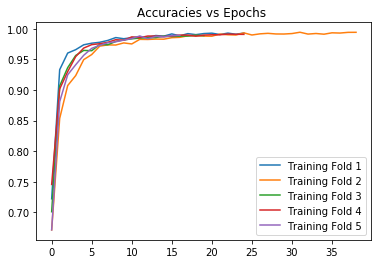

In [87]:
# Plot to see how models are performing 

plt.title('Accuracies vs Epochs ')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

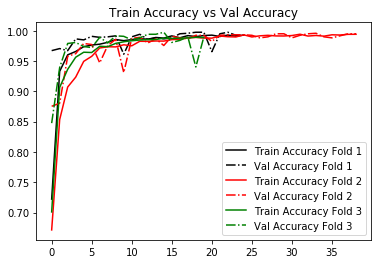

In [88]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
#plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='steelblue', )
#plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='steelblue', linestyle = "dashdot")
#plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='purple', )
#plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='purple', linestyle = "dashdot")


plt.legend()
plt.show()

In [89]:
from keras.models import Sequential, load_model
#Load the model that was saved by ModelCheckpoint
model = load_model('cnn_bee_1.h5')

In [90]:
from keras.models import Sequential, load_model
model.evaluate(x_test, y_test)

4518/4518 [==============================] - ETA: 13 - ETA: 1 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 229us/step


[0.5031788966033395, 0.8820274472236633]

In [356]:
# Evaluate on data that  his never seen 
#model.evaluate(X_test, Y_test)

In [91]:
# Predict labels: 
predicted_classes= model.predict(x_test)

predicted_classes=np.argmax(np.round(predicted_classes), axis=1)

In [92]:
rounded_predictions = model.predict_classes(x_test, batch_size=128, verbose=0)
rounded_predictions[1]

0

In [93]:
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

0

[2020-05-18 16:42:09 RAM77.0% 1.78GB] Confusion matrix, without normalization
[2020-05-18 16:42:09 RAM77.0% 1.78GB] [[ 287  531]
 [   2 3698]]
[2020-05-18 16:42:09 RAM77.0% 1.78GB] Normalized confusion matrix
[2020-05-18 16:42:09 RAM77.0% 1.78GB] [[3.51e-01 6.49e-01]
 [5.41e-04 9.99e-01]]


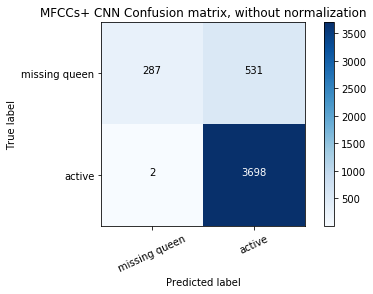

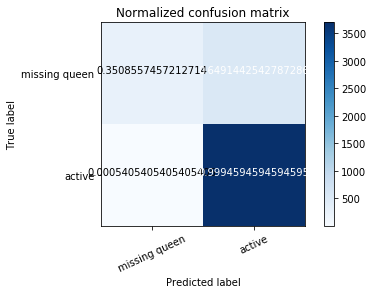

[2020-05-18 16:42:09 RAM77.0% 1.78GB] 
Clasification report MFCCs+ CNN:
                precision    recall  f1-score   support

missing_queen       0.99      0.35      0.52       818
       active       0.87      1.00      0.93      3700

     accuracy                           0.88      4518
    macro avg       0.93      0.68      0.73      4518
 weighted avg       0.90      0.88      0.86      4518



In [96]:

fig = plt.figure()
# Compute confusion matrix
cnf_matrix = confusion_matrix(rounded_labels, rounded_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='MFCCs+ CNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report MFCCs+ CNN:\n', classification_report(rounded_labels, rounded_predictions, target_names=target_names ))

# Method 3: TTBOX+ SVM 

In [2]:
#path_workingFolder_=path_workingFolder='C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_1_second'+str(block_size)+'sec'+os.sep  # path where to save a
#X_ttbox =get_features_from_samples(path_workingFolder, sample_ids, 'TTBOX', 'NO', 0)

def get_list_samples_name_TTBOX(path_audioSegments, extension='.mat'):
    states=['active','missing queen','swarm' ]
    X_ttbox=[]
    labels=[]
    Y=[]
    sample_ids=[]
    # Recupèrer tout les audios d'extention .wav"""""" glob.glob(path_audioSegments_folder+'*'+extension)""""""
    #list_mfcc=[os.path.basename(x) for x in glob.glob(path_audioSegments+'*'+extension)]
    
    for x in glob.glob(path_audioSegments+'*'+extension): 
        sample=x[63:]
        sample_ids.append(sample)
        l= read_HiveState_fromSampleName( sample, states)
        labels.append(l)
        m=scipy.io.loadmat(x)
        X_ttbox.append(m['ttb_vec'])
    
    Y= labels2binary('active', labels)
        
    return X_ttbox,  labels , Y, sample_ids

In [8]:
path_save_audio= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+'\\ttb_mat'+os.sep 
X_ttbox,  labels_ttbox , Y_ttbox, sample_ids_ttbox= get_list_samples_name_TTBOX(path_save_audio, extension='.mat')

NameError: name 'read_HiveState_fromSampleName' is not defined

In [4]:
path_save_audio= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+'\\ttb_mat'+os.sep  # path where to save audio segments and labels files.
def get_list_samples_name(path_audioSegments, extension='.mat'):
    X_ttbox=[]
    sample_ids=[]
    # Recupèrer tout les audios d'extention .mat"""""" glob.glob(path_audioSegments_folder+'*'+extension)""""""
    list_ttbox=[os.path.basename(x) for x in glob.glob(path_audioSegments+'*'+extension)]
    for x in glob.glob(path_audioSegments+'*'+extension):
        
        sample_ids.append(x[63:])
        m=scipy.io.loadmat(x)
        X_ttbox.append(m['ttb_vec'])
    return X_ttbox, sample_ids, list_ttbox
  
X_ttbox, sample_ids_mat, list_ttbox=get_list_samples_name(path_save_audio)

NameError: name 'block_size' is not defined

In [9]:
path_save_audio= 'C:\\Users\\PC\\python\\Stage\\dataset_BeeNoBee_2_second'+str(block_size)+'sec'+'\\ttb_mat'+os.sep  # path
len(path_save_audio)

63

In [11]:
labels = get_GT_labels_fromFiles(path_workingFolder, sample_ids_mat, labels2read)
Y_ttbox= labels2binary('active', labels)

In [20]:
y_ttbox, x_ttbox, sample_ids_concat= BalanceData_online(Y_ttbox, X_ttbox, sample_ids_ttbox)

[2020-05-19 00:03:13 RAM69.2% 0.32GB] Balancing training data:
[2020-05-19 00:03:13 RAM69.2% 0.32GB] will randomly replicate samples from least represented class


In [21]:
x, y, z= x_ttbox.shape
x_ttbox=x_ttbox.reshape(x, y*z)
x_ttbox.shape , y_ttbox.shape

((18524, 164), (18524,))

In [29]:
# split the dataset 
x_train= x_ttbox[4519:]
x_test=x_ttbox[: 4518]
y_test=y_ttbox[:4518]
y_train= y_ttbox[4519:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((14005, 164), (4518, 164), (14005,), (4518,))

In [108]:
#x_train, x_test, y_train, y_test = train_test_split(x_ttbox, y_ttbox, test_size=0.3, random_state = 2020, shuffle=False)
#x_train.shape, x_test.shape, y_train.shape, y_test.shape 

In [30]:
CLF, Test_GroundT, Train_GroundT, Test_Preds, Train_Preds, Test_Preds_Proba, Train_Preds_Proba = SVM_Classification_BeehiveSTATE(x_train, y_train , x_test, y_test, kerneloption='rbf')

[2020-05-19 00:09:39 RAM72.8% 0.34GB] 

[2020-05-19 00:09:39 RAM72.8% 0.34GB] Starting classification with SVM:
[2020-05-19 00:09:39 RAM72.8% 0.34GB] 

[2020-05-19 00:09:39 RAM72.8% 0.34GB] classification Beehive State into : Active or Missing Queen


In [34]:
print("Accuracy: ", metrics.accuracy_score( Test_GroundT, Test_Preds))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Test_GroundT, Test_Preds))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Test_GroundT, Test_Preds))

[2020-05-19 00:28:33 RAM74.6% 0.22GB] Accuracy:  0.013944223107569721
[2020-05-19 00:28:33 RAM74.6% 0.22GB] Precision: 1.0
[2020-05-19 00:28:33 RAM74.6% 0.22GB] Recall: 0.013944223107569721


[2020-05-18 16:50:13 RAM77.6% 1.67GB] Confusion matrix, without normalization
[2020-05-18 16:50:13 RAM77.6% 1.67GB] [[ 577  241]
 [1080 2620]]
[2020-05-18 16:50:13 RAM77.6% 1.67GB] Normalized confusion matrix
[2020-05-18 16:50:13 RAM77.6% 1.67GB] [[0.71 0.29]
 [0.29 0.71]]


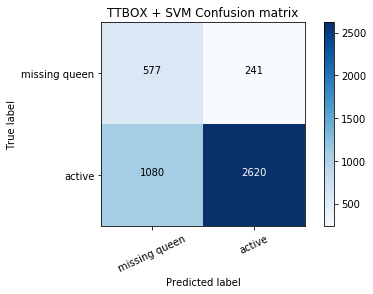

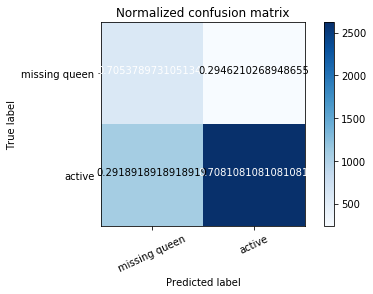

[2020-05-18 16:50:13 RAM77.6% 1.67GB] 
Clasification report TTBOX + SVM:
                precision    recall  f1-score   support

missing_queen       0.35      0.71      0.47       818
       active       0.92      0.71      0.80      3700

     accuracy                           0.71      4518
    macro avg       0.63      0.71      0.63      4518
 weighted avg       0.81      0.71      0.74      4518



In [115]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Test_GroundT, Test_Preds )
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='TTBOX + SVM Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report TTBOX + SVM:\n', classification_report(Test_GroundT, Test_Preds , target_names=target_names))

# Method 4: TTBOX+ CNN

In [42]:
X_ttbox= x_ttbox.reshape(-1, 1, 164, 1)
Y_ttbox=y_ttbox.reshape(-1, 1)
X_ttbox.shape, Y_ttbox.shape

((17702, 1, 164, 1), (17702, 1))

In [52]:
# Convert features and corresponding classification labels into numpy arrays

X_ttbox = np.array(X_ttbox.tolist())
Y_ttbox = np.array(Y_ttbox.tolist())
# Encode the classification labels
te = LabelEncoder()
y_ttbox = to_categorical(te.fit_transform(Y_ttbox)) 


# split the dataset 
from sklearn.model_selection import train_test_split 
#train_x, test_x, train_y, test_y = train_test_split(X_ttbox, y_ttbox, test_size=0.3, random_state = 2020, shuffle=False)
#train_x.shape, test_x.shape, train_y.shape, test_y.shape 

In [54]:
# split the dataset 
train_x= X_ttbox[4519:]
test_x=X_ttbox[: 4518]
test_y=y_ttbox[:4518]
train_y= y_ttbox[4519:]
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((13183, 1, 164, 1), (4518, 1, 164, 1), (13183, 2), (4518, 2))

In [55]:
#size=(1, 164,1 )
size=(1, 164, 1)
model1= deep_model(size)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 164, 16)        160       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 1, 164, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 82, 16)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 82, 16)         2320      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1, 82, 16)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 41, 16)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 41, 16)        

In [56]:
# Set early stopping critiria
pat=5 # this is the number of epocks with no improvment after which the training will stop 

early_stopping= EarlyStopping(monitor='val_loss', patience=pat, verbose=1 )

# define the model check point callback -> this will keep saving the model as a physical file 
model_checkpoint= ModelCheckpoint('ttbox_deep_model.h5', verbose=1, save_best_only=True )

# define a function to fit the model

def fit_and_evaluate(train_x, val_x, train_y, val_y, EPOCHS=50, BATCH_SIZE=145 ):
    model=None
    model=deep_model((1, 164,1))
    results= model.fit(train_x, train_y, epochs=EPOCHS, batch_size= BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.1)
    print("Val Score :", model.evaluate(val_x, val_y))
    return results 

In [57]:
# save the model history in a list after fitting so we can plot later 
model_history=[]
for i in range(n_folds):
    print("Training on Fold :", i+1)
    x_t, x_v, y_t, y_v = train_test_split(train_x, train_y, test_size=0.10, random_state = 2020)
    model_history.append(fit_and_evaluate(x_t, x_v, y_t, y_v, epochs, batch_size))
    print("============="*12, end="\n\n\n")

[2020-05-18 15:55:11 RAM62.7% 0.51GB] Training on Fold : 1
Train on 10677 samples, validate on 1187 samples
Epoch 1/50
10677/10677 [==============================] - ETA: 36s - loss: 2.2729 - accuracy: 0.627 - ETA: 13s - loss: 3.5517 - accuracy: 0.554 - ETA: 9s - loss: 2.5540 - accuracy: 0.582 - ETA: 8s - loss: 2.2962 - accuracy: 0.57 - ETA: 6s - loss: 1.9104 - accuracy: 0.58 - ETA: 5s - loss: 1.6824 - accuracy: 0.59 - ETA: 5s - loss: 1.5147 - accuracy: 0.60 - ETA: 4s - loss: 1.3907 - accuracy: 0.61 - ETA: 4s - loss: 1.3433 - accuracy: 0.61 - ETA: 4s - loss: 1.3008 - accuracy: 0.62 - ETA: 4s - loss: 1.2622 - accuracy: 0.62 - ETA: 3s - loss: 1.1941 - accuracy: 0.63 - ETA: 3s - loss: 1.1371 - accuracy: 0.63 - ETA: 3s - loss: 1.0902 - accuracy: 0.64 - ETA: 3s - loss: 1.0506 - accuracy: 0.64 - ETA: 2s - loss: 1.0152 - accuracy: 0.65 - ETA: 2s - loss: 0.9876 - accuracy: 0.65 - ETA: 2s - loss: 0.9717 - accuracy: 0.65 - ETA: 2s - loss: 0.9459 - accuracy: 0.66 - ETA: 2s - loss: 0.9338 - accura

10677/10677 [==============================] - ETA: 2s - loss: 0.4596 - accuracy: 0.76 - ETA: 2s - loss: 0.4445 - accuracy: 0.79 - ETA: 2s - loss: 0.4250 - accuracy: 0.79 - ETA: 2s - loss: 0.4195 - accuracy: 0.79 - ETA: 2s - loss: 0.4215 - accuracy: 0.80 - ETA: 2s - loss: 0.4104 - accuracy: 0.81 - ETA: 2s - loss: 0.4233 - accuracy: 0.80 - ETA: 2s - loss: 0.4169 - accuracy: 0.81 - ETA: 2s - loss: 0.4191 - accuracy: 0.80 - ETA: 2s - loss: 0.4281 - accuracy: 0.80 - ETA: 2s - loss: 0.4288 - accuracy: 0.80 - ETA: 2s - loss: 0.4278 - accuracy: 0.80 - ETA: 2s - loss: 0.4270 - accuracy: 0.80 - ETA: 2s - loss: 0.4260 - accuracy: 0.80 - ETA: 2s - loss: 0.4267 - accuracy: 0.80 - ETA: 1s - loss: 0.4282 - accuracy: 0.80 - ETA: 1s - loss: 0.4261 - accuracy: 0.80 - ETA: 1s - loss: 0.4262 - accuracy: 0.80 - ETA: 1s - loss: 0.4241 - accuracy: 0.80 - ETA: 1s - loss: 0.4206 - accuracy: 0.80 - ETA: 1s - loss: 0.4189 - accuracy: 0.80 - ETA: 1s - loss: 0.4197 - accuracy: 0.80 - ETA: 1s - loss: 0.4172 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.3572 - accuracy: 0.83 - ETA: 3s - loss: 0.3561 - accuracy: 0.83 - ETA: 3s - loss: 0.3536 - accuracy: 0.84 - ETA: 2s - loss: 0.3605 - accuracy: 0.84 - ETA: 2s - loss: 0.3595 - accuracy: 0.84 - ETA: 2s - loss: 0.3678 - accuracy: 0.84 - ETA: 2s - loss: 0.3626 - accuracy: 0.84 - ETA: 2s - loss: 0.3742 - accuracy: 0.83 - ETA: 2s - loss: 0.3745 - accuracy: 0.83 - ETA: 2s - loss: 0.3691 - accuracy: 0.83 - ETA: 2s - loss: 0.3670 - accuracy: 0.83 - ETA: 2s - loss: 0.3755 - accuracy: 0.82 - ETA: 2s - loss: 0.3733 - accuracy: 0.83 - ETA: 2s - loss: 0.3711 - accuracy: 0.83 - ETA: 2s - loss: 0.3770 - accuracy: 0.83 - ETA: 2s - loss: 0.3769 - accuracy: 0.83 - ETA: 1s - loss: 0.3770 - accuracy: 0.82 - ETA: 1s - loss: 0.3774 - accuracy: 0.82 - ETA: 1s - loss: 0.3786 - accuracy: 0.82 - ETA: 1s - loss: 0.3749 - accuracy: 0.83 - ETA: 1s - loss: 0.3771 - accuracy: 0.82 - ETA: 1s - loss: 0.3766 - accuracy: 0.82 - ETA: 1s - loss: 0.3756 - accu


Epoch 00023: val_loss did not improve from 0.32433
Epoch 24/50
10677/10677 [==============================] - ETA: 4s - loss: 0.4170 - accuracy: 0.81 - ETA: 3s - loss: 0.3451 - accuracy: 0.84 - ETA: 3s - loss: 0.3399 - accuracy: 0.86 - ETA: 3s - loss: 0.3466 - accuracy: 0.85 - ETA: 3s - loss: 0.3506 - accuracy: 0.85 - ETA: 3s - loss: 0.3535 - accuracy: 0.85 - ETA: 3s - loss: 0.3571 - accuracy: 0.84 - ETA: 3s - loss: 0.3696 - accuracy: 0.83 - ETA: 2s - loss: 0.3733 - accuracy: 0.83 - ETA: 2s - loss: 0.3685 - accuracy: 0.83 - ETA: 2s - loss: 0.3593 - accuracy: 0.83 - ETA: 2s - loss: 0.3591 - accuracy: 0.83 - ETA: 2s - loss: 0.3555 - accuracy: 0.84 - ETA: 2s - loss: 0.3535 - accuracy: 0.84 - ETA: 2s - loss: 0.3555 - accuracy: 0.84 - ETA: 2s - loss: 0.3548 - accuracy: 0.84 - ETA: 2s - loss: 0.3581 - accuracy: 0.83 - ETA: 2s - loss: 0.3572 - accuracy: 0.83 - ETA: 2s - loss: 0.3559 - accuracy: 0.83 - ETA: 1s - loss: 0.3568 - accuracy: 0.83 - ETA: 1s - loss: 0.3558 - accuracy: 0.83 - ETA: 1s

10677/10677 [==============================] - ETA: 3s - loss: 0.4877 - accuracy: 0.73 - ETA: 2s - loss: 0.4177 - accuracy: 0.80 - ETA: 2s - loss: 0.4481 - accuracy: 0.79 - ETA: 2s - loss: 0.4450 - accuracy: 0.80 - ETA: 2s - loss: 0.4498 - accuracy: 0.79 - ETA: 2s - loss: 0.4495 - accuracy: 0.79 - ETA: 2s - loss: 0.4472 - accuracy: 0.80 - ETA: 2s - loss: 0.4491 - accuracy: 0.79 - ETA: 2s - loss: 0.4428 - accuracy: 0.79 - ETA: 2s - loss: 0.4472 - accuracy: 0.79 - ETA: 2s - loss: 0.4442 - accuracy: 0.79 - ETA: 2s - loss: 0.4444 - accuracy: 0.79 - ETA: 2s - loss: 0.4400 - accuracy: 0.80 - ETA: 2s - loss: 0.4433 - accuracy: 0.79 - ETA: 2s - loss: 0.4421 - accuracy: 0.79 - ETA: 1s - loss: 0.4427 - accuracy: 0.79 - ETA: 1s - loss: 0.4387 - accuracy: 0.80 - ETA: 1s - loss: 0.4417 - accuracy: 0.80 - ETA: 1s - loss: 0.4404 - accuracy: 0.80 - ETA: 1s - loss: 0.4390 - accuracy: 0.80 - ETA: 1s - loss: 0.4378 - accuracy: 0.80 - ETA: 1s - loss: 0.4376 - accuracy: 0.80 - ETA: 1s - loss: 0.4382 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.3387 - accuracy: 0.82 - ETA: 2s - loss: 0.3255 - accuracy: 0.84 - ETA: 2s - loss: 0.3822 - accuracy: 0.82 - ETA: 2s - loss: 0.3621 - accuracy: 0.83 - ETA: 2s - loss: 0.3745 - accuracy: 0.82 - ETA: 2s - loss: 0.3808 - accuracy: 0.81 - ETA: 2s - loss: 0.3837 - accuracy: 0.81 - ETA: 2s - loss: 0.3901 - accuracy: 0.81 - ETA: 2s - loss: 0.3920 - accuracy: 0.81 - ETA: 2s - loss: 0.3882 - accuracy: 0.82 - ETA: 2s - loss: 0.3920 - accuracy: 0.81 - ETA: 2s - loss: 0.3958 - accuracy: 0.81 - ETA: 2s - loss: 0.3910 - accuracy: 0.81 - ETA: 2s - loss: 0.3886 - accuracy: 0.81 - ETA: 2s - loss: 0.3858 - accuracy: 0.81 - ETA: 2s - loss: 0.3826 - accuracy: 0.81 - ETA: 1s - loss: 0.3820 - accuracy: 0.81 - ETA: 1s - loss: 0.3819 - accuracy: 0.82 - ETA: 1s - loss: 0.3831 - accuracy: 0.82 - ETA: 1s - loss: 0.3836 - accuracy: 0.82 - ETA: 1s - loss: 0.3819 - accuracy: 0.82 - ETA: 1s - loss: 0.3811 - accuracy: 0.82 - ETA: 1s - loss: 0.3828 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.2455 - accuracy: 0.88 - ETA: 3s - loss: 0.3287 - accuracy: 0.84 - ETA: 3s - loss: 0.3483 - accuracy: 0.84 - ETA: 2s - loss: 0.3674 - accuracy: 0.82 - ETA: 2s - loss: 0.3625 - accuracy: 0.83 - ETA: 2s - loss: 0.3573 - accuracy: 0.83 - ETA: 2s - loss: 0.3520 - accuracy: 0.84 - ETA: 2s - loss: 0.3505 - accuracy: 0.84 - ETA: 2s - loss: 0.3428 - accuracy: 0.84 - ETA: 2s - loss: 0.3446 - accuracy: 0.84 - ETA: 2s - loss: 0.3421 - accuracy: 0.84 - ETA: 2s - loss: 0.3410 - accuracy: 0.84 - ETA: 2s - loss: 0.3453 - accuracy: 0.84 - ETA: 2s - loss: 0.3458 - accuracy: 0.84 - ETA: 2s - loss: 0.3487 - accuracy: 0.84 - ETA: 2s - loss: 0.3474 - accuracy: 0.84 - ETA: 2s - loss: 0.3494 - accuracy: 0.84 - ETA: 1s - loss: 0.3494 - accuracy: 0.84 - ETA: 1s - loss: 0.3515 - accuracy: 0.83 - ETA: 1s - loss: 0.3503 - accuracy: 0.84 - ETA: 1s - loss: 0.3493 - accuracy: 0.84 - ETA: 1s - loss: 0.3499 - accuracy: 0.84 - ETA: 1s - loss: 0.3471 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.2656 - accuracy: 0.87 - ETA: 2s - loss: 0.3602 - accuracy: 0.82 - ETA: 2s - loss: 0.3523 - accuracy: 0.83 - ETA: 2s - loss: 0.3468 - accuracy: 0.83 - ETA: 2s - loss: 0.3476 - accuracy: 0.83 - ETA: 2s - loss: 0.3494 - accuracy: 0.84 - ETA: 2s - loss: 0.3433 - accuracy: 0.84 - ETA: 2s - loss: 0.3402 - accuracy: 0.84 - ETA: 2s - loss: 0.3422 - accuracy: 0.84 - ETA: 2s - loss: 0.3435 - accuracy: 0.84 - ETA: 2s - loss: 0.3417 - accuracy: 0.84 - ETA: 2s - loss: 0.3414 - accuracy: 0.84 - ETA: 2s - loss: 0.3390 - accuracy: 0.84 - ETA: 2s - loss: 0.3372 - accuracy: 0.84 - ETA: 1s - loss: 0.3363 - accuracy: 0.84 - ETA: 1s - loss: 0.3373 - accuracy: 0.84 - ETA: 1s - loss: 0.3384 - accuracy: 0.84 - ETA: 1s - loss: 0.3402 - accuracy: 0.84 - ETA: 1s - loss: 0.3377 - accuracy: 0.84 - ETA: 1s - loss: 0.3329 - accuracy: 0.84 - ETA: 1s - loss: 0.3295 - accuracy: 0.85 - ETA: 1s - loss: 0.3285 - accuracy: 0.85 - ETA: 1s - loss: 0.3277 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.5339 - accuracy: 0.74 - ETA: 3s - loss: 0.5193 - accuracy: 0.74 - ETA: 3s - loss: 0.4941 - accuracy: 0.76 - ETA: 2s - loss: 0.4748 - accuracy: 0.77 - ETA: 2s - loss: 0.4770 - accuracy: 0.78 - ETA: 2s - loss: 0.4771 - accuracy: 0.78 - ETA: 2s - loss: 0.4804 - accuracy: 0.77 - ETA: 2s - loss: 0.4771 - accuracy: 0.78 - ETA: 2s - loss: 0.4755 - accuracy: 0.78 - ETA: 2s - loss: 0.4787 - accuracy: 0.78 - ETA: 2s - loss: 0.4765 - accuracy: 0.78 - ETA: 2s - loss: 0.4727 - accuracy: 0.78 - ETA: 2s - loss: 0.4673 - accuracy: 0.79 - ETA: 2s - loss: 0.4667 - accuracy: 0.79 - ETA: 2s - loss: 0.4598 - accuracy: 0.79 - ETA: 2s - loss: 0.4619 - accuracy: 0.79 - ETA: 2s - loss: 0.4602 - accuracy: 0.79 - ETA: 1s - loss: 0.4554 - accuracy: 0.79 - ETA: 1s - loss: 0.4562 - accuracy: 0.79 - ETA: 1s - loss: 0.4589 - accuracy: 0.79 - ETA: 1s - loss: 0.4591 - accuracy: 0.79 - ETA: 1s - loss: 0.4582 - accuracy: 0.79 - ETA: 1s - loss: 0.4571 - accu

Epoch 00012: val_loss did not improve from 0.31344
Epoch 13/50
10677/10677 [==============================] - ETA: 3s - loss: 0.5084 - accuracy: 0.78 - ETA: 2s - loss: 0.4255 - accuracy: 0.80 - ETA: 2s - loss: 0.4163 - accuracy: 0.81 - ETA: 2s - loss: 0.4110 - accuracy: 0.81 - ETA: 2s - loss: 0.4100 - accuracy: 0.81 - ETA: 2s - loss: 0.4125 - accuracy: 0.81 - ETA: 2s - loss: 0.4046 - accuracy: 0.81 - ETA: 2s - loss: 0.4102 - accuracy: 0.81 - ETA: 2s - loss: 0.4070 - accuracy: 0.81 - ETA: 2s - loss: 0.4098 - accuracy: 0.81 - ETA: 2s - loss: 0.4097 - accuracy: 0.81 - ETA: 2s - loss: 0.4110 - accuracy: 0.81 - ETA: 2s - loss: 0.4094 - accuracy: 0.81 - ETA: 2s - loss: 0.4096 - accuracy: 0.81 - ETA: 2s - loss: 0.4106 - accuracy: 0.81 - ETA: 1s - loss: 0.4114 - accuracy: 0.81 - ETA: 1s - loss: 0.4097 - accuracy: 0.81 - ETA: 1s - loss: 0.4100 - accuracy: 0.81 - ETA: 1s - loss: 0.4107 - accuracy: 0.81 - ETA: 1s - loss: 0.4117 - accuracy: 0.81 - ETA: 1s - loss: 0.4100 - accuracy: 0.81 - ETA: 1s 


Epoch 00016: val_loss did not improve from 0.31344
Epoch 17/50
10677/10677 [==============================] - ETA: 3s - loss: 0.3622 - accuracy: 0.84 - ETA: 3s - loss: 0.4428 - accuracy: 0.79 - ETA: 3s - loss: 0.4311 - accuracy: 0.81 - ETA: 3s - loss: 0.4291 - accuracy: 0.81 - ETA: 3s - loss: 0.4130 - accuracy: 0.81 - ETA: 3s - loss: 0.4132 - accuracy: 0.81 - ETA: 3s - loss: 0.4159 - accuracy: 0.81 - ETA: 3s - loss: 0.4165 - accuracy: 0.81 - ETA: 3s - loss: 0.4117 - accuracy: 0.81 - ETA: 3s - loss: 0.4024 - accuracy: 0.82 - ETA: 3s - loss: 0.4067 - accuracy: 0.81 - ETA: 3s - loss: 0.4021 - accuracy: 0.82 - ETA: 3s - loss: 0.4063 - accuracy: 0.81 - ETA: 3s - loss: 0.4043 - accuracy: 0.81 - ETA: 3s - loss: 0.4025 - accuracy: 0.81 - ETA: 3s - loss: 0.4122 - accuracy: 0.81 - ETA: 3s - loss: 0.4059 - accuracy: 0.82 - ETA: 3s - loss: 0.4039 - accuracy: 0.82 - ETA: 3s - loss: 0.4001 - accuracy: 0.82 - ETA: 3s - loss: 0.4085 - accuracy: 0.81 - ETA: 2s - loss: 0.4121 - accuracy: 0.81 - ETA: 2s

10677/10677 [==============================] - ETA: 3s - loss: 0.5750 - accuracy: 0.71 - ETA: 3s - loss: 0.5352 - accuracy: 0.74 - ETA: 3s - loss: 0.5452 - accuracy: 0.74 - ETA: 3s - loss: 0.4976 - accuracy: 0.77 - ETA: 3s - loss: 0.4974 - accuracy: 0.78 - ETA: 3s - loss: 0.4910 - accuracy: 0.78 - ETA: 3s - loss: 0.4752 - accuracy: 0.78 - ETA: 3s - loss: 0.4768 - accuracy: 0.78 - ETA: 3s - loss: 0.4745 - accuracy: 0.78 - ETA: 3s - loss: 0.4761 - accuracy: 0.78 - ETA: 3s - loss: 0.4760 - accuracy: 0.78 - ETA: 2s - loss: 0.4796 - accuracy: 0.77 - ETA: 2s - loss: 0.4783 - accuracy: 0.77 - ETA: 2s - loss: 0.4773 - accuracy: 0.78 - ETA: 2s - loss: 0.4754 - accuracy: 0.78 - ETA: 2s - loss: 0.4710 - accuracy: 0.78 - ETA: 2s - loss: 0.4671 - accuracy: 0.78 - ETA: 2s - loss: 0.4658 - accuracy: 0.78 - ETA: 2s - loss: 0.4685 - accuracy: 0.78 - ETA: 2s - loss: 0.4697 - accuracy: 0.78 - ETA: 2s - loss: 0.4683 - accuracy: 0.78 - ETA: 2s - loss: 0.4693 - accuracy: 0.78 - ETA: 2s - loss: 0.4691 - accu


Epoch 00007: val_loss did not improve from 0.31344
Epoch 8/50
10677/10677 [==============================] - ETA: 3s - loss: 0.5317 - accuracy: 0.75 - ETA: 3s - loss: 0.4806 - accuracy: 0.77 - ETA: 3s - loss: 0.4587 - accuracy: 0.79 - ETA: 3s - loss: 0.4357 - accuracy: 0.79 - ETA: 3s - loss: 0.4207 - accuracy: 0.80 - ETA: 3s - loss: 0.4201 - accuracy: 0.80 - ETA: 3s - loss: 0.4132 - accuracy: 0.80 - ETA: 3s - loss: 0.4221 - accuracy: 0.80 - ETA: 3s - loss: 0.4199 - accuracy: 0.80 - ETA: 3s - loss: 0.4207 - accuracy: 0.80 - ETA: 3s - loss: 0.4164 - accuracy: 0.80 - ETA: 3s - loss: 0.4188 - accuracy: 0.80 - ETA: 3s - loss: 0.4220 - accuracy: 0.80 - ETA: 2s - loss: 0.4272 - accuracy: 0.79 - ETA: 2s - loss: 0.4292 - accuracy: 0.79 - ETA: 2s - loss: 0.4291 - accuracy: 0.80 - ETA: 2s - loss: 0.4298 - accuracy: 0.80 - ETA: 2s - loss: 0.4297 - accuracy: 0.80 - ETA: 2s - loss: 0.4289 - accuracy: 0.80 - ETA: 2s - loss: 0.4299 - accuracy: 0.80 - ETA: 2s - loss: 0.4284 - accuracy: 0.80 - ETA: 2s 

10677/10677 [==============================] - ETA: 3s - loss: 0.3552 - accuracy: 0.86 - ETA: 3s - loss: 0.3835 - accuracy: 0.83 - ETA: 3s - loss: 0.3812 - accuracy: 0.83 - ETA: 3s - loss: 0.3753 - accuracy: 0.83 - ETA: 3s - loss: 0.3943 - accuracy: 0.82 - ETA: 3s - loss: 0.3969 - accuracy: 0.81 - ETA: 3s - loss: 0.3976 - accuracy: 0.81 - ETA: 3s - loss: 0.3921 - accuracy: 0.81 - ETA: 3s - loss: 0.3926 - accuracy: 0.81 - ETA: 3s - loss: 0.3877 - accuracy: 0.82 - ETA: 2s - loss: 0.3954 - accuracy: 0.81 - ETA: 2s - loss: 0.3974 - accuracy: 0.81 - ETA: 2s - loss: 0.3998 - accuracy: 0.81 - ETA: 2s - loss: 0.3969 - accuracy: 0.81 - ETA: 2s - loss: 0.4010 - accuracy: 0.81 - ETA: 2s - loss: 0.3984 - accuracy: 0.81 - ETA: 2s - loss: 0.3972 - accuracy: 0.81 - ETA: 2s - loss: 0.3989 - accuracy: 0.81 - ETA: 2s - loss: 0.3965 - accuracy: 0.81 - ETA: 2s - loss: 0.4002 - accuracy: 0.81 - ETA: 2s - loss: 0.3968 - accuracy: 0.81 - ETA: 2s - loss: 0.3955 - accuracy: 0.81 - ETA: 2s - loss: 0.3957 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.3298 - accuracy: 0.88 - ETA: 3s - loss: 0.3041 - accuracy: 0.88 - ETA: 3s - loss: 0.3441 - accuracy: 0.87 - ETA: 3s - loss: 0.3601 - accuracy: 0.86 - ETA: 3s - loss: 0.3743 - accuracy: 0.85 - ETA: 3s - loss: 0.3799 - accuracy: 0.84 - ETA: 3s - loss: 0.3854 - accuracy: 0.84 - ETA: 3s - loss: 0.3913 - accuracy: 0.83 - ETA: 3s - loss: 0.3802 - accuracy: 0.83 - ETA: 3s - loss: 0.3842 - accuracy: 0.83 - ETA: 3s - loss: 0.3804 - accuracy: 0.83 - ETA: 3s - loss: 0.3793 - accuracy: 0.83 - ETA: 3s - loss: 0.3774 - accuracy: 0.83 - ETA: 3s - loss: 0.3726 - accuracy: 0.84 - ETA: 3s - loss: 0.3835 - accuracy: 0.83 - ETA: 3s - loss: 0.3800 - accuracy: 0.83 - ETA: 3s - loss: 0.3791 - accuracy: 0.83 - ETA: 2s - loss: 0.3753 - accuracy: 0.83 - ETA: 2s - loss: 0.3736 - accuracy: 0.83 - ETA: 2s - loss: 0.3733 - accuracy: 0.83 - ETA: 2s - loss: 0.3766 - accuracy: 0.83 - ETA: 2s - loss: 0.3776 - accuracy: 0.83 - ETA: 2s - loss: 0.3761 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.4781 - accuracy: 0.78 - ETA: 3s - loss: 0.5105 - accuracy: 0.78 - ETA: 3s - loss: 0.5190 - accuracy: 0.78 - ETA: 3s - loss: 0.5177 - accuracy: 0.78 - ETA: 3s - loss: 0.5200 - accuracy: 0.78 - ETA: 3s - loss: 0.5241 - accuracy: 0.78 - ETA: 3s - loss: 0.5277 - accuracy: 0.78 - ETA: 3s - loss: 0.5304 - accuracy: 0.78 - ETA: 3s - loss: 0.5280 - accuracy: 0.78 - ETA: 3s - loss: 0.5273 - accuracy: 0.78 - ETA: 3s - loss: 0.5267 - accuracy: 0.78 - ETA: 3s - loss: 0.5276 - accuracy: 0.77 - ETA: 3s - loss: 0.5287 - accuracy: 0.77 - ETA: 2s - loss: 0.5335 - accuracy: 0.77 - ETA: 2s - loss: 0.5272 - accuracy: 0.77 - ETA: 2s - loss: 0.5246 - accuracy: 0.77 - ETA: 2s - loss: 0.5203 - accuracy: 0.77 - ETA: 2s - loss: 0.5238 - accuracy: 0.77 - ETA: 2s - loss: 0.5224 - accuracy: 0.77 - ETA: 2s - loss: 0.5217 - accuracy: 0.77 - ETA: 2s - loss: 0.5206 - accuracy: 0.77 - ETA: 2s - loss: 0.5193 - accuracy: 0.77 - ETA: 2s - loss: 0.5172 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.4197 - accuracy: 0.79 - ETA: 3s - loss: 0.3823 - accuracy: 0.80 - ETA: 3s - loss: 0.4152 - accuracy: 0.79 - ETA: 3s - loss: 0.4127 - accuracy: 0.79 - ETA: 3s - loss: 0.4242 - accuracy: 0.79 - ETA: 3s - loss: 0.4277 - accuracy: 0.80 - ETA: 3s - loss: 0.4307 - accuracy: 0.79 - ETA: 3s - loss: 0.4303 - accuracy: 0.79 - ETA: 3s - loss: 0.4280 - accuracy: 0.80 - ETA: 3s - loss: 0.4269 - accuracy: 0.80 - ETA: 3s - loss: 0.4274 - accuracy: 0.79 - ETA: 3s - loss: 0.4300 - accuracy: 0.80 - ETA: 3s - loss: 0.4297 - accuracy: 0.80 - ETA: 3s - loss: 0.4257 - accuracy: 0.80 - ETA: 2s - loss: 0.4331 - accuracy: 0.79 - ETA: 2s - loss: 0.4369 - accuracy: 0.79 - ETA: 2s - loss: 0.4346 - accuracy: 0.80 - ETA: 2s - loss: 0.4329 - accuracy: 0.80 - ETA: 2s - loss: 0.4289 - accuracy: 0.80 - ETA: 2s - loss: 0.4305 - accuracy: 0.80 - ETA: 2s - loss: 0.4343 - accuracy: 0.80 - ETA: 2s - loss: 0.4311 - accuracy: 0.80 - ETA: 2s - loss: 0.4300 - accu

Epoch 00010: val_loss did not improve from 0.31344
Epoch 11/50
10677/10677 [==============================] - ETA: 4s - loss: 0.4407 - accuracy: 0.78 - ETA: 4s - loss: 0.4053 - accuracy: 0.81 - ETA: 4s - loss: 0.4021 - accuracy: 0.80 - ETA: 3s - loss: 0.4079 - accuracy: 0.80 - ETA: 3s - loss: 0.4187 - accuracy: 0.80 - ETA: 3s - loss: 0.4125 - accuracy: 0.80 - ETA: 3s - loss: 0.4092 - accuracy: 0.80 - ETA: 3s - loss: 0.4109 - accuracy: 0.80 - ETA: 3s - loss: 0.4048 - accuracy: 0.81 - ETA: 3s - loss: 0.3924 - accuracy: 0.81 - ETA: 3s - loss: 0.3993 - accuracy: 0.81 - ETA: 3s - loss: 0.4017 - accuracy: 0.80 - ETA: 3s - loss: 0.3982 - accuracy: 0.80 - ETA: 2s - loss: 0.3954 - accuracy: 0.81 - ETA: 2s - loss: 0.3923 - accuracy: 0.81 - ETA: 2s - loss: 0.3922 - accuracy: 0.81 - ETA: 2s - loss: 0.3939 - accuracy: 0.81 - ETA: 2s - loss: 0.3919 - accuracy: 0.81 - ETA: 2s - loss: 0.3912 - accuracy: 0.81 - ETA: 2s - loss: 0.3906 - accuracy: 0.81 - ETA: 2s - loss: 0.3923 - accuracy: 0.81 - ETA: 2s 


Epoch 00013: val_loss did not improve from 0.31344
Epoch 14/50
10677/10677 [==============================] - ETA: 3s - loss: 0.3655 - accuracy: 0.81 - ETA: 3s - loss: 0.3690 - accuracy: 0.82 - ETA: 3s - loss: 0.3683 - accuracy: 0.82 - ETA: 3s - loss: 0.3812 - accuracy: 0.82 - ETA: 3s - loss: 0.3718 - accuracy: 0.82 - ETA: 3s - loss: 0.3617 - accuracy: 0.82 - ETA: 3s - loss: 0.3628 - accuracy: 0.82 - ETA: 3s - loss: 0.3656 - accuracy: 0.82 - ETA: 3s - loss: 0.3596 - accuracy: 0.82 - ETA: 3s - loss: 0.3601 - accuracy: 0.82 - ETA: 3s - loss: 0.3603 - accuracy: 0.82 - ETA: 2s - loss: 0.3618 - accuracy: 0.82 - ETA: 2s - loss: 0.3663 - accuracy: 0.82 - ETA: 2s - loss: 0.3653 - accuracy: 0.82 - ETA: 2s - loss: 0.3603 - accuracy: 0.83 - ETA: 2s - loss: 0.3632 - accuracy: 0.82 - ETA: 2s - loss: 0.3647 - accuracy: 0.82 - ETA: 2s - loss: 0.3651 - accuracy: 0.82 - ETA: 2s - loss: 0.3658 - accuracy: 0.82 - ETA: 2s - loss: 0.3679 - accuracy: 0.82 - ETA: 2s - loss: 0.3702 - accuracy: 0.82 - ETA: 2s

10677/10677 [==============================] - ETA: 3s - loss: 0.3462 - accuracy: 0.85 - ETA: 3s - loss: 0.3380 - accuracy: 0.84 - ETA: 3s - loss: 0.3443 - accuracy: 0.84 - ETA: 3s - loss: 0.3559 - accuracy: 0.84 - ETA: 3s - loss: 0.3542 - accuracy: 0.83 - ETA: 3s - loss: 0.3460 - accuracy: 0.84 - ETA: 3s - loss: 0.3494 - accuracy: 0.84 - ETA: 3s - loss: 0.3578 - accuracy: 0.83 - ETA: 3s - loss: 0.3547 - accuracy: 0.83 - ETA: 3s - loss: 0.3576 - accuracy: 0.83 - ETA: 3s - loss: 0.3557 - accuracy: 0.83 - ETA: 3s - loss: 0.3564 - accuracy: 0.84 - ETA: 3s - loss: 0.3525 - accuracy: 0.84 - ETA: 3s - loss: 0.3524 - accuracy: 0.84 - ETA: 2s - loss: 0.3561 - accuracy: 0.83 - ETA: 2s - loss: 0.3516 - accuracy: 0.84 - ETA: 2s - loss: 0.3491 - accuracy: 0.84 - ETA: 2s - loss: 0.3481 - accuracy: 0.84 - ETA: 2s - loss: 0.3449 - accuracy: 0.84 - ETA: 2s - loss: 0.3426 - accuracy: 0.84 - ETA: 2s - loss: 0.3395 - accuracy: 0.85 - ETA: 2s - loss: 0.3424 - accuracy: 0.84 - ETA: 2s - loss: 0.3424 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.4283 - accuracy: 0.79 - ETA: 3s - loss: 0.4806 - accuracy: 0.76 - ETA: 3s - loss: 0.4884 - accuracy: 0.76 - ETA: 3s - loss: 0.4798 - accuracy: 0.77 - ETA: 3s - loss: 0.4751 - accuracy: 0.77 - ETA: 3s - loss: 0.4836 - accuracy: 0.77 - ETA: 3s - loss: 0.4813 - accuracy: 0.76 - ETA: 3s - loss: 0.4759 - accuracy: 0.77 - ETA: 3s - loss: 0.4826 - accuracy: 0.77 - ETA: 3s - loss: 0.4809 - accuracy: 0.77 - ETA: 3s - loss: 0.4796 - accuracy: 0.77 - ETA: 3s - loss: 0.4781 - accuracy: 0.77 - ETA: 3s - loss: 0.4733 - accuracy: 0.77 - ETA: 3s - loss: 0.4722 - accuracy: 0.77 - ETA: 3s - loss: 0.4717 - accuracy: 0.77 - ETA: 3s - loss: 0.4729 - accuracy: 0.77 - ETA: 3s - loss: 0.4647 - accuracy: 0.78 - ETA: 3s - loss: 0.4629 - accuracy: 0.78 - ETA: 3s - loss: 0.4629 - accuracy: 0.78 - ETA: 3s - loss: 0.4611 - accuracy: 0.78 - ETA: 3s - loss: 0.4617 - accuracy: 0.78 - ETA: 3s - loss: 0.4646 - accuracy: 0.78 - ETA: 2s - loss: 0.4663 - accu

10677/10677 [==============================] - ETA: 4s - loss: 0.3578 - accuracy: 0.82 - ETA: 4s - loss: 0.3763 - accuracy: 0.82 - ETA: 5s - loss: 0.3921 - accuracy: 0.83 - ETA: 5s - loss: 0.4019 - accuracy: 0.82 - ETA: 5s - loss: 0.4135 - accuracy: 0.81 - ETA: 6s - loss: 0.4084 - accuracy: 0.81 - ETA: 6s - loss: 0.4105 - accuracy: 0.81 - ETA: 5s - loss: 0.4039 - accuracy: 0.82 - ETA: 5s - loss: 0.3993 - accuracy: 0.82 - ETA: 5s - loss: 0.3947 - accuracy: 0.82 - ETA: 5s - loss: 0.3914 - accuracy: 0.82 - ETA: 5s - loss: 0.3948 - accuracy: 0.82 - ETA: 5s - loss: 0.3986 - accuracy: 0.82 - ETA: 5s - loss: 0.3964 - accuracy: 0.82 - ETA: 4s - loss: 0.4040 - accuracy: 0.82 - ETA: 4s - loss: 0.4084 - accuracy: 0.81 - ETA: 4s - loss: 0.4120 - accuracy: 0.81 - ETA: 4s - loss: 0.4103 - accuracy: 0.81 - ETA: 4s - loss: 0.4112 - accuracy: 0.81 - ETA: 4s - loss: 0.4151 - accuracy: 0.81 - ETA: 4s - loss: 0.4150 - accuracy: 0.81 - ETA: 4s - loss: 0.4188 - accuracy: 0.81 - ETA: 4s - loss: 0.4177 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.3971 - accuracy: 0.85 - ETA: 3s - loss: 0.3825 - accuracy: 0.86 - ETA: 3s - loss: 0.3690 - accuracy: 0.86 - ETA: 3s - loss: 0.3722 - accuracy: 0.85 - ETA: 3s - loss: 0.3794 - accuracy: 0.86 - ETA: 3s - loss: 0.3926 - accuracy: 0.84 - ETA: 3s - loss: 0.3912 - accuracy: 0.84 - ETA: 3s - loss: 0.3921 - accuracy: 0.83 - ETA: 3s - loss: 0.3968 - accuracy: 0.83 - ETA: 3s - loss: 0.3977 - accuracy: 0.83 - ETA: 3s - loss: 0.3990 - accuracy: 0.82 - ETA: 3s - loss: 0.3941 - accuracy: 0.82 - ETA: 3s - loss: 0.3946 - accuracy: 0.82 - ETA: 3s - loss: 0.3902 - accuracy: 0.83 - ETA: 3s - loss: 0.3904 - accuracy: 0.83 - ETA: 3s - loss: 0.3959 - accuracy: 0.82 - ETA: 3s - loss: 0.3930 - accuracy: 0.82 - ETA: 3s - loss: 0.3882 - accuracy: 0.83 - ETA: 3s - loss: 0.3868 - accuracy: 0.83 - ETA: 2s - loss: 0.3886 - accuracy: 0.82 - ETA: 2s - loss: 0.3910 - accuracy: 0.82 - ETA: 2s - loss: 0.3909 - accuracy: 0.82 - ETA: 2s - loss: 0.3935 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.3805 - accuracy: 0.81 - ETA: 3s - loss: 0.3679 - accuracy: 0.83 - ETA: 3s - loss: 0.3569 - accuracy: 0.84 - ETA: 3s - loss: 0.3780 - accuracy: 0.83 - ETA: 3s - loss: 0.3823 - accuracy: 0.83 - ETA: 3s - loss: 0.3877 - accuracy: 0.82 - ETA: 3s - loss: 0.3834 - accuracy: 0.82 - ETA: 3s - loss: 0.3866 - accuracy: 0.82 - ETA: 3s - loss: 0.3793 - accuracy: 0.82 - ETA: 3s - loss: 0.3790 - accuracy: 0.82 - ETA: 3s - loss: 0.3767 - accuracy: 0.82 - ETA: 3s - loss: 0.3785 - accuracy: 0.82 - ETA: 2s - loss: 0.3765 - accuracy: 0.82 - ETA: 2s - loss: 0.3723 - accuracy: 0.82 - ETA: 3s - loss: 0.3720 - accuracy: 0.82 - ETA: 3s - loss: 0.3710 - accuracy: 0.83 - ETA: 3s - loss: 0.3711 - accuracy: 0.83 - ETA: 2s - loss: 0.3702 - accuracy: 0.83 - ETA: 2s - loss: 0.3689 - accuracy: 0.83 - ETA: 2s - loss: 0.3706 - accuracy: 0.83 - ETA: 2s - loss: 0.3691 - accuracy: 0.83 - ETA: 2s - loss: 0.3712 - accuracy: 0.82 - ETA: 2s - loss: 0.3722 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.5712 - accuracy: 0.72 - ETA: 3s - loss: 0.5889 - accuracy: 0.72 - ETA: 3s - loss: 0.5680 - accuracy: 0.74 - ETA: 3s - loss: 0.5464 - accuracy: 0.74 - ETA: 3s - loss: 0.5269 - accuracy: 0.75 - ETA: 3s - loss: 0.5213 - accuracy: 0.75 - ETA: 3s - loss: 0.5216 - accuracy: 0.75 - ETA: 3s - loss: 0.5136 - accuracy: 0.76 - ETA: 3s - loss: 0.5138 - accuracy: 0.76 - ETA: 3s - loss: 0.5156 - accuracy: 0.76 - ETA: 3s - loss: 0.5114 - accuracy: 0.76 - ETA: 3s - loss: 0.5120 - accuracy: 0.76 - ETA: 3s - loss: 0.5090 - accuracy: 0.76 - ETA: 3s - loss: 0.5107 - accuracy: 0.76 - ETA: 3s - loss: 0.5068 - accuracy: 0.76 - ETA: 2s - loss: 0.5052 - accuracy: 0.76 - ETA: 2s - loss: 0.5049 - accuracy: 0.76 - ETA: 2s - loss: 0.5017 - accuracy: 0.76 - ETA: 2s - loss: 0.5021 - accuracy: 0.76 - ETA: 2s - loss: 0.5024 - accuracy: 0.76 - ETA: 2s - loss: 0.5026 - accuracy: 0.76 - ETA: 2s - loss: 0.5024 - accuracy: 0.76 - ETA: 2s - loss: 0.5024 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.3815 - accuracy: 0.82 - ETA: 2s - loss: 0.4202 - accuracy: 0.80 - ETA: 2s - loss: 0.4314 - accuracy: 0.80 - ETA: 2s - loss: 0.4248 - accuracy: 0.80 - ETA: 2s - loss: 0.4291 - accuracy: 0.80 - ETA: 2s - loss: 0.4317 - accuracy: 0.79 - ETA: 2s - loss: 0.4299 - accuracy: 0.79 - ETA: 2s - loss: 0.4274 - accuracy: 0.79 - ETA: 2s - loss: 0.4303 - accuracy: 0.79 - ETA: 2s - loss: 0.4259 - accuracy: 0.80 - ETA: 2s - loss: 0.4224 - accuracy: 0.80 - ETA: 2s - loss: 0.4176 - accuracy: 0.81 - ETA: 2s - loss: 0.4189 - accuracy: 0.80 - ETA: 2s - loss: 0.4158 - accuracy: 0.81 - ETA: 2s - loss: 0.4161 - accuracy: 0.80 - ETA: 1s - loss: 0.4152 - accuracy: 0.80 - ETA: 1s - loss: 0.4128 - accuracy: 0.81 - ETA: 1s - loss: 0.4160 - accuracy: 0.80 - ETA: 1s - loss: 0.4167 - accuracy: 0.80 - ETA: 1s - loss: 0.4149 - accuracy: 0.80 - ETA: 1s - loss: 0.4154 - accuracy: 0.80 - ETA: 1s - loss: 0.4171 - accuracy: 0.80 - ETA: 1s - loss: 0.4179 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.4931 - accuracy: 0.77 - ETA: 2s - loss: 0.4085 - accuracy: 0.81 - ETA: 2s - loss: 0.4148 - accuracy: 0.81 - ETA: 2s - loss: 0.4035 - accuracy: 0.81 - ETA: 2s - loss: 0.4033 - accuracy: 0.81 - ETA: 2s - loss: 0.4082 - accuracy: 0.80 - ETA: 2s - loss: 0.4012 - accuracy: 0.81 - ETA: 2s - loss: 0.3960 - accuracy: 0.81 - ETA: 2s - loss: 0.3991 - accuracy: 0.81 - ETA: 2s - loss: 0.3949 - accuracy: 0.81 - ETA: 2s - loss: 0.3918 - accuracy: 0.81 - ETA: 2s - loss: 0.3916 - accuracy: 0.81 - ETA: 2s - loss: 0.3893 - accuracy: 0.82 - ETA: 2s - loss: 0.3902 - accuracy: 0.81 - ETA: 2s - loss: 0.3914 - accuracy: 0.81 - ETA: 2s - loss: 0.3872 - accuracy: 0.81 - ETA: 1s - loss: 0.3840 - accuracy: 0.82 - ETA: 1s - loss: 0.3863 - accuracy: 0.82 - ETA: 1s - loss: 0.3842 - accuracy: 0.82 - ETA: 1s - loss: 0.3847 - accuracy: 0.82 - ETA: 1s - loss: 0.3845 - accuracy: 0.82 - ETA: 1s - loss: 0.3843 - accuracy: 0.82 - ETA: 1s - loss: 0.3831 - accu


Epoch 00019: val_loss did not improve from 0.31344
Epoch 20/50
10677/10677 [==============================] - ETA: 3s - loss: 0.3757 - accuracy: 0.83 - ETA: 2s - loss: 0.3260 - accuracy: 0.85 - ETA: 2s - loss: 0.3483 - accuracy: 0.85 - ETA: 2s - loss: 0.3676 - accuracy: 0.84 - ETA: 2s - loss: 0.3584 - accuracy: 0.84 - ETA: 2s - loss: 0.3537 - accuracy: 0.84 - ETA: 2s - loss: 0.3564 - accuracy: 0.84 - ETA: 2s - loss: 0.3631 - accuracy: 0.83 - ETA: 2s - loss: 0.3719 - accuracy: 0.82 - ETA: 2s - loss: 0.3713 - accuracy: 0.83 - ETA: 2s - loss: 0.3721 - accuracy: 0.82 - ETA: 2s - loss: 0.3723 - accuracy: 0.83 - ETA: 2s - loss: 0.3704 - accuracy: 0.83 - ETA: 2s - loss: 0.3717 - accuracy: 0.83 - ETA: 1s - loss: 0.3785 - accuracy: 0.82 - ETA: 1s - loss: 0.3798 - accuracy: 0.82 - ETA: 1s - loss: 0.3803 - accuracy: 0.82 - ETA: 1s - loss: 0.3770 - accuracy: 0.82 - ETA: 1s - loss: 0.3749 - accuracy: 0.83 - ETA: 1s - loss: 0.3734 - accuracy: 0.83 - ETA: 1s - loss: 0.3700 - accuracy: 0.83 - ETA: 1s

10677/10677 [==============================] - ETA: 37s - loss: 5.9709 - accuracy: 0.413 - ETA: 14s - loss: 2.8391 - accuracy: 0.537 - ETA: 9s - loss: 2.0542 - accuracy: 0.566 - ETA: 7s - loss: 1.6671 - accuracy: 0.60 - ETA: 6s - loss: 1.4737 - accuracy: 0.59 - ETA: 5s - loss: 1.3408 - accuracy: 0.60 - ETA: 4s - loss: 1.2316 - accuracy: 0.61 - ETA: 4s - loss: 1.1528 - accuracy: 0.62 - ETA: 3s - loss: 1.0944 - accuracy: 0.62 - ETA: 3s - loss: 1.0484 - accuracy: 0.62 - ETA: 3s - loss: 1.0025 - accuracy: 0.63 - ETA: 3s - loss: 0.9888 - accuracy: 0.63 - ETA: 3s - loss: 0.9718 - accuracy: 0.63 - ETA: 3s - loss: 0.9410 - accuracy: 0.64 - ETA: 2s - loss: 0.9144 - accuracy: 0.64 - ETA: 2s - loss: 0.8959 - accuracy: 0.65 - ETA: 2s - loss: 0.8777 - accuracy: 0.65 - ETA: 2s - loss: 0.8570 - accuracy: 0.65 - ETA: 2s - loss: 0.8414 - accuracy: 0.66 - ETA: 2s - loss: 0.8266 - accuracy: 0.66 - ETA: 1s - loss: 0.8136 - accuracy: 0.66 - ETA: 1s - loss: 0.8016 - accuracy: 0.67 - ETA: 1s - loss: 0.7912 -

10677/10677 [==============================] - ETA: 3s - loss: 0.3430 - accuracy: 0.85 - ETA: 3s - loss: 0.3906 - accuracy: 0.81 - ETA: 3s - loss: 0.4020 - accuracy: 0.81 - ETA: 3s - loss: 0.4075 - accuracy: 0.81 - ETA: 2s - loss: 0.4145 - accuracy: 0.81 - ETA: 2s - loss: 0.4211 - accuracy: 0.80 - ETA: 2s - loss: 0.4266 - accuracy: 0.80 - ETA: 2s - loss: 0.4256 - accuracy: 0.80 - ETA: 2s - loss: 0.4340 - accuracy: 0.79 - ETA: 2s - loss: 0.4326 - accuracy: 0.79 - ETA: 2s - loss: 0.4285 - accuracy: 0.80 - ETA: 2s - loss: 0.4283 - accuracy: 0.80 - ETA: 2s - loss: 0.4306 - accuracy: 0.79 - ETA: 2s - loss: 0.4239 - accuracy: 0.80 - ETA: 2s - loss: 0.4190 - accuracy: 0.80 - ETA: 2s - loss: 0.4197 - accuracy: 0.80 - ETA: 2s - loss: 0.4226 - accuracy: 0.80 - ETA: 1s - loss: 0.4241 - accuracy: 0.80 - ETA: 1s - loss: 0.4248 - accuracy: 0.80 - ETA: 1s - loss: 0.4211 - accuracy: 0.80 - ETA: 1s - loss: 0.4232 - accuracy: 0.80 - ETA: 1s - loss: 0.4214 - accuracy: 0.80 - ETA: 1s - loss: 0.4193 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.3994 - accuracy: 0.83 - ETA: 2s - loss: 0.3643 - accuracy: 0.83 - ETA: 2s - loss: 0.3862 - accuracy: 0.81 - ETA: 2s - loss: 0.3893 - accuracy: 0.82 - ETA: 2s - loss: 0.3875 - accuracy: 0.82 - ETA: 2s - loss: 0.3889 - accuracy: 0.82 - ETA: 2s - loss: 0.4070 - accuracy: 0.82 - ETA: 2s - loss: 0.4031 - accuracy: 0.82 - ETA: 2s - loss: 0.4084 - accuracy: 0.82 - ETA: 2s - loss: 0.4037 - accuracy: 0.81 - ETA: 2s - loss: 0.4029 - accuracy: 0.81 - ETA: 2s - loss: 0.4011 - accuracy: 0.81 - ETA: 2s - loss: 0.4025 - accuracy: 0.81 - ETA: 2s - loss: 0.3970 - accuracy: 0.81 - ETA: 2s - loss: 0.3943 - accuracy: 0.81 - ETA: 2s - loss: 0.3970 - accuracy: 0.81 - ETA: 2s - loss: 0.3964 - accuracy: 0.81 - ETA: 2s - loss: 0.3946 - accuracy: 0.81 - ETA: 1s - loss: 0.3924 - accuracy: 0.81 - ETA: 1s - loss: 0.3897 - accuracy: 0.81 - ETA: 1s - loss: 0.3913 - accuracy: 0.81 - ETA: 1s - loss: 0.3896 - accuracy: 0.81 - ETA: 1s - loss: 0.3908 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.3113 - accuracy: 0.81 - ETA: 3s - loss: 0.3268 - accuracy: 0.83 - ETA: 2s - loss: 0.3280 - accuracy: 0.84 - ETA: 2s - loss: 0.3262 - accuracy: 0.84 - ETA: 2s - loss: 0.3361 - accuracy: 0.84 - ETA: 2s - loss: 0.3348 - accuracy: 0.83 - ETA: 2s - loss: 0.3390 - accuracy: 0.83 - ETA: 2s - loss: 0.3518 - accuracy: 0.82 - ETA: 2s - loss: 0.3553 - accuracy: 0.82 - ETA: 2s - loss: 0.3520 - accuracy: 0.83 - ETA: 2s - loss: 0.3465 - accuracy: 0.83 - ETA: 2s - loss: 0.3532 - accuracy: 0.83 - ETA: 2s - loss: 0.3566 - accuracy: 0.82 - ETA: 2s - loss: 0.3549 - accuracy: 0.82 - ETA: 2s - loss: 0.3583 - accuracy: 0.82 - ETA: 2s - loss: 0.3566 - accuracy: 0.82 - ETA: 2s - loss: 0.3555 - accuracy: 0.82 - ETA: 2s - loss: 0.3605 - accuracy: 0.82 - ETA: 2s - loss: 0.3563 - accuracy: 0.82 - ETA: 2s - loss: 0.3561 - accuracy: 0.82 - ETA: 1s - loss: 0.3560 - accuracy: 0.82 - ETA: 1s - loss: 0.3542 - accuracy: 0.83 - ETA: 1s - loss: 0.3566 - accu

10677/10677 [==============================] - ETA: 3s - loss: 0.3584 - accuracy: 0.80 - ETA: 3s - loss: 0.3167 - accuracy: 0.85 - ETA: 3s - loss: 0.3164 - accuracy: 0.85 - ETA: 3s - loss: 0.3138 - accuracy: 0.85 - ETA: 3s - loss: 0.3274 - accuracy: 0.85 - ETA: 3s - loss: 0.3220 - accuracy: 0.85 - ETA: 3s - loss: 0.3169 - accuracy: 0.85 - ETA: 3s - loss: 0.3180 - accuracy: 0.85 - ETA: 3s - loss: 0.3193 - accuracy: 0.85 - ETA: 3s - loss: 0.3255 - accuracy: 0.85 - ETA: 3s - loss: 0.3373 - accuracy: 0.85 - ETA: 2s - loss: 0.3487 - accuracy: 0.84 - ETA: 2s - loss: 0.3495 - accuracy: 0.84 - ETA: 2s - loss: 0.3462 - accuracy: 0.84 - ETA: 2s - loss: 0.3450 - accuracy: 0.84 - ETA: 2s - loss: 0.3444 - accuracy: 0.84 - ETA: 2s - loss: 0.3433 - accuracy: 0.84 - ETA: 2s - loss: 0.3469 - accuracy: 0.84 - ETA: 2s - loss: 0.3467 - accuracy: 0.84 - ETA: 2s - loss: 0.3512 - accuracy: 0.84 - ETA: 1s - loss: 0.3471 - accuracy: 0.84 - ETA: 1s - loss: 0.3479 - accuracy: 0.84 - ETA: 1s - loss: 0.3450 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.3125 - accuracy: 0.83 - ETA: 2s - loss: 0.3052 - accuracy: 0.85 - ETA: 2s - loss: 0.3086 - accuracy: 0.85 - ETA: 2s - loss: 0.3349 - accuracy: 0.84 - ETA: 1s - loss: 0.3334 - accuracy: 0.85 - ETA: 1s - loss: 0.3268 - accuracy: 0.85 - ETA: 1s - loss: 0.3217 - accuracy: 0.85 - ETA: 1s - loss: 0.3187 - accuracy: 0.85 - ETA: 1s - loss: 0.3203 - accuracy: 0.85 - ETA: 1s - loss: 0.3250 - accuracy: 0.85 - ETA: 1s - loss: 0.3261 - accuracy: 0.85 - ETA: 1s - loss: 0.3270 - accuracy: 0.85 - ETA: 1s - loss: 0.3257 - accuracy: 0.85 - ETA: 1s - loss: 0.3242 - accuracy: 0.85 - ETA: 1s - loss: 0.3235 - accuracy: 0.85 - ETA: 1s - loss: 0.3245 - accuracy: 0.85 - ETA: 1s - loss: 0.3202 - accuracy: 0.85 - ETA: 1s - loss: 0.3230 - accuracy: 0.85 - ETA: 1s - loss: 0.3183 - accuracy: 0.86 - ETA: 1s - loss: 0.3195 - accuracy: 0.85 - ETA: 1s - loss: 0.3202 - accuracy: 0.85 - ETA: 0s - loss: 0.3195 - accuracy: 0.85 - ETA: 0s - loss: 0.3229 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.4330 - accuracy: 0.82 - ETA: 1s - loss: 0.4481 - accuracy: 0.81 - ETA: 2s - loss: 0.4640 - accuracy: 0.80 - ETA: 2s - loss: 0.4580 - accuracy: 0.80 - ETA: 1s - loss: 0.4518 - accuracy: 0.80 - ETA: 1s - loss: 0.4511 - accuracy: 0.79 - ETA: 1s - loss: 0.4490 - accuracy: 0.79 - ETA: 1s - loss: 0.4425 - accuracy: 0.79 - ETA: 1s - loss: 0.4448 - accuracy: 0.80 - ETA: 1s - loss: 0.4460 - accuracy: 0.79 - ETA: 1s - loss: 0.4464 - accuracy: 0.79 - ETA: 1s - loss: 0.4464 - accuracy: 0.79 - ETA: 1s - loss: 0.4440 - accuracy: 0.79 - ETA: 1s - loss: 0.4448 - accuracy: 0.79 - ETA: 1s - loss: 0.4496 - accuracy: 0.79 - ETA: 1s - loss: 0.4508 - accuracy: 0.79 - ETA: 1s - loss: 0.4530 - accuracy: 0.79 - ETA: 1s - loss: 0.4550 - accuracy: 0.79 - ETA: 1s - loss: 0.4510 - accuracy: 0.79 - ETA: 1s - loss: 0.4501 - accuracy: 0.79 - ETA: 0s - loss: 0.4463 - accuracy: 0.79 - ETA: 0s - loss: 0.4439 - accuracy: 0.79 - ETA: 0s - loss: 0.4445 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.3743 - accuracy: 0.83 - ETA: 1s - loss: 0.3482 - accuracy: 0.84 - ETA: 1s - loss: 0.3550 - accuracy: 0.84 - ETA: 1s - loss: 0.3692 - accuracy: 0.83 - ETA: 1s - loss: 0.3752 - accuracy: 0.82 - ETA: 1s - loss: 0.3873 - accuracy: 0.82 - ETA: 1s - loss: 0.3930 - accuracy: 0.82 - ETA: 1s - loss: 0.3895 - accuracy: 0.82 - ETA: 1s - loss: 0.3902 - accuracy: 0.82 - ETA: 1s - loss: 0.3830 - accuracy: 0.82 - ETA: 1s - loss: 0.3866 - accuracy: 0.82 - ETA: 1s - loss: 0.3859 - accuracy: 0.82 - ETA: 1s - loss: 0.3834 - accuracy: 0.82 - ETA: 1s - loss: 0.3880 - accuracy: 0.82 - ETA: 1s - loss: 0.3911 - accuracy: 0.82 - ETA: 1s - loss: 0.3906 - accuracy: 0.82 - ETA: 1s - loss: 0.3886 - accuracy: 0.82 - ETA: 1s - loss: 0.3868 - accuracy: 0.82 - ETA: 1s - loss: 0.3835 - accuracy: 0.82 - ETA: 0s - loss: 0.3810 - accuracy: 0.82 - ETA: 0s - loss: 0.3831 - accuracy: 0.82 - ETA: 0s - loss: 0.3879 - accuracy: 0.82 - ETA: 0s - loss: 0.3869 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.3597 - accuracy: 0.84 - ETA: 2s - loss: 0.3350 - accuracy: 0.85 - ETA: 2s - loss: 0.3326 - accuracy: 0.84 - ETA: 1s - loss: 0.3430 - accuracy: 0.84 - ETA: 1s - loss: 0.3447 - accuracy: 0.84 - ETA: 1s - loss: 0.3443 - accuracy: 0.84 - ETA: 1s - loss: 0.3423 - accuracy: 0.83 - ETA: 1s - loss: 0.3387 - accuracy: 0.84 - ETA: 1s - loss: 0.3444 - accuracy: 0.83 - ETA: 1s - loss: 0.3470 - accuracy: 0.83 - ETA: 1s - loss: 0.3493 - accuracy: 0.83 - ETA: 1s - loss: 0.3507 - accuracy: 0.83 - ETA: 1s - loss: 0.3499 - accuracy: 0.83 - ETA: 1s - loss: 0.3497 - accuracy: 0.83 - ETA: 1s - loss: 0.3524 - accuracy: 0.83 - ETA: 1s - loss: 0.3503 - accuracy: 0.83 - ETA: 1s - loss: 0.3528 - accuracy: 0.83 - ETA: 1s - loss: 0.3530 - accuracy: 0.83 - ETA: 1s - loss: 0.3538 - accuracy: 0.83 - ETA: 0s - loss: 0.3555 - accuracy: 0.83 - ETA: 0s - loss: 0.3548 - accuracy: 0.83 - ETA: 0s - loss: 0.3543 - accuracy: 0.83 - ETA: 0s - loss: 0.3531 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.3775 - accuracy: 0.84 - ETA: 2s - loss: 0.3360 - accuracy: 0.85 - ETA: 2s - loss: 0.3266 - accuracy: 0.85 - ETA: 2s - loss: 0.3149 - accuracy: 0.85 - ETA: 1s - loss: 0.3237 - accuracy: 0.84 - ETA: 1s - loss: 0.3158 - accuracy: 0.85 - ETA: 1s - loss: 0.3127 - accuracy: 0.85 - ETA: 1s - loss: 0.3116 - accuracy: 0.85 - ETA: 1s - loss: 0.3152 - accuracy: 0.85 - ETA: 1s - loss: 0.3149 - accuracy: 0.85 - ETA: 1s - loss: 0.3139 - accuracy: 0.85 - ETA: 1s - loss: 0.3181 - accuracy: 0.85 - ETA: 1s - loss: 0.3216 - accuracy: 0.85 - ETA: 1s - loss: 0.3245 - accuracy: 0.85 - ETA: 1s - loss: 0.3232 - accuracy: 0.85 - ETA: 1s - loss: 0.3250 - accuracy: 0.84 - ETA: 1s - loss: 0.3243 - accuracy: 0.84 - ETA: 1s - loss: 0.3247 - accuracy: 0.85 - ETA: 1s - loss: 0.3250 - accuracy: 0.85 - ETA: 1s - loss: 0.3232 - accuracy: 0.85 - ETA: 0s - loss: 0.3203 - accuracy: 0.85 - ETA: 0s - loss: 0.3212 - accuracy: 0.85 - ETA: 0s - loss: 0.3201 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.4016 - accuracy: 0.83 - ETA: 1s - loss: 0.4469 - accuracy: 0.80 - ETA: 1s - loss: 0.4584 - accuracy: 0.79 - ETA: 1s - loss: 0.4612 - accuracy: 0.78 - ETA: 1s - loss: 0.4516 - accuracy: 0.79 - ETA: 1s - loss: 0.4522 - accuracy: 0.79 - ETA: 1s - loss: 0.4444 - accuracy: 0.79 - ETA: 1s - loss: 0.4425 - accuracy: 0.79 - ETA: 1s - loss: 0.4471 - accuracy: 0.79 - ETA: 1s - loss: 0.4435 - accuracy: 0.79 - ETA: 1s - loss: 0.4456 - accuracy: 0.79 - ETA: 1s - loss: 0.4434 - accuracy: 0.79 - ETA: 1s - loss: 0.4445 - accuracy: 0.79 - ETA: 1s - loss: 0.4443 - accuracy: 0.79 - ETA: 1s - loss: 0.4432 - accuracy: 0.80 - ETA: 1s - loss: 0.4398 - accuracy: 0.80 - ETA: 1s - loss: 0.4367 - accuracy: 0.80 - ETA: 1s - loss: 0.4377 - accuracy: 0.80 - ETA: 0s - loss: 0.4326 - accuracy: 0.80 - ETA: 0s - loss: 0.4319 - accuracy: 0.80 - ETA: 0s - loss: 0.4335 - accuracy: 0.80 - ETA: 0s - loss: 0.4324 - accuracy: 0.80 - ETA: 0s - loss: 0.4318 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.3487 - accuracy: 0.85 - ETA: 2s - loss: 0.3796 - accuracy: 0.82 - ETA: 2s - loss: 0.3949 - accuracy: 0.82 - ETA: 2s - loss: 0.3913 - accuracy: 0.82 - ETA: 2s - loss: 0.3990 - accuracy: 0.82 - ETA: 2s - loss: 0.3963 - accuracy: 0.82 - ETA: 1s - loss: 0.4004 - accuracy: 0.81 - ETA: 1s - loss: 0.3993 - accuracy: 0.81 - ETA: 1s - loss: 0.4052 - accuracy: 0.81 - ETA: 1s - loss: 0.3989 - accuracy: 0.81 - ETA: 1s - loss: 0.3971 - accuracy: 0.81 - ETA: 1s - loss: 0.3970 - accuracy: 0.82 - ETA: 1s - loss: 0.3976 - accuracy: 0.82 - ETA: 1s - loss: 0.3956 - accuracy: 0.82 - ETA: 1s - loss: 0.3962 - accuracy: 0.81 - ETA: 1s - loss: 0.3942 - accuracy: 0.82 - ETA: 1s - loss: 0.3973 - accuracy: 0.81 - ETA: 1s - loss: 0.3969 - accuracy: 0.81 - ETA: 1s - loss: 0.3982 - accuracy: 0.81 - ETA: 0s - loss: 0.3962 - accuracy: 0.81 - ETA: 0s - loss: 0.3950 - accuracy: 0.82 - ETA: 0s - loss: 0.3940 - accuracy: 0.82 - ETA: 0s - loss: 0.3918 - accu

10677/10677 [==============================] - ETA: 2s - loss: 0.3155 - accuracy: 0.86 - ETA: 2s - loss: 0.3176 - accuracy: 0.85 - ETA: 2s - loss: 0.3393 - accuracy: 0.84 - ETA: 2s - loss: 0.3609 - accuracy: 0.83 - ETA: 1s - loss: 0.3576 - accuracy: 0.83 - ETA: 1s - loss: 0.3494 - accuracy: 0.84 - ETA: 1s - loss: 0.3489 - accuracy: 0.84 - ETA: 1s - loss: 0.3455 - accuracy: 0.84 - ETA: 1s - loss: 0.3442 - accuracy: 0.84 - ETA: 1s - loss: 0.3447 - accuracy: 0.84 - ETA: 1s - loss: 0.3432 - accuracy: 0.85 - ETA: 1s - loss: 0.3445 - accuracy: 0.85 - ETA: 1s - loss: 0.3457 - accuracy: 0.85 - ETA: 1s - loss: 0.3462 - accuracy: 0.85 - ETA: 1s - loss: 0.3486 - accuracy: 0.84 - ETA: 1s - loss: 0.3490 - accuracy: 0.84 - ETA: 1s - loss: 0.3551 - accuracy: 0.84 - ETA: 1s - loss: 0.3582 - accuracy: 0.84 - ETA: 1s - loss: 0.3601 - accuracy: 0.84 - ETA: 1s - loss: 0.3605 - accuracy: 0.84 - ETA: 0s - loss: 0.3602 - accuracy: 0.84 - ETA: 0s - loss: 0.3590 - accuracy: 0.84 - ETA: 0s - loss: 0.3614 - accu

In [58]:
from keras.models import Sequential, load_model
#Load the model that was saved by ModelCheckpoint
model1 = load_model('ttbox_deep_model.h5')


In [59]:
model1.evaluate(test_x, test_y, verbose=1)

4518/4518 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 122us/step


[0.24190440077883787, 0.9178839921951294]

In [60]:
# Predict labels: 
predicted_classes= model1.predict(test_x)

predicted_classes=np.argmax(np.round(predicted_classes), axis=1)

In [61]:
rounded_predictions = model1.predict_classes(test_x, batch_size=128, verbose=0)
rounded_predictions[1]

1

In [62]:
import numpy as np
rounded_labels=np.argmax(test_y, axis=1)
rounded_labels[1]

0

[2020-05-18 16:13:31 RAM67.3% 0.69GB] Confusion matrix, without normalization
[2020-05-18 16:13:31 RAM67.3% 0.69GB] [[ 783   35]
 [ 336 3364]]
[2020-05-18 16:13:31 RAM67.3% 0.69GB] Normalized confusion matrix
[2020-05-18 16:13:31 RAM67.3% 0.69GB] [[0.96 0.04]
 [0.09 0.91]]


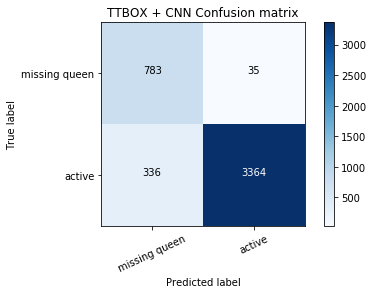

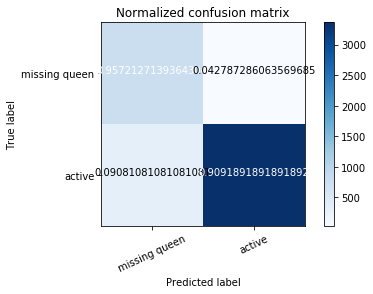

[2020-05-18 16:13:32 RAM67.3% 0.69GB] 
Clasification report TTBOX+ CNN:
                precision    recall  f1-score   support

missing_queen       0.70      0.96      0.81       818
       active       0.99      0.91      0.95      3700

     accuracy                           0.92      4518
    macro avg       0.84      0.93      0.88      4518
 weighted avg       0.94      0.92      0.92      4518



In [70]:
fig = plt.figure()
# Compute confusion matrix
cnf_matrix = confusion_matrix(rounded_labels, rounded_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='TTBOX + CNN Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report TTBOX+ CNN:\n', classification_report(rounded_labels, rounded_predictions, target_names=target_names ))

# Method 4: TTBOX+ DenseNet

In [16]:
X_ttbox= x_ttbox.reshape(-1, 164, 1)
Y_ttbox=y_ttbox.reshape(-1, 1)
X_ttbox.shape, Y_ttbox.shape

((17702, 164, 1), (17702, 1))

In [17]:
# Convert features and corresponding classification labels into numpy arrays
X_ttbox = np.array(X_ttbox.tolist())
Y_ttbox = np.array(Y_ttbox.tolist())
# Encode the classification labels
te = LabelEncoder()
y_ttbox = to_categorical(te.fit_transform(Y_ttbox)) 
# split the dataset 
# split the dataset 
train_x= X_ttbox[4519:]
test_x=X_ttbox[: 4518]
test_y=y_ttbox[:4518]
train_y= y_ttbox[4519:]
#train_x, test_x, train_y, test_y = train_test_split(X_ttbox, y_ttbox, test_size=0.3, random_state = 2020, shuffle=False)
train_x.shape, test_x.shape, train_y.shape, test_y.shape 

C:\Users\PC\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


((13183, 164, 1), (4518, 164, 1), (13183, 2), (4518, 2))

In [18]:
def Dense_Net(size): 
    # size=(164,1 )
    # Create the model
    model=Sequential()
    # the first Dense layer
    model.add(Flatten(input_shape=size))
    model.add(Dense(328))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # the second dense layer 
    model.add(Dense(328))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # the third dense layer 
    model.add(Dense(328))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))

    # the output layer 
    model.add(Dense(2, activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    return model

In [19]:
size=(164, 1)
model2= Dense_Net(size)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 164)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 328)               54120     
_________________________________________________________________
activation_1 (Activation)    (None, 328)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 328)               1312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 328)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 328)               107912    
_________________________________________________________________
activation_2 (Activation)    (None, 328)              

In [20]:
# Set early stopping critiria
pat=5 # this is the number of epocks with no improvment after which the training will stop 
early_stopping= EarlyStopping(monitor='val_loss', patience=pat, verbose=1 )

# define the model check point callback -> this will keep saving the model as a physical file 
model_checkpoint= ModelCheckpoint('DenseNet_bee_1.h5', verbose=1, save_best_only=True )

# define a function to fit the model

def fit_and_evaluate(train_x, val_x, train_y, val_y, EPOCHS=50, BATCH_SIZE=145 ):
    model=None
    model=Dense_Net(( 164,1 ))
    results= model.fit(train_x, train_y, epochs=EPOCHS, batch_size= BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.1)
    print("Val Score :", model.evaluate(val_x, val_y))
    return results 

In [21]:
n_folds=10
epochs=50
batch_size=145

# save the model history in a list after fitting so we can plot later 
model_history=[]
for i in range(n_folds):
    print("Training on Fold :", i+1)
    x_t, x_v, y_t, y_v = train_test_split(train_x, train_y, test_size=0.1, random_state = 2020)
    model_history.append(fit_and_evaluate(x_t, x_v, y_t, y_v, epochs, batch_size))
    print("============="*12, end="\n\n\n")

[2020-05-18 17:21:08 RAM61.9% 0.35GB] Training on Fold : 1
Train on 10677 samples, validate on 1187 samples
Epoch 1/50
10677/10677 [==============================] - ETA: 48s - loss: 1.0249 - accuracy: 0.462 - ETA: 10s - loss: 1.2034 - accuracy: 0.627 - ETA: 4s - loss: 0.8733 - accuracy: 0.697 - ETA: 3s - loss: 0.7619 - accuracy: 0.72 - ETA: 2s - loss: 0.7099 - accuracy: 0.72 - ETA: 1s - loss: 0.6710 - accuracy: 0.73 - ETA: 1s - loss: 0.6272 - accuracy: 0.75 - ETA: 1s - loss: 0.6063 - accuracy: 0.75 - ETA: 0s - loss: 0.5922 - accuracy: 0.75 - ETA: 0s - loss: 0.5730 - accuracy: 0.76 - ETA: 0s - loss: 0.5608 - accuracy: 0.76 - ETA: 0s - loss: 0.5553 - accuracy: 0.76 - ETA: 0s - loss: 0.5431 - accuracy: 0.77 - ETA: 0s - loss: 0.5313 - accuracy: 0.77 - ETA: 0s - loss: 0.5183 - accuracy: 0.78 - ETA: 0s - loss: 0.5121 - accuracy: 0.78 - 2s 153us/step - loss: 0.5100 - accuracy: 0.7853 - val_loss: 0.9370 - val_accuracy: 0.5358

Epoch 00001: val_loss improved from inf to 0.93696, saving model t

10677/10677 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.88 - ETA: 0s - loss: 0.2842 - accuracy: 0.87 - ETA: 0s - loss: 0.3093 - accuracy: 0.86 - ETA: 0s - loss: 0.3144 - accuracy: 0.85 - ETA: 0s - loss: 0.3060 - accuracy: 0.86 - ETA: 0s - loss: 0.3071 - accuracy: 0.86 - ETA: 0s - loss: 0.3072 - accuracy: 0.86 - ETA: 0s - loss: 0.3085 - accuracy: 0.86 - ETA: 0s - loss: 0.3095 - accuracy: 0.86 - ETA: 0s - loss: 0.3118 - accuracy: 0.86 - ETA: 0s - loss: 0.3138 - accuracy: 0.86 - ETA: 0s - loss: 0.3097 - accuracy: 0.86 - ETA: 0s - loss: 0.3103 - accuracy: 0.86 - ETA: 0s - loss: 0.3131 - accuracy: 0.86 - ETA: 0s - loss: 0.3107 - accuracy: 0.86 - ETA: 0s - loss: 0.3141 - accuracy: 0.86 - ETA: 0s - loss: 0.3128 - accuracy: 0.86 - 1s 91us/step - loss: 0.3124 - accuracy: 0.8639 - val_loss: 0.3205 - val_accuracy: 0.8703

Epoch 00005: val_loss did not improve from 0.25163
Epoch 6/50
10677/10677 [==============================] - ETA: 1s - loss: 0.1779 - accuracy: 0.93 

10677/10677 [==============================] - ETA: 1s - loss: 0.2280 - accuracy: 0.92 - ETA: 0s - loss: 0.2595 - accuracy: 0.88 - ETA: 0s - loss: 0.2611 - accuracy: 0.88 - ETA: 0s - loss: 0.2652 - accuracy: 0.88 - ETA: 0s - loss: 0.2608 - accuracy: 0.88 - ETA: 0s - loss: 0.2530 - accuracy: 0.88 - ETA: 0s - loss: 0.2546 - accuracy: 0.88 - ETA: 0s - loss: 0.2538 - accuracy: 0.89 - ETA: 0s - loss: 0.2529 - accuracy: 0.89 - ETA: 0s - loss: 0.2546 - accuracy: 0.89 - ETA: 0s - loss: 0.2564 - accuracy: 0.89 - ETA: 0s - loss: 0.2570 - accuracy: 0.88 - ETA: 0s - loss: 0.2568 - accuracy: 0.88 - ETA: 0s - loss: 0.2540 - accuracy: 0.89 - ETA: 0s - loss: 0.2524 - accuracy: 0.89 - ETA: 0s - loss: 0.2528 - accuracy: 0.89 - 1s 86us/step - loss: 0.2523 - accuracy: 0.8914 - val_loss: 0.3521 - val_accuracy: 0.8374

Epoch 00011: val_loss did not improve from 0.24919
Epoch 12/50
10677/10677 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.88 - ETA: 0s - loss: 0.2658 - accuracy: 0.88

10677/10677 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.85 - ETA: 0s - loss: 0.2244 - accuracy: 0.90 - ETA: 0s - loss: 0.2251 - accuracy: 0.90 - ETA: 0s - loss: 0.2235 - accuracy: 0.90 - ETA: 0s - loss: 0.2266 - accuracy: 0.90 - ETA: 0s - loss: 0.2311 - accuracy: 0.90 - ETA: 0s - loss: 0.2341 - accuracy: 0.90 - ETA: 0s - loss: 0.2334 - accuracy: 0.90 - ETA: 0s - loss: 0.2309 - accuracy: 0.90 - ETA: 0s - loss: 0.2323 - accuracy: 0.90 - ETA: 0s - loss: 0.2344 - accuracy: 0.90 - ETA: 0s - loss: 0.2368 - accuracy: 0.90 - 1s 71us/step - loss: 0.2367 - accuracy: 0.9012 - val_loss: 0.3258 - val_accuracy: 0.8787

Epoch 00018: val_loss did not improve from 0.23120
Epoch 19/50
10677/10677 [==============================] - ETA: 1s - loss: 0.1730 - accuracy: 0.93 - ETA: 0s - loss: 0.2506 - accuracy: 0.89 - ETA: 0s - loss: 0.2387 - accuracy: 0.90 - ETA: 0s - loss: 0.2339 - accuracy: 0.90 - ETA: 0s - loss: 0.2264 - accuracy: 0.90 - ETA: 0s - loss: 0.2268 - accuracy: 0.90

10677/10677 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.84 - ETA: 0s - loss: 0.2648 - accuracy: 0.88 - ETA: 0s - loss: 0.2900 - accuracy: 0.87 - ETA: 0s - loss: 0.2783 - accuracy: 0.88 - ETA: 0s - loss: 0.2762 - accuracy: 0.88 - ETA: 0s - loss: 0.2661 - accuracy: 0.88 - ETA: 0s - loss: 0.2569 - accuracy: 0.89 - ETA: 0s - loss: 0.2546 - accuracy: 0.89 - ETA: 0s - loss: 0.2516 - accuracy: 0.89 - ETA: 0s - loss: 0.2526 - accuracy: 0.89 - ETA: 0s - loss: 0.2543 - accuracy: 0.89 - ETA: 0s - loss: 0.2531 - accuracy: 0.89 - ETA: 0s - loss: 0.2537 - accuracy: 0.89 - ETA: 0s - loss: 0.2561 - accuracy: 0.89 - ETA: 0s - loss: 0.2588 - accuracy: 0.88 - ETA: 0s - loss: 0.2596 - accuracy: 0.88 - 1s 87us/step - loss: 0.2609 - accuracy: 0.8884 - val_loss: 0.2904 - val_accuracy: 0.8719

Epoch 00010: val_loss did not improve from 0.21917
Epoch 11/50
10677/10677 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.90 - ETA: 0s - loss: 0.2160 - accuracy: 0.89

10677/10677 [==============================] - ETA: 1s - loss: 0.2748 - accuracy: 0.88 - ETA: 0s - loss: 0.2695 - accuracy: 0.88 - ETA: 0s - loss: 0.2645 - accuracy: 0.88 - ETA: 0s - loss: 0.2679 - accuracy: 0.88 - ETA: 0s - loss: 0.2631 - accuracy: 0.89 - ETA: 0s - loss: 0.2644 - accuracy: 0.88 - ETA: 0s - loss: 0.2666 - accuracy: 0.88 - ETA: 0s - loss: 0.2631 - accuracy: 0.89 - ETA: 0s - loss: 0.2624 - accuracy: 0.89 - ETA: 0s - loss: 0.2607 - accuracy: 0.89 - ETA: 0s - loss: 0.2629 - accuracy: 0.88 - 1s 69us/step - loss: 0.2648 - accuracy: 0.8889 - val_loss: 0.2972 - val_accuracy: 0.8627

Epoch 00011: val_loss did not improve from 0.21917
Epoch 12/50
10677/10677 [==============================] - ETA: 1s - loss: 0.2184 - accuracy: 0.90 - ETA: 0s - loss: 0.2508 - accuracy: 0.88 - ETA: 0s - loss: 0.2675 - accuracy: 0.88 - ETA: 0s - loss: 0.2639 - accuracy: 0.88 - ETA: 0s - loss: 0.2622 - accuracy: 0.88 - ETA: 0s - loss: 0.2532 - accuracy: 0.89 - ETA: 0s - loss: 0.2498 - accuracy: 0.89

10677/10677 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.85 - ETA: 0s - loss: 0.3109 - accuracy: 0.86 - ETA: 0s - loss: 0.2978 - accuracy: 0.86 - ETA: 0s - loss: 0.2890 - accuracy: 0.86 - ETA: 0s - loss: 0.2803 - accuracy: 0.88 - ETA: 0s - loss: 0.2845 - accuracy: 0.87 - ETA: 0s - loss: 0.2854 - accuracy: 0.87 - ETA: 0s - loss: 0.2811 - accuracy: 0.88 - ETA: 0s - loss: 0.2839 - accuracy: 0.87 - ETA: 0s - loss: 0.2848 - accuracy: 0.87 - ETA: 0s - loss: 0.2856 - accuracy: 0.87 - ETA: 0s - loss: 0.2824 - accuracy: 0.88 - ETA: 0s - loss: 0.2868 - accuracy: 0.88 - ETA: 0s - loss: 0.2839 - accuracy: 0.88 - ETA: 0s - loss: 0.2854 - accuracy: 0.87 - ETA: 0s - loss: 0.2865 - accuracy: 0.87 - 1s 81us/step - loss: 0.2860 - accuracy: 0.8779 - val_loss: 0.2972 - val_accuracy: 0.8719

Epoch 00008: val_loss did not improve from 0.21917
Epoch 9/50
10677/10677 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.92 - ETA: 0s - loss: 0.2682 - accuracy: 0.88 

10677/10677 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.93 - ETA: 0s - loss: 0.2265 - accuracy: 0.89 - ETA: 0s - loss: 0.2437 - accuracy: 0.89 - ETA: 0s - loss: 0.2451 - accuracy: 0.89 - ETA: 0s - loss: 0.2401 - accuracy: 0.89 - ETA: 0s - loss: 0.2449 - accuracy: 0.89 - ETA: 0s - loss: 0.2489 - accuracy: 0.89 - ETA: 0s - loss: 0.2479 - accuracy: 0.89 - ETA: 0s - loss: 0.2488 - accuracy: 0.89 - ETA: 0s - loss: 0.2440 - accuracy: 0.89 - ETA: 0s - loss: 0.2443 - accuracy: 0.89 - ETA: 0s - loss: 0.2431 - accuracy: 0.89 - ETA: 0s - loss: 0.2435 - accuracy: 0.89 - ETA: 0s - loss: 0.2445 - accuracy: 0.89 - ETA: 0s - loss: 0.2445 - accuracy: 0.89 - ETA: 0s - loss: 0.2442 - accuracy: 0.89 - 1s 85us/step - loss: 0.2445 - accuracy: 0.8949 - val_loss: 0.2307 - val_accuracy: 0.9031

Epoch 00017: val_loss did not improve from 0.21917
Epoch 18/50
10677/10677 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.88 - ETA: 0s - loss: 0.2251 - accuracy: 0.90

10677/10677 [==============================] - ETA: 1s - loss: 0.2454 - accuracy: 0.88 - ETA: 0s - loss: 0.2453 - accuracy: 0.88 - ETA: 0s - loss: 0.2571 - accuracy: 0.88 - ETA: 0s - loss: 0.2545 - accuracy: 0.89 - ETA: 0s - loss: 0.2526 - accuracy: 0.89 - ETA: 0s - loss: 0.2573 - accuracy: 0.89 - ETA: 0s - loss: 0.2553 - accuracy: 0.88 - ETA: 0s - loss: 0.2567 - accuracy: 0.89 - ETA: 0s - loss: 0.2571 - accuracy: 0.89 - ETA: 0s - loss: 0.2519 - accuracy: 0.89 - ETA: 0s - loss: 0.2511 - accuracy: 0.89 - ETA: 0s - loss: 0.2523 - accuracy: 0.89 - ETA: 0s - loss: 0.2521 - accuracy: 0.89 - ETA: 0s - loss: 0.2484 - accuracy: 0.89 - ETA: 0s - loss: 0.2486 - accuracy: 0.89 - ETA: 0s - loss: 0.2450 - accuracy: 0.89 - ETA: 0s - loss: 0.2459 - accuracy: 0.89 - ETA: 0s - loss: 0.2456 - accuracy: 0.89 - ETA: 0s - loss: 0.2449 - accuracy: 0.89 - 1s 102us/step - loss: 0.2469 - accuracy: 0.8943 - val_loss: 0.2727 - val_accuracy: 0.8955

Epoch 00014: val_loss did not improve from 0.21917
Epoch 00014: 

10677/10677 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.88 - ETA: 0s - loss: 0.2468 - accuracy: 0.90 - ETA: 0s - loss: 0.2467 - accuracy: 0.89 - ETA: 0s - loss: 0.2531 - accuracy: 0.89 - ETA: 0s - loss: 0.2533 - accuracy: 0.89 - ETA: 0s - loss: 0.2484 - accuracy: 0.89 - ETA: 0s - loss: 0.2416 - accuracy: 0.89 - ETA: 0s - loss: 0.2443 - accuracy: 0.89 - ETA: 0s - loss: 0.2430 - accuracy: 0.89 - ETA: 0s - loss: 0.2413 - accuracy: 0.89 - ETA: 0s - loss: 0.2421 - accuracy: 0.89 - ETA: 0s - loss: 0.2405 - accuracy: 0.89 - ETA: 0s - loss: 0.2416 - accuracy: 0.89 - ETA: 0s - loss: 0.2426 - accuracy: 0.89 - 1s 77us/step - loss: 0.2427 - accuracy: 0.8979 - val_loss: 0.2560 - val_accuracy: 0.8989

Epoch 00017: val_loss did not improve from 0.21917
Epoch 18/50
10677/10677 [==============================] - ETA: 1s - loss: 0.2322 - accuracy: 0.89 - ETA: 0s - loss: 0.2359 - accuracy: 0.90 - ETA: 0s - loss: 0.2411 - accuracy: 0.89 - ETA: 0s - loss: 0.2359 - accuracy: 0.90

In [31]:
model2 = load_model('DenseNet_bee_1.h5')
model2.evaluate(test_x, test_y, verbose=1)

NameError: name 'load_model' is not defined

In [23]:
# Predict labels: 
predicted_classes= model2.predict(test_x)

predicted_classes=np.argmax(np.round(predicted_classes), axis=1)
rounded_predictions = model2.predict_classes(test_x, batch_size=128, verbose=0)
rounded_labels=np.argmax(test_y, axis=1)

[2020-05-18 17:25:45 RAM70.0% 0.89GB] Confusion matrix, without normalization
[2020-05-18 17:25:45 RAM70.0% 0.89GB] [[ 665  153]
 [  26 3674]]
[2020-05-18 17:25:45 RAM70.0% 0.89GB] Normalized confusion matrix
[2020-05-18 17:25:45 RAM70.0% 0.89GB] [[0.81 0.19]
 [0.01 0.99]]


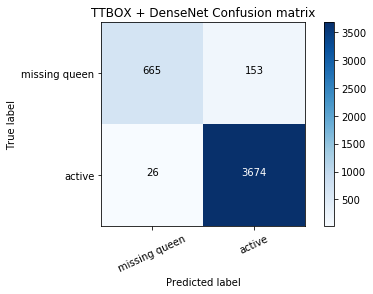

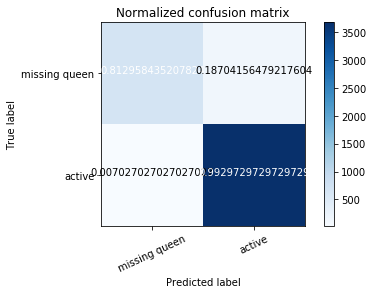

[2020-05-18 17:25:46 RAM70.0% 0.89GB] 
Clasification report TTBOX+ DenseNet:
                precision    recall  f1-score   support

missing_queen       0.96      0.81      0.88       818
       active       0.96      0.99      0.98      3700

     accuracy                           0.96      4518
    macro avg       0.96      0.90      0.93      4518
 weighted avg       0.96      0.96      0.96      4518



In [26]:
fig = plt.figure()
# Compute confusion matrix
cnf_matrix = confusion_matrix(rounded_labels, rounded_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='TTBOX + DenseNet Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
target_names=['missing_queen', 'active']
print ('\nClasification report TTBOX+ DenseNet:\n', classification_report(rounded_labels, rounded_predictions, target_names=target_names ))

# CNN  Ruche decomposition : 

In [1]:
# retrieves unique hives names and also writes these to a file
hives=write_sample_ids_perHive(sample_ids , path_save_audio_labels)  
#hives=get_uniqueHives_names_from_File(path_save_audio_labels)
print(hives.keys())

NameError: name 'write_sample_ids_perHive' is not defined

In [ ]:
# 10% hives for test , 50% for training 
for i in range(3):
    split_dict = split_samples_byHive(0.1, 0.7, hives, path_save_audio_labels+'split_byHive_'+str(i))
    #print(split_dict )
    print(len(split_dict['test']) )  
    print(len(split_dict['train']) )
    print(len(split_dict['val']) )

In [272]:
def get_samples_id_perSet(pathSplitFile):  # reads split_id file

   
    split_dict=json.load(open (pathSplitFile, 'r'))
    
    sample_ids_test = split_dict['test'] 
    sample_ids_train = split_dict['train'] 
    sample_ids_val = split_dict['val']
    return sample_ids_test, sample_ids_train, sample_ids_val

In [ ]:
sample_ids_test, sample_ids_train, sample_ids_val = get_samples_id_perSet(path_workingFolder+'split_byHive_0.json') 
print(len(sample_ids_test),len( sample_ids_train) ,len( sample_ids_val))

In [ ]:
# test 
def train_test_split_ruche(X,yy, sample_ids, sample_ids_train, sample_ids_test, sample_ids_val):
   
    for sample, xi ,yi in enumerate(sample_ids, X, yy):
        if sample==sample_ids_train:
            x_train=xi
            y_train=yi
        elif sample==sample_ids_test:
            x_test=xi
            y_test=yi
        else x_val=xi
             y_val=yi
    # delete sample_ids_test from (path_workingFolder+'split_byHive_0.json')
    os.remove(path_workingFolder+'split_byHive_0.json'+'test')
        
    return  x_train,y_train, x_test, y_test, x_val, y_val ,  sample_ids_test_ruche
for i in n_fold:
    sample_ids_test, sample_ids_train, sample_ids_val=get_samples_id_perSet(path_workingFolder+'split_byHive_0.json') 


In [ ]:
X_train = get_features_from_samples(path_workingFolder, sample_ids_train, 'MFCCs20', 'NO', 0)
X_val = get_features_from_samples(path_workingFolder, sample_ids_val, 'MFCCs20', 'NO', 0)
X_test = get_features_from_samples(path_workingFolder, sample_ids_test, 'MFCCs20', 'NO', 0)

In [ ]:
labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
Y_train= labels2binary('active', labels_train)
labels_val = get_GT_labels_fromFiles(path_workingFolder, sample_ids_val, labels2read)
Y_val= labels2binary('active', labels_val)
labels_test = get_GT_labels_fromFiles(path_workingFolder, sample_ids_test, labels2read)
Y_test= labels2binary('active', labels_test)

In [ ]:
X_train_ruche=np.concatenate((X_train, X_val))
Y_train_ruche=np.concatenate((Y_train, Y_val))
X_test_ruche=np.array(X_test)
Y_test_ruche= np.array(Y_test)
X_train_ruche.shape, Y_train_ruche.shape, X_test_ruche.shape, Y_test_ruche.shape

In [ ]:
X_train_ruche= X_train_ruche.reshape(-1, 20, 44, 1)
X_test_ruche= X_test_ruche.reshape(-1, 20, 44, 1)
Y_train_ruche=Y_train_ruche.reshape(-1, 1)
Y_test_ruche=Y_test_ruche.reshape(-1, 1)

In [ ]:
X_train_ruche.shape, X_test_ruche.shape, Y_train_ruche.shape, Y_test_ruche.shape

In [ ]:
# Visualise and list all data in history
# ---------------------------------------------------    
print(adam.history.keys())

accuracy= adam.history['accuracy']
val_accuracy=adam.history['val_accuracy']
loss=adam.history['loss']

val_loss=adam.history['val_loss']

epochs=range(len(accuracy))
fig = plt.figure()
plt.plot(epochs, accuracy,'ro',  label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
fig.savefig('accuracy.png')
plt.legend()
fig = plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
fig.savefig('loss.png')
#plt.legend()
plt.show()